In [1]:
# !pip install xgboost shap rpy2 linearmodels --quiet
# !pip install numpy==1.26.4 pandas==2.2.2 --no-deps
# !conda install numpy=1.26.4 pandas=2.2.2
# !pip install linearmodels
# !pip install xgboost
# !pip install shap


Now we are going to import all the necessary libraries for data handling, machine learning, statistical modeling, and visualization. 
These imports will help us throughout the project in preparing the data, building models, and analyzing the results.


In [2]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GroupKFold,
    cross_val_score,
     RandomizedSearchCV
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects, compare
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from xgboost import XGBRegressor


## Load Data

We are going to define file paths for all the raw datasets and ensure that each required data file exists before proceeding.


In [81]:
base_root = '../data/raw'
file_paths = {
    'capital': os.path.join(base_root, 'CapitalStockData.csv'),
    'energy': os.path.join(base_root, 'energy_use.csv'),
    'labor_force': os.path.join(base_root, 'labor_force.csv'),
    'patents': os.path.join(base_root, 'patents_res_nonres.csv'),
    'rnd': os.path.join(base_root, 'R&D.csv'),
    'unemployment': os.path.join(base_root, 'unemployed_ilo_estimate.csv'),
    'population': os.path.join(base_root, 'population_Data.csv'),
    'human_capital': os.path.join(base_root, 'Human_Capital_Data.csv'),
    'penn_table': os.path.join(base_root, 'penn_table.csv'),
}
for name, path in file_paths.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Data file not found: {path}")

We are going to load all the raw datasets into a dictionary of DataFrames and check their basic structure to ensure they have been loaded correctly.


In [82]:
dfs = {}
for name, path in file_paths.items():
    try:
        dfs[name] = pd.read_csv(path)
        print(f"Loaded {name}_df: {dfs[name].shape[0]} rows, {dfs[name].shape[1]} columns")
    except Exception as e:
        raise ValueError(f"Failed to load {path}: {str(e)}")
for name, df in dfs.items():
    print(f"\n{name}_df (first 2 rows):")
    display(df.head(2))

Loaded capital_df: 11640 rows, 18 columns
Loaded energy_df: 266 rows, 68 columns
Loaded labor_force_df: 266 rows, 68 columns
Loaded patents_df: 532 rows, 68 columns
Loaded rnd_df: 266 rows, 68 columns
Loaded unemployment_df: 266 rows, 68 columns
Loaded population_df: 6123 rows, 95 columns
Loaded human_capital_df: 803 rows, 68 columns
Loaded penn_table_df: 12810 rows, 52 columns

capital_df (first 2 rows):


countrycode  ifscode  countryname  year  igov_rppp  kgov_rppp  ipriv_rppp   
0         AFG      512  Afghanistan  1960     3.0000    50.0000      1.0000  \
1         AFG      512  Afghanistan  1961     3.0000    52.0000      1.0000   

   kpriv_rppp  ippp_rppp  kppp_rppp  GDP_rppp  igov_n  kgov_n  ipriv_n   
0     15.0000        NaN        NaN       NaN     NaN     NaN      NaN  \
1     15.0000        NaN        NaN       NaN     NaN     NaN      NaN   

   kpriv_n  kppp_n  GDP_n                           income  
0      NaN     NaN    NaN  Low Income Developing Countries  
1      NaN     NaN    NaN  Low Income Developing Countries


energy_df (first 2 rows):


Series Name        Series Code   
0  Energy use (kg of oil equivalent per capita)  EG.USE.PCAP.KG.OE  \
1  Energy use (kg of oil equivalent per capita)  EG.USE.PCAP.KG.OE   

  Country Name countrycode 1960 [YR1960] 1961 [YR1961] 1962 [YR1962]   
0  Afghanistan         AFG            ..            ..            ..  \
1      Albania         ALB            ..            ..            ..   

  1963 [YR1963] 1964 [YR1964] 1965 [YR1965]  ... 2014 [YR2014] 2015 [YR2015]   
0            ..            ..            ..  ...            ..            ..  \
1            ..            ..            ..  ...   808.4558396            ..   

  2016 [YR2016] 2017 [YR2017] 2018 [YR2018] 2019 [YR2019] 2020 [YR2020]   
0            ..            ..            ..            ..            ..  \
1            ..            ..            ..            ..            ..   

  2021 [YR2021] 2022 [YR2022] 2023 [YR2023]  
0            ..            ..            ..  
1            ..            ..            ..  

[2 rows x 68 columns]


labor_force_df (first 2 rows):


Series Name     Series Code Country Name countrycode 1960 [YR1960]   
0  Labor force, total  SL.TLF.TOTL.IN  Afghanistan         AFG            ..  \
1  Labor force, total  SL.TLF.TOTL.IN      Albania         ALB            ..   

  1961 [YR1961] 1962 [YR1962] 1963 [YR1963] 1964 [YR1964] 1965 [YR1965]  ...   
0            ..            ..            ..            ..            ..  ...  \
1            ..            ..            ..            ..            ..  ...   

  2014 [YR2014] 2015 [YR2015] 2016 [YR2016] 2017 [YR2017] 2018 [YR2018]   
0       8229616       8575264       8883595       9223903       9215855  \
1       1244156       1295052       1341701       1363232       1393620   

  2019 [YR2019] 2020 [YR2020] 2021 [YR2021] 2022 [YR2022] 2023 [YR2023]  
0       9194531       9060510       9183905       8617545       8866507  
1       1415825       1352399       1367734       1389262       1376643  

[2 rows x 68 columns]


patents_df (first 2 rows):


Series Name  Series Code Country Name countrycode   
0  Patent applications, nonresidents  IP.PAT.NRES  Afghanistan         AFG  \
1  Patent applications, nonresidents  IP.PAT.NRES      Albania         ALB   

  1960 [YR1960] 1961 [YR1961] 1962 [YR1962] 1963 [YR1963] 1964 [YR1964]   
0            ..            ..            ..            ..            ..  \
1            ..            ..            ..            ..            ..   

  1965 [YR1965]  ... 2014 [YR2014] 2015 [YR2015] 2016 [YR2016] 2017 [YR2017]   
0            ..  ...            ..            ..            ..            ..  \
1            ..  ...             3             5             5             8   

  2018 [YR2018] 2019 [YR2019] 2020 [YR2020] 2021 [YR2021] 2022 [YR2022]   
0            ..            ..            ..            ..            ..  \
1             3             1            ..             1            ..   

  2023 [YR2023]  
0            ..  
1            ..  

[2 rows x 68 columns]


rnd_df (first 2 rows):


Series Name        Series Code Country Name   
0  Researchers in R&D (per million people)  SP.POP.SCIE.RD.P6  Afghanistan  \
1  Researchers in R&D (per million people)  SP.POP.SCIE.RD.P6      Albania   

  countrycode 1960 [YR1960] 1961 [YR1961] 1962 [YR1962] 1963 [YR1963]   
0         AFG            ..            ..            ..            ..  \
1         ALB            ..            ..            ..            ..   

  1964 [YR1964] 1965 [YR1965]  ... 2014 [YR2014] 2015 [YR2015] 2016 [YR2016]   
0            ..            ..  ...            ..            ..            ..  \
1            ..            ..  ...            ..            ..            ..   

  2017 [YR2017] 2018 [YR2018] 2019 [YR2019] 2020 [YR2020] 2021 [YR2021]   
0            ..            ..            ..            ..            ..  \
1            ..            ..            ..            ..            ..   

  2022 [YR2022] 2023 [YR2023]  
0            ..            ..  
1            ..            ..  

[2 rows x 68 columns]


unemployment_df (first 2 rows):


Series Name     Series Code   
0  Unemployment, total (% of total labor force) (...  SL.UEM.TOTL.ZS  \
1  Unemployment, total (% of total labor force) (...  SL.UEM.TOTL.ZS   

  Country Name countrycode 1960 [YR1960] 1961 [YR1961] 1962 [YR1962]   
0  Afghanistan         AFG            ..            ..            ..  \
1      Albania         ALB            ..            ..            ..   

  1963 [YR1963] 1964 [YR1964] 1965 [YR1965]  ... 2014 [YR2014] 2015 [YR2015]   
0            ..            ..            ..  ...         7.915         9.052  \
1            ..            ..            ..  ...        18.055        17.193   

  2016 [YR2016] 2017 [YR2017] 2018 [YR2018] 2019 [YR2019] 2020 [YR2020]   
0        10.133        11.184        11.196        11.185         11.71  \
1        15.418        13.616        12.304        11.466         11.69   

  2021 [YR2021] 2022 [YR2022] 2023 [YR2023]  
0        11.994          14.1        13.991  
1        11.474        10.137        10.108  

[2 rows x 68 columns]


population_df (first 2 rows):


Country Name Country Code   
0  Afghanistan          AFG  \
1  Afghanistan          AFG   

                                         Series Name     Series Code   
0  Age dependency ratio (% of working-age populat...     SP.POP.DPND  \
1                          Age dependency ratio, old  SP.POP.DPND.OL   

      1960 [YR1960]     1961 [YR1961]     1962 [YR1962]     1963 [YR1963]   
0  81.0613894386502  81.2840359519206  81.5068083352119  81.8545805002831  \
1  5.11201905233701  5.09290674973051  5.06917574290293  5.04656900335327   

      1964 [YR1964]     1965 [YR1965]  ...     2041 [YR2041]   
0  82.3730133850468  83.0962139283287  ...  64.8010341971567  \
1  5.02945951585938  5.01989044519751  ...   5.4115807557828   

      2042 [YR2042]     2043 [YR2043]     2044 [YR2044]     2045 [YR2045]   
0     63.8742481928  62.9710690099967  62.1049065054236  61.2935028902416  \
1  5.50825257645877  5.60517537301781  5.70257398087721  5.80326473462997   

      2046 [YR2046]     2047 [YR2047]     2048 [YR2048]     2049 [YR2049]   
0  60.4908498351356  59.7165081417511   58.985722383206  58.2601597694968  \
1  5.90269830827955  5.99954027587882  6.09781396102577  6.19962014092639   

      2050 [YR2050]  
0  57.5832779071994  
1  6.31400253014127  

[2 rows x 95 columns]


human_capital_df (first 2 rows):


Series Name     Series Code Country Name countrycode 1960 [YR1960]   
0  Labor force, total  SL.TLF.TOTL.IN  Afghanistan         AFG            ..  \
1  Labor force, total  SL.TLF.TOTL.IN      Albania         ALB            ..   

  1961 [YR1961] 1962 [YR1962] 1963 [YR1963] 1964 [YR1964] 1965 [YR1965]  ...   
0            ..            ..            ..            ..            ..  ...  \
1            ..            ..            ..            ..            ..  ...   

  2014 [YR2014] 2015 [YR2015] 2016 [YR2016] 2017 [YR2017] 2018 [YR2018]   
0       8229616       8575264       8883595       9223903       9215855  \
1       1244156       1295052       1341701       1363232       1393620   

  2019 [YR2019] 2020 [YR2020] 2021 [YR2021] 2022 [YR2022] 2023 [YR2023]  
0       9194531       9060510       9183905       8617545       8866507  
1       1415825       1352399       1367734       1389262       1376643  

[2 rows x 68 columns]


penn_table_df (first 2 rows):


countrycode country   currency_unit  year  rgdpe  rgdpo  pop  emp  avh  hc   
0         ABW   Aruba  Aruban Guilder  1950    NaN    NaN  NaN  NaN  NaN NaN  \
1         ABW   Aruba  Aruban Guilder  1951    NaN    NaN  NaN  NaN  NaN NaN   

   ...  csh_x  csh_m  csh_r  pl_c  pl_i  pl_g  pl_x  pl_m  pl_n  pl_k  
0  ...    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1  ...    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[2 rows x 52 columns]

We are going to set the display format for floating-point numbers to show four decimal places for better readability.


In [83]:
pd.options.display.float_format = '{:.4f}'.format

## Wrangle Data

At this stage, we examine the structure of each dataset to understand whether it follows a long or wide format, and to identify the relevant columns or series names.


In [84]:
for name, df in dfs.items():
    if df.empty:
        print(f"\n{name}: Empty DataFrame")
        continue
    print(f"\n{name}:")
    if 'Series Name' in df.columns:
        unique_series = df['Series Name'].dropna().unique().tolist()
        print(f"  Series Names: {unique_series}")
    else:
        skip_cols = {'countrycode', 'ifs', 'currency_unit', 'unnamed'}
        data_columns = [
            col for col in df.columns
            if col.lower() not in skip_cols and not col.lower().startswith('unnamed')
        ]
        print(f"  Columns: {data_columns}")


capital:
  Columns: ['ifscode', 'countryname', 'year', 'igov_rppp', 'kgov_rppp', 'ipriv_rppp', 'kpriv_rppp', 'ippp_rppp', 'kppp_rppp', 'GDP_rppp', 'igov_n', 'kgov_n', 'ipriv_n', 'kpriv_n', 'kppp_n', 'GDP_n', 'income']

energy:
  Series Names: ['Energy use (kg of oil equivalent per capita)']

labor_force:
  Series Names: ['Labor force, total']

patents:
  Series Names: ['Patent applications, nonresidents', 'Patent applications, residents']

rnd:
  Series Names: ['Researchers in R&D (per million people)']

unemployment:
  Series Names: ['Unemployment, total (% of total labor force) (modeled ILO estimate)']

population:
  Series Names: ['Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, total (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, female (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, male', '

In this step, we define a function to clean, reshape, and interpolate time-series data by converting wide-format tables into a long format, handling missing values, and preparing summary statistics for imputation tracking.


In [85]:
def process_time_series(
    df: pd.DataFrame,
    id_vars_map: dict,
    year_col: str = 'year',
    cutoff_year: int = 2019,
    drop_id_na_all: bool = True,
    value_name: str = 'value'
):
    df2 = df.rename(columns=id_vars_map).copy()
    yr_pat = re.compile(r'^(\d{4}) \[YR\d{4}\]$')
    strip  = {c: yr_pat.match(c).group(1)
              for c in df2.columns if yr_pat.match(c)}
    if strip:
        df2 = df2.rename(columns=strip)

    id_vars = list(id_vars_map.values())

    if year_col in df2.columns:
        ivy        = id_vars + [year_col]
        value_vars = [c for c in df2.columns if c not in ivy]
        df_long    = df2.melt(
            id_vars    = ivy,
            value_vars = value_vars,
            var_name   = 'series',
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)
    else:
        year_cols = [c for c in df2.columns if c not in id_vars]
        df_long   = df2.melt(
            id_vars    = id_vars,
            value_vars = year_cols,
            var_name   = year_col,
            value_name = value_name
        )
        df_long[year_col] = df_long[year_col].astype(int)

    df_long[value_name] = pd.to_numeric(df_long[value_name], errors='coerce')
    df_long            = df_long[df_long[year_col] <= cutoff_year]

    if drop_id_na_all:
        df_long = df_long.dropna(subset=id_vars + [year_col], how='all')

    df_long['_missing_before'] = df_long[value_name].isna()

    if 'series' in df_long:
        group_cols = id_vars + ['series']
        metric_col = 'series'
    else:
        group_cols = id_vars
        metric_col = id_vars[0]
    df_long = df_long.sort_values(group_cols + [year_col])
    df_long[value_name] = (
        df_long
        .groupby(group_cols)[value_name]
        .transform(lambda s: s.interpolate('linear').ffill().bfill())
    )

    df_long['_imputed']       = df_long['_missing_before'] & df_long[value_name].notna()
    df_long['_missing_after'] = df_long[value_name].isna()

    summary = (
        df_long
        .groupby(metric_col)
        .agg(
            total           =(value_name,      'size'),
            missing_before  =('_missing_before','sum'),
            imputed         =('_imputed',      'sum'),
            missing_after   =('_missing_after','sum'),
        )
        .assign(
            missing_before_pct=lambda d: d['missing_before']/d['total']*100,
            imputed_pct       =lambda d: d['imputed']/d['total']*100,
            missing_after_pct =lambda d: d['missing_after']/d['total']*100,
        )
        .reset_index()
    )
    return df_long, summary


Here, we select relevant columns from the Penn World Table dataset, rename them for clarity, and create a clean DataFrame for further analysis.


In [86]:
penn_table_df = dfs['penn_table']
columns = [
    'countrycode', 'country', 'year',
    'rgdpo',      # Output-side Real GDP at PPP
    'emp',        # Employment
    'avh',        # Average hours worked
    'hc',         # Human capital index
    'cn',         # Capital stock (PPP 2017 US$)
    'ck',         # Capital services (USA=1)
    'ctfp'        # TFP at current PPPs (USA=1)
]

penn_df = penn_table_df[columns].copy()
penn_df = penn_df.rename(columns={
    'countrycode': 'country_code',
    'rgdpo':       'real_gdp_ppp_output',
    'emp':         'employment_million',
    'avh':         'avg_hours_per_year',
    'hc':          'human_capital',
    'cn':          'capital_stock_total',
    'ck':          'capital_services_index',
    'ctfp':        'tfp_index'
})

display(penn_df.head())

country_code country  year  real_gdp_ppp_output  employment_million   
0          ABW   Aruba  1950                  NaN                 NaN  \
1          ABW   Aruba  1951                  NaN                 NaN   
2          ABW   Aruba  1952                  NaN                 NaN   
3          ABW   Aruba  1953                  NaN                 NaN   
4          ABW   Aruba  1954                  NaN                 NaN   

  avg_hours_per_year  human_capital  capital_stock_total   
0                NaN            NaN                  NaN  \
1                NaN            NaN                  NaN   
2                NaN            NaN                  NaN   
3                NaN            NaN                  NaN   
4                NaN            NaN                  NaN   

   capital_services_index  tfp_index  
0                     NaN        NaN  
1                     NaN        NaN  
2                     NaN        NaN  
3                     NaN        NaN  
4                     NaN        NaN

In this step, we clean numeric columns, reshape the Penn Table data into a long format for interpolation, and then pivot it back to a wide format after processing. This prepares the dataset for consistent analysis across years.


In [87]:

numeric_cols = [
    'real_gdp_ppp_output',
    'employment_million',
    'avg_hours_per_year',
    'human_capital',
    'capital_stock_total',
    'capital_services_index',
    'tfp_index'
]

for col in numeric_cols:
    if col in penn_df.columns:
        penn_df[col] = (
            penn_df[col]
            .astype(str)
            .str.replace(',', '')     
            .replace('nan', np.nan)   
            .astype(float)
        )

penn_map = {
    'country_code': 'country_code',
    'country':      'country'
}

penn_long, penn_summary = process_time_series(
    df          = penn_df,
    id_vars_map = penn_map,
    year_col    = 'year',
    cutoff_year = 2019
)

penn_df_processed = (
    penn_long
    .pivot_table(
        index   = list(penn_map.values()) + ['year'],
        columns = 'series',
        values  = 'value'
    )
    .reset_index()
)

print("\nPenn Table Imputation Summary:")
display(penn_summary)



Penn Table Imputation Summary:


series  total  missing_before  imputed  missing_after   
0      avg_hours_per_year  12810            9318     1338           7980  \
1  capital_services_index  12810            5720     2500           3220   
2     capital_stock_total  12810            2496     2286            210   
3      employment_million  12810            3281     3211             70   
4           human_capital  12810            4173     1513           2660   
5     real_gdp_ppp_output  12810            2411     2411              0   
6               tfp_index  12810            6403     1853           4550   

   missing_before_pct  imputed_pct  missing_after_pct  
0             72.7400      10.4450            62.2951  
1             44.6526      19.5160            25.1366  
2             19.4848      17.8454             1.6393  
3             25.6128      25.0664             0.5464  
4             32.5761      11.8111            20.7650  
5             18.8212      18.8212             0.0000  
6             49.9844      14.4653            35.5191

Here, we rename columns for consistency, reshape the capital stock dataset into a long format for interpolation, and then pivot it back to a wide format for further analysis.


In [88]:
capital_df = dfs['capital']
capital_df = capital_df.rename(columns={
    'countryname': 'country',
    'countrycode': 'country_code',
    'income':      'income_group'
})
cap_map = {
    'countrycode': 'country_code',   
    'ifscode':     'ifscode',
    'country':     'country',
    'income':      'income_group'
}
cap_long, cap_summary = process_time_series(
    capital_df,
    id_vars_map = cap_map,
    year_col    = 'year',
    cutoff_year = 2019   # we have target variable only up to 2019
)

capital_df_processed = (
    cap_long
    .pivot_table(
        index   = list(cap_map.values()) + ['year'],
        columns = 'series',
        values  = 'value'
    )
    .reset_index()
)

print("\nAfter imputation summary:")
display(cap_summary)



After imputation summary:


series  total  missing_before  imputed  missing_after   
0        GDP_n  11640            1344     1344              0  \
1     GDP_rppp  11640            1356     1296             60   
2       igov_n  11640            3676     2476           1200   
3    igov_rppp  11640            1350       90           1260   
4    ippp_rppp  11640            6766     3646           3120   
5      ipriv_n  11640            3676     2476           1200   
6   ipriv_rppp  11640            1350       90           1260   
7       kgov_n  11640            3465     2505            960   
8    kgov_rppp  11640            1099       79           1020   
9       kppp_n  11640            6836     3596           3240   
10   kppp_rppp  11640            6836     3596           3240   
11     kpriv_n  11640            3465     2505            960   
12  kpriv_rppp  11640            1099       79           1020   

    missing_before_pct  imputed_pct  missing_after_pct  
0              11.5464      11.5464             0.0000  
1              11.6495      11.1340             0.5155  
2              31.5808      21.2715            10.3093  
3              11.5979       0.7732            10.8247  
4              58.1271      31.3230            26.8041  
5              31.5808      21.2715            10.3093  
6              11.5979       0.7732            10.8247  
7              29.7680      21.5206             8.2474  
8               9.4416       0.6787             8.7629  
9              58.7285      30.8935            27.8351  
10             58.7285      30.8935            27.8351  
11             29.7680      21.5206             8.2474  
12              9.4416       0.6787             8.7629

In this step, we extract key datasets from the raw files, apply a consistent column renaming map, and bundle them into a dictionary for easier processing and inspection.


In [89]:
energy_df = dfs['energy']
labor_force_df = dfs['labor_force']
patents_df = dfs['patents']
rnd_df = dfs['rnd']
unemployment_df = dfs['unemployment']
population_df = dfs['population']
human_capital_df = dfs['human_capital']

wb_map = {
    'Series Name':  'series_name',
    'Series Code':  'series_code',
    'Country Name': 'country',
}

wb_dfs = {
    'energy':        energy_df,
    'labor_force':   labor_force_df,
    'patents':       patents_df,
    'rnd':           rnd_df,
    'unemployment':  unemployment_df,
    'population':    population_df,
    'human_capital': human_capital_df,
}

for name, df in wb_dfs.items():
    print(f"{name}_df: {df.shape[0]} rows, {df.shape[1]} columns")

energy_df: 266 rows, 68 columns
labor_force_df: 266 rows, 68 columns
patents_df: 532 rows, 68 columns
rnd_df: 266 rows, 68 columns
unemployment_df: 266 rows, 68 columns
population_df: 6123 rows, 95 columns
human_capital_df: 803 rows, 68 columns


Here, we remove redundant country code columns from each World Bank-style dataset to streamline the data and avoid duplication.


In [90]:
cleaned = {}
for name, df in wb_dfs.items(): 
    df_cleaned = df.drop(columns=[col for col in ['Country Code', 'countrycode'] if col in df.columns])
    cleaned[name] = df_cleaned
   

We now process each cleaned dataset by reshaping it into a long format, interpolating missing values, and generating summary statistics to track the extent of imputation.


In [91]:
processed = {}
summaries = {}
for name, df in cleaned.items():
    long_filled, summary = process_time_series(
        df,
        id_vars_map = wb_map,
        year_col    = 'year',
        cutoff_year = 2019
    )
    processed[name]  = long_filled
    summaries[name]  = summary


We further clean the processed datasets by removing rows with missing country or series information, and then pivot them back into wide format for easier analysis.


In [92]:
id_cols = ['series_name', 'country']

processed_clean = {}

for name, long_df in processed.items():
    initial_len = len(long_df)
    missing_rows = long_df[id_cols].isna().all(axis=1).sum()

    print(f"\n{name.upper()} dataset:")
    print(f"Initial rows: {initial_len}, Missing ID rows: {missing_rows}")

    df_clean = long_df.dropna(subset=id_cols, how='all')
    dropped_rows = initial_len - len(df_clean)
    print(f"Rows after dropping: {len(df_clean)}, Dropped rows: {dropped_rows}")

    processed_clean[name] = df_clean

    wide_df = df_clean.pivot(index=['country', 'year'], columns='series_name', values='value').reset_index()
    wide_df.columns.name = None
    wide_df.columns = wide_df.columns.astype(str)

    locals()[f"{name}_df_processed"] = wide_df



ENERGY dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

LABOR_FORCE dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

PATENTS dataset:
Initial rows: 31920, Missing ID rows: 0
Rows after dropping: 31920, Dropped rows: 0

RND dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

UNEMPLOYMENT dataset:
Initial rows: 15960, Missing ID rows: 0
Rows after dropping: 15960, Dropped rows: 0

POPULATION dataset:
Initial rows: 367380, Missing ID rows: 180
Rows after dropping: 367200, Dropped rows: 180

HUMAN_CAPITAL dataset:
Initial rows: 48180, Missing ID rows: 180
Rows after dropping: 48000, Dropped rows: 180


We consolidate all processed datasets into a dictionary and inspect the top missing variables for each table to assess data quality before further analysis.


In [93]:
wide_dfs = {
    'capital': capital_df_processed,
    'energy': energy_df_processed,
    'labor_force': labor_force_df_processed,
    'patents': patents_df_processed,
    'rnd': rnd_df_processed,
    'unemployment': unemployment_df_processed,
    'population': population_df_processed,
    'human_capital': human_capital_df_processed,
    'penn': penn_df_processed,
}

for name, df in wide_dfs.items():
    print(f"\n{name.upper()} dataset (rows={len(df)}):")

    missing_info = pd.DataFrame({
        'missing_count': df.isna().sum(),
        'missing_pct': (df.isna().mean() * 100).round(2)
    })
    display(missing_info.sort_values(by='missing_pct', ascending=False).head(10))



CAPITAL dataset (rows=11640):


missing_count  missing_pct
series                                
kppp_rppp            3240      27.8400
kppp_n               3240      27.8400
ippp_rppp            3120      26.8000
igov_rppp            1260      10.8200
ipriv_rppp           1260      10.8200
ipriv_n              1200      10.3100
igov_n               1200      10.3100
kgov_rppp            1020       8.7600
kpriv_rppp           1020       8.7600
kgov_n                960       8.2500


ENERGY dataset (rows=15960):


missing_count  missing_pct
Energy use (kg of oil equivalent per capita)           2760      17.2900
country                                                   0       0.0000
year                                                      0       0.0000


LABOR_FORCE dataset (rows=15960):


missing_count  missing_pct
Labor force, total           1860      11.6500
country                         0       0.0000
year                            0       0.0000


PATENTS dataset (rows=15960):


missing_count  missing_pct
Patent applications, residents              5820      36.4700
Patent applications, nonresidents           5160      32.3300
country                                        0       0.0000
year                                           0       0.0000


RND dataset (rows=15960):


missing_count  missing_pct
Researchers in R&D (per million people)           5940      37.2200
country                                              0       0.0000
year                                                 0       0.0000


UNEMPLOYMENT dataset (rows=15960):


missing_count  missing_pct
Unemployment, total (% of total labor force) (m...           1860      11.6500
country                                                         0       0.0000
year                                                            0       0.0000


POPULATION dataset (rows=16080):


missing_count  missing_pct
nan                                               16080     100.0000
Life expectancy at birth, female (years)            720       4.4800
Life expectancy at birth, male (years)              720       4.4800
Life expectancy at birth, total (years)             720       4.4800
Urban population growth (annual %)                  540       3.3600
Urban population (% of total population)            540       3.3600
Urban population                                    540       3.3600
Rural population (% of total population)            540       3.3600
Rural population                                    540       3.3600
Population growth (annual %)                        420       2.6100


HUMAN_CAPITAL dataset (rows=16020):


missing_count  missing_pct
Data from database: World Development Indicators            16020     100.0000
Last Updated: 01/28/2025                                    16020     100.0000
Human capital index (HCI) (scale 0-1)                        6000      37.4500
Labor force, total                                           1920      11.9900
Unemployment, total (% of total labor force) (m...           1920      11.9900
country                                                        60       0.3700
year                                                            0       0.0000


PENN dataset (rows=12810):


missing_count  missing_pct
series                                            
avg_hours_per_year               7980      62.3000
tfp_index                        4550      35.5200
capital_services_index           3220      25.1400
human_capital                    2660      20.7700
capital_stock_total               210       1.6400
employment_million                 70       0.5500
country_code                        0       0.0000
country                             0       0.0000
year                                0       0.0000
real_gdp_ppp_output                 0       0.0000

Since penn_df has some data which can help impute capital_df, we want to check similarity first, and impute GDP_data as well as capital_stock_data before finally merging them and Name that to base_data**

We merge the cleaned Capital Stock and Penn Table datasets, handle overlapping country codes, and reorder the columns to prepare a structured base dataset for further merging.


In [94]:
base_df = pd.merge(capital_df_processed, penn_df_processed, on=['country', 'year'], how='left')

base_df['country_code'] = base_df[['country_code_x', 'country_code_y']].bfill(axis=1).iloc[:, 0]
base_df.drop(columns=['country_code_x', 'country_code_y'], inplace=True)

ordered_cols = ['country', 'country_code'] + [col for col in base_df if col not in ['country', 'country_code']]
base_df = base_df[ordered_cols]

print(f"Merged Base DataFrame shape: {base_df.shape}")
print("Columns after merging and reordering:")
print(base_df.columns.tolist())
display(base_df.head())


Merged Base DataFrame shape: (11640, 25)
Columns after merging and reordering:
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index']


series country country_code  ifscode               income_group  year  GDP_n   
0        Aruba          ABW      314  Emerging Market Economies  1960 0.0000  \
1        Aruba          ABW      314  Emerging Market Economies  1961 0.0000   
2        Aruba          ABW      314  Emerging Market Economies  1962 0.0000   
3        Aruba          ABW      314  Emerging Market Economies  1963 0.0000   
4        Aruba          ABW      314  Emerging Market Economies  1964 0.0000   

series  GDP_rppp  igov_n  igov_rppp  ippp_rppp  ...  kppp_rppp  kpriv_n   
0         0.0000     NaN        NaN        NaN  ...        NaN   0.0000  \
1         0.0000     NaN        NaN        NaN  ...        NaN   0.0000   
2         0.0000     NaN        NaN        NaN  ...        NaN   0.0000   
3         0.0000     NaN        NaN        NaN  ...        NaN   0.0000   
4         0.0000     NaN        NaN        NaN  ...        NaN   0.0000   

series  kpriv_rppp  avg_hours_per_year  capital_services_index   
0           0.0000                 NaN                  0.0000  \
1           0.0000                 NaN                  0.0000   
2           0.0000                 NaN                  0.0000   
3           0.0000                 NaN                  0.0000   
4           0.0000                 NaN                  0.0000   

series  capital_stock_total  employment_million  human_capital   
0                 1224.0000              0.0000            NaN  \
1                 1224.0000              0.0000            NaN   
2                 1224.0000              0.0000            NaN   
3                 1224.0000              0.0000            NaN   
4                 1224.0000              0.0000            NaN   

series  real_gdp_ppp_output  tfp_index  
0                  463.0000        NaN  
1                  463.0000        NaN  
2                  463.0000        NaN  
3                  463.0000        NaN  
4                  463.0000        NaN  

[5 rows x 25 columns]

We iteratively merge additional cleaned datasets into the base DataFrame using country and year as keys, creating a comprehensive dataset for analysis.


In [95]:
datasets_to_merge = [
    population_df_processed,
    human_capital_df_processed,
    labor_force_df_processed,
    unemployment_df_processed,
    rnd_df_processed,
    patents_df_processed,
    energy_df_processed
]

merged_data = base_df.copy()

for df in datasets_to_merge:
    merged_data = merged_data.merge(
        df,
        on = ['country','year'],
        how = 'left'
    )

print("Final merged shape:", merged_data.shape)
print(merged_data.columns.tolist())
merged_data.head()


Final merged shape: (11640, 60)
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index', 'nan', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, total (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, female (% of female population)', 'Population ages 15-64, male', 'Population ages 15-64, male (% of male population)', 'Population ages 15-64, total', 'Population growth (annual %)', 'Population, female', 'Population, female (% of total population)',

country country_code  ifscode               income_group  year  GDP_n   
0   Aruba          ABW      314  Emerging Market Economies  1960 0.0000  \
1   Aruba          ABW      314  Emerging Market Economies  1961 0.0000   
2   Aruba          ABW      314  Emerging Market Economies  1962 0.0000   
3   Aruba          ABW      314  Emerging Market Economies  1963 0.0000   
4   Aruba          ABW      314  Emerging Market Economies  1964 0.0000   

   GDP_rppp  igov_n  igov_rppp  ippp_rppp  ...   
0    0.0000     NaN        NaN        NaN  ...  \
1    0.0000     NaN        NaN        NaN  ...   
2    0.0000     NaN        NaN        NaN  ...   
3    0.0000     NaN        NaN        NaN  ...   
4    0.0000     NaN        NaN        NaN  ...   

   Human capital index (HCI) (scale 0-1)  Labor force, total_x   
0                                    NaN                   NaN  \
1                                    NaN                   NaN   
2                                    NaN                   NaN   
3                                    NaN                   NaN   
4                                    NaN                   NaN   

   Last Updated: 01/28/2025   
0                       NaN  \
1                       NaN   
2                       NaN   
3                       NaN   
4                       NaN   

   Unemployment, total (% of total labor force) (modeled ILO estimate)_x   
0                                                NaN                      \
1                                                NaN                       
2                                                NaN                       
3                                                NaN                       
4                                                NaN                       

   Labor force, total_y   
0                   NaN  \
1                   NaN   
2                   NaN   
3                   NaN   
4                   NaN   

   Unemployment, total (% of total labor force) (modeled ILO estimate)_y   
0                                                NaN                      \
1                                                NaN                       
2                                                NaN                       
3                                                NaN                       
4                                                NaN                       

   Researchers in R&D (per million people)  Patent applications, nonresidents   
0                                      NaN                                NaN  \
1                                      NaN                                NaN   
2                                      NaN                                NaN   
3                                      NaN                                NaN   
4                                      NaN                                NaN   

   Patent applications, residents   
0                          1.0000  \
1                          1.0000   
2                          1.0000   
3                          1.0000   
4                          1.0000   

   Energy use (kg of oil equivalent per capita)  
0                                           NaN  
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN  

[5 rows x 60 columns]

We refine the merged dataset by imputing missing GDP and capital components using linear regression and interpolation, recalculating missing values based on relationships among variables, and dropping invalid rows to ensure data quality.


In [96]:
print("Rows in merged_data before operation:", len(merged_data))
merged_data['GDP_rppp'] = merged_data['GDP_rppp'].replace(0, np.nan)

merged_data['real_gdp_ppp_bil'] = merged_data['real_gdp_ppp_output'] / 1000
mask_both = merged_data[['GDP_rppp', 'real_gdp_ppp_bil']].notna().all(axis=1)
correlation = merged_data.loc[mask_both, 'GDP_rppp'].corr(merged_data.loc[mask_both, 'real_gdp_ppp_bil'])
print("\nCorrelation between GDP_rppp and real_gdp_ppp_output / 1000:", correlation)

def impute_gdp_group(group):
    gdp_preds = ['GDP_n', 'real_gdp_ppp_bil']
    mask_train = group[['GDP_rppp'] + gdp_preds].notna().all(axis=1)
    if mask_train.sum() >= 3: 
        X_train = group.loc[mask_train, gdp_preds]
        y_train = group.loc[mask_train, 'GDP_rppp']
        model = LinearRegression()
        model.fit(X_train, y_train)
        mask_predict = group['GDP_rppp'].isna() & group[gdp_preds].notna().all(axis=1)
        if mask_predict.any():
            group.loc[mask_predict, 'GDP_rppp'] = model.predict(group.loc[mask_predict, gdp_preds])
    return group

merged_data = merged_data.groupby('country').apply(impute_gdp_group).reset_index(drop=True)
components = ['kgov_rppp', 'kpriv_rppp', 'kppp_rppp']

for comp in components:
    merged_data[comp] = merged_data.groupby('country')[comp].transform(lambda x: x.interpolate())

merged_data['capital_stock_bil'] = merged_data['capital_stock_total'] / 1000

def impute_capital_group(group):
    for comp in components:
        other_comps = [c for c in components if c != comp]
        mask = (
            group[comp].isna() & 
            group[other_comps].notna().all(axis=1) & 
            group['capital_stock_bil'].notna()
        )
        if mask.any():
            other_sum = group.loc[mask, other_comps].sum(axis=1)
            group.loc[mask, comp] = group.loc[mask, 'capital_stock_bil'] - other_sum
    return group

merged_data = merged_data.groupby('country').apply(impute_capital_group).reset_index(drop=True)

for col in ['GDP_rppp'] + components:
    merged_data[col] = merged_data[col].fillna(0)

mask_all_components_zero = (merged_data[components] == 0).all(axis=1)
mask_gdp_zero = (merged_data['GDP_rppp'] == 0)
mask_drop = mask_all_components_zero | mask_gdp_zero

rows_to_drop = mask_drop.sum()
print(f"\nRows to drop: {rows_to_drop}")
merged_data = merged_data[~mask_drop]

print("Rows in merged_data after operation:", len(merged_data))

print("\nFinal merged shape:", merged_data.shape)
print("Columns in merged_data:")
print(merged_data.columns.tolist())

Rows in merged_data before operation: 11640

Correlation between GDP_rppp and real_gdp_ppp_output / 1000: 0.9943808131793983

Rows to drop: 1464
Rows in merged_data after operation: 10176

Final merged shape: (10176, 62)
Columns in merged_data:
['country', 'country_code', 'ifscode', 'income_group', 'year', 'GDP_n', 'GDP_rppp', 'igov_n', 'igov_rppp', 'ippp_rppp', 'ipriv_n', 'ipriv_rppp', 'kgov_n', 'kgov_rppp', 'kppp_n', 'kppp_rppp', 'kpriv_n', 'kpriv_rppp', 'avg_hours_per_year', 'capital_services_index', 'capital_stock_total', 'employment_million', 'human_capital', 'real_gdp_ppp_output', 'tfp_index', 'nan', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old', 'Age dependency ratio, young', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Life expectancy at birth, total (years)', 'Population ages 15-64 (% of total population)', 'Population ages 15-64, female', 'Population ages 15-64, female (% of female population)', 'Po

We generate a summary of missing and zero values for each country to assess data completeness and identify potential issues in the final dataset.


In [97]:
metrics_cols = [c for c in merged_data.columns if c not in ['country', 'country_code', 'year']]

summary_by_country = (
    merged_data.groupby(['country', 'country_code'])
    .apply(lambda g: pd.Series({
        'periods': len(g),
        'total_cells': g[metrics_cols].size,
        'missing_cells': g[metrics_cols].isna().sum().sum(),
        'zero_cells': (g[metrics_cols] == 0).sum().sum()
    }))
    .reset_index()
)

summary_by_country['missing_pct'] = (summary_by_country['missing_cells'] / summary_by_country['total_cells'] * 100).round(2)
summary_by_country['zero_pct'] = (summary_by_country['zero_cells'] / summary_by_country['total_cells'] * 100).round(2)

print(summary_by_country.sort_values('missing_pct', ascending=False).head(10))


                               country country_code  periods  total_cells   
154           Taiwan Province of China          TWN       60         3540  \
73                       Hong Kong SAR          HKG       60         3540   
88                               Korea          KOR       60         3540   
153              São Tomé and Príncipe          STP       14          826   
169                            Vietnam          VNM       60         3540   
168                          Venezuela          VEN       60         3540   
152                              Syria          SYR       60         3540   
38   Congo, Democratic Republic of the          COD       60         3540   
39                  Congo, Republic of          COG       60         3540   
78                                Iran          IRN       60         3540   

     missing_cells  zero_cells  missing_pct  zero_pct  
154           2760          60      77.9700    1.6900  
73            2760          71      77.9

We drop countries that have more than 40% missing values or more than 50% missing plus zero values combined, to ensure a cleaner and more reliable dataset for analysis.


In [98]:
drop_countries = summary_by_country.query(
    'missing_pct > 40 or (missing_pct + zero_pct) > 50'
)['country'].tolist()

print(f"Countries dropped ({len(drop_countries)}):", drop_countries)

filtered_data = merged_data[~merged_data['country'].isin(drop_countries)].copy()

print(f"Rows before filtering: {len(merged_data)}, after filtering: {len(filtered_data)}")


Countries dropped (18): ['Congo, Democratic Republic of the', 'Congo, Republic of', 'Czech Republic', "Côte d'Ivoire", 'Egypt', 'Hong Kong SAR', 'Iran', 'Korea', 'Lao P.D.R.', 'Montenegro, Rep. of', 'Russia', 'Syria', 'São Tomé and Príncipe', 'Taiwan Province of China', 'Turkey', 'Venezuela', 'Vietnam', 'Yemen']
Rows before filtering: 10176, after filtering: 9142


**DATA PROFILE ON FILTERED DATA (AFTER APPLYING MASK)**

At this step, we fill remaining missing values, evaluate columns for missing or zero values, and flag those with excessive void percentages for removal to refine the dataset.


In [99]:
filtered_data['kppp_rppp'] = filtered_data['kppp_rppp'].fillna(0)

n_rows_filtered = filtered_data.shape[0]
filtered_col_stats = pd.DataFrame({
    'missing_count': filtered_data.isna().sum(),
    'missing_pct':   (filtered_data.isna().mean() * 100),
    'zero_count':    (filtered_data == 0).sum(),
    'zero_pct':      ((filtered_data == 0).mean() * 100)
})

filtered_col_stats['total_void'] = filtered_col_stats['missing_count'] + filtered_col_stats['zero_count']
filtered_col_stats['total_void_pct'] = (filtered_col_stats['total_void'] / n_rows_filtered) * 100

cols_100_missing = filtered_col_stats[filtered_col_stats['missing_pct'] == 100].index.tolist()
cols_high_void = filtered_col_stats[filtered_col_stats['total_void_pct'] > 75].index.tolist()
cols_to_drop = list(set(cols_100_missing + cols_high_void))  # Combine and remove duplicates

print(f"Columns with 100% missing data (to be dropped): {cols_100_missing}")
print(f"Columns with total void percentage > 75% (to be dropped): {cols_high_void}")

Columns with 100% missing data (to be dropped): ['nan', 'Data from database: World Development Indicators', 'Last Updated: 01/28/2025']
Columns with total void percentage > 75% (to be dropped): ['ippp_rppp', 'kppp_n', 'capital_services_index', 'nan', 'Data from database: World Development Indicators', 'Last Updated: 01/28/2025']


After removing columns with excessive missing or zero values, we update the summary statistics to verify the improvements in data completeness and check the final structure of the dataset.


In [100]:
filtered_data = filtered_data.drop(columns=cols_to_drop)
filtered_col_stats_updated = pd.DataFrame({
    'missing_count': filtered_data.isna().sum(),
    'missing_pct':   (filtered_data.isna().mean() * 100).round(2),
    'zero_count':    (filtered_data == 0).sum(),
    'zero_pct':      ((filtered_data == 0).mean() * 100).round(2)
})

filtered_col_stats_updated['total_void'] = filtered_col_stats_updated['missing_count'] + filtered_col_stats_updated['zero_count']
filtered_col_stats_updated['total_void_pct'] = (filtered_col_stats_updated['total_void'] / n_rows_filtered * 100).round(2)

filtered_col_stats_updated = filtered_col_stats_updated[
    ['missing_count', 'missing_pct', 'zero_count', 'zero_pct', 'total_void', 'total_void_pct']
].sort_values('missing_pct', ascending=False)

print(f"Dropped columns: {cols_to_drop}")
print(f"Updated filtered_data shape: {filtered_data.shape}")
# Sort the DataFrame alphabetically by column names
sorted_df = filtered_col_stats_updated.sort_index(axis=1)

# Display the sorted DataFrame
display(sorted_df)


Dropped columns: ['ippp_rppp', 'nan', 'Last Updated: 01/28/2025', 'Data from database: World Development Indicators', 'capital_services_index', 'kppp_n']
Updated filtered_data shape: (9142, 56)


missing_count   
avg_hours_per_year                                           5640  \
tfp_index                                                    3244   
Researchers in R&D (per million people)                      2443   
human_capital                                                2008   
Patent applications, residents                               1484   
Patent applications, nonresidents                            1176   
Human capital index (HCI) (scale 0-1)                        1092   
Energy use (kg of oil equivalent per capita)                  960   
capital_stock_bil                                             717   
capital_stock_total                                           717   
real_gdp_ppp_bil                                              657   
real_gdp_ppp_output                                           657   
employment_million                                            657   
Labor force, total_x                                          330   
Unemployment, total (% of total labor force) (m...            330   
Labor force, total_y                                          330   
Unemployment, total (% of total labor force) (m...            330   
igov_rppp                                                      82   
igov_n                                                         82   
ipriv_rppp                                                     82   
ipriv_n                                                        82   
kgov_n                                                         22   
kpriv_n                                                        22   
Population growth (annual %)                                    0   
Urban population growth (annual %)                              0   
Urban population (% of total population)                        0   
Urban population                                                0   
Rural population (% of total population)                        0   
Rural population                                                0   
Population, total                                               0   
Population, male (% of total population)                        0   
Population, male                                                0   
Population, female (% of total population)                      0   
Population, female                                              0   
country                                                         0   
Population ages 15-64, total                                    0   
Age dependency ratio (% of working-age population)              0   
ifscode                                                         0   
income_group                                                    0   
year                                                            0   
GDP_n                                                           0   
GDP_rppp                                                        0   
kgov_rppp                                                       0   
kppp_rppp                                                       0   
kpriv_rppp                                                      0   
Age dependency ratio, old                                       0   
Population ages 15-64, male (% of male population)              0   
Age dependency ratio, young                                     0   
Life expectancy at birth, female (years)                        0   
Life expectancy at birth, male (years)                          0   
Life expectancy at birth, total (years)                         0   
country_code                                                    0   
Population ages 15-64, female                                   0   
Population ages 15-64, female (% of female popu...              0   
Population ages 15-64, male                                     0   
Population ages 15-64 (% of total population)                   0   

                                                    missing_pct  total_void   
avg_hours_per_year                     

In this step, we select important features, rename columns for clarity, create new engineered variables, and apply targeted imputations to fill missing values using group-based strategies and median replacements.


In [ ]:

keep = [
    'country', 'income_group', 'country_code', 'year',
    'GDP_rppp',
    'kppp_rppp', 'kpriv_rppp', 'kgov_rppp',  # Capital group
    'Labor force, total_x', 'Human capital index (HCI) (scale 0-1)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)_x',  # Labor group
    'tfp_index', 'Researchers in R&D (per million people)', 'Patent applications, residents', 'Patent applications, nonresidents', 'Energy use (kg of oil equivalent per capita)',  # Technology group
    'Population, total', 'Age dependency ratio (% of working-age population)', 'Urban population (% of total population)'  # Demographics group
]

df = filtered_data[keep].copy()


In [103]:
df.to_csv("manual_merge.csv", index=False)

In [101]:

rename_map = {
    'kppp_rppp': 'ppp_capital',
    'kpriv_rppp': 'priv_capital',
    'kgov_rppp': 'gov_capital',
    'Labor force, total_x': 'labor_force',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)_x': 'unemployment_pct',
    'Human capital index (HCI) (scale 0-1)': 'HCI',
    'tfp_index': 'tfp_idx',
    'Population, total': 'pop_total',
    'Age dependency ratio (% of working-age population)': 'age_dep_ratio',
    'Urban population (% of total population)': 'urban_pop_pct',
    'Researchers in R&D (per million people)': 'rnd_per_mil',
    'Patent applications, residents': 'patents_res',
    'Patent applications, nonresidents': 'patents_nonres',
    'Energy use (kg of oil equivalent per capita)': 'energy_pc'
}

df.rename(columns=rename_map, inplace=True)

df['effective_labor'] = df['labor_force'] * df['HCI']

df['total_patents'] = df['patents_res'] + df['patents_nonres']
df['energy_per_labor'] = (df['energy_pc'] * df['pop_total']) / df['labor_force']

df.drop(columns=['patents_res', 'patents_nonres'], inplace=True)
print("\nStarting Imputation Process")

df['labor_force'] = df.groupby('country')['labor_force'].transform(
    lambda x: x.fillna(filtered_data.loc[x.index, 'Labor force, total_y'])
)
df['unemployment_pct'] = df.groupby('country')['unemployment_pct'].transform(
    lambda x: x.fillna(filtered_data.loc[x.index, 'Unemployment, total (% of total labor force) (modeled ILO estimate)_y'])
)

print("\nHCI value range before adjustment:")
print(f"Min: {df['HCI'].min()}, Max: {df['HCI'].max()}")

if df['HCI'].max() > 1 or df['HCI'].min() < 0:
    human_capital_scaled = (filtered_data['human_capital'] - filtered_data['human_capital'].min()) / (
        filtered_data['human_capital'].max() - filtered_data['human_capital'].min()
    )
    df['HCI'] = df.groupby('country')['HCI'].transform(lambda x: x.fillna(human_capital_scaled.loc[x.index]))
else:
    df['HCI'] = df.groupby('country')['HCI'].transform(
        lambda x: x.fillna(filtered_data.loc[x.index, 'human_capital'])
    )

df['HCI'] = df['HCI'].clip(0, 1)

rnd_medians = df[df['rnd_per_mil'] != 0].groupby('country')['rnd_per_mil'].median()
df['rnd_per_mil'] = df.apply(
    lambda row: rnd_medians[row['country']] if row['rnd_per_mil'] == 0 and row['country'] in rnd_medians else row['rnd_per_mil'],
    axis=1
)
df['rnd_per_mil'] = df['rnd_per_mil'].fillna(df['rnd_per_mil'].median())

group_medians = df.groupby('country')['energy_pc'].median()
df['energy_pc'] = df.apply(
    lambda row: group_medians[row['country']] if pd.isna(row['energy_pc']) else row['energy_pc'],
    axis=1
)

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'GDP_rppp' and col not in ['effective_labor', 'total_patents', 'energy_per_labor']]

for col in categorical_features:
    mode_per_country = df.groupby('country')[col].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    df[col] = df.apply(
        lambda row: mode_per_country[row['country']] if pd.isna(row[col]) else row[col],
        axis=1
    )

df = df.sort_values(['country', 'year'])
for col in numerical_features:
    df[col] = df.groupby('country')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    df[col] = df.groupby('country')[col].transform(lambda x: x.ffill())
    df[col] = df.groupby('country')[col].transform(lambda x: x.bfill())
    df[col] = df[col].fillna(df[col].median())




Starting Imputation Process

HCI value range before adjustment:
Min: 0.286074638, Max: 0.88708365


We apply Principal Component Analysis (PCA) within each feature group (capital, labor, technology, and demographics), to reduce dimensionality while retaining key patterns, and prepare final inputs for modeling.


In [102]:
df.shape

(9142, 20)

In [24]:
capital_cols = ['ppp_capital', 'priv_capital', 'gov_capital']
labor_cols = ['labor_force', 'HCI', 'unemployment_pct', 'effective_labor']
tech_cols = ['tfp_idx', 'rnd_per_mil', 'total_patents', 'energy_per_labor']
demo_cols = ['pop_total', 'age_dep_ratio', 'urban_pop_pct']

def block_pca(df, cols, n_components=1, prefix=None):
    if prefix is None:
        prefix = cols[0].split('_')[0]
    scaler = StandardScaler()
    X = scaler.fit_transform(df[cols].fillna(0))
    pcs = PCA(n_components=n_components).fit_transform(X)
    for i in range(n_components):
        df[f"{prefix}_PC{i+1}"] = pcs[:, i]
    return df

df = block_pca(df, capital_cols, n_components=1, prefix='capital')
df = block_pca(df, labor_cols, n_components=1, prefix='labor')
df = block_pca(df, tech_cols, n_components=1, prefix='tech')
df = block_pca(df, demo_cols, n_components=1, prefix='demo')

original_features = capital_cols + labor_cols + tech_cols + demo_cols
pca_features = ['capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1']

X_original = df[original_features]
X_pca = df[pca_features]
y = df['GDP_rppp']

print("\nFinal shape:", df.shape)
print("\nMissing counts:")
print(df.isna().sum())
print("\nZero counts:")
print((df == 0).sum())



Final shape: (9142, 24)

Missing counts:
country                0
income_group           0
country_code           0
year                   0
GDP_rppp               0
ppp_capital            0
priv_capital           0
gov_capital            0
labor_force            0
HCI                    0
unemployment_pct       0
tfp_idx                0
rnd_per_mil            0
energy_pc              0
pop_total              0
age_dep_ratio          0
urban_pop_pct          0
effective_labor     1362
total_patents       1604
energy_per_labor    1230
capital_PC1            0
labor_PC1              0
tech_PC1               0
demo_PC1               0
dtype: int64

Zero counts:
country                0
income_group           0
country_code           0
year                   0
GDP_rppp               0
ppp_capital         5941
priv_capital         281
gov_capital          430
labor_force            0
HCI                    0
unemployment_pct       0
tfp_idx             1571
rnd_per_mil            0
energy

To maintain data integrity, we validate the presence of essential variables and drop rows where either capital components or population and labor force values are missing or zero.


In [25]:
required_cols = ['gov_capital', 'priv_capital', 'ppp_capital', 'pop_total', 'labor_force']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in df: {missing_cols}")

before_count = len(df)
print(f"\nRows before dropping: {before_count}")

capital_condition = ~((df['gov_capital'] == 0) | (df['priv_capital'] == 0))
pop_labor_condition = ~((df['pop_total'] == 0)  & (df['labor_force'] == 0))

df = df[capital_condition | pop_labor_condition].reset_index(drop=True)

after_count = len(df)
print(f"Rows after dropping: {after_count}")
print(f"Rows dropped: {before_count - after_count}")
print(f"Updated DataFrame shape: {df.shape}")


Rows before dropping: 9142
Rows after dropping: 9142
Rows dropped: 0
Updated DataFrame shape: (9142, 24)


Here, we detect and drop outlier rows based on abnormal trends in private capital, government capital, and GDP using a country-specific rolling Z-score approach.


In [26]:

def z_outliers(s: pd.Series, window: int = 5, threshold: float = 3) -> pd.Series:
    rolling_mean = s.rolling(window, min_periods=1, center=True).mean()
    rolling_std = s.rolling(window, min_periods=1, center=True).std()
    z_scores = (s - rolling_mean) / rolling_std.replace(0, np.nan).fillna(1)
    outliers = z_scores.abs() > threshold
    return outliers.fillna(False)  

required_cols = ['priv_capital', 'gov_capital', 'GDP_rppp', 'country']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns for outlier detection: {missing_cols}")

for col in ['priv_capital', 'gov_capital', 'GDP_rppp']:
    df[f'{col}_outlier'] = (
        df.groupby('country')[col]
        .transform(z_outliers)
        .astype(int)
    )

initial_rows = len(df)
df_cleaned = df[df[['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']].eq(0).all(axis=1)].reset_index(drop=True)
rows_dropped = initial_rows - len(df_cleaned)
print(f"Dropped rows due to outliers: {rows_dropped}")

print("\nShape of df_cleaned:", df_cleaned.shape)
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

Dropped rows due to outliers: 0

Shape of df_cleaned: (9142, 27)
Columns in df_cleaned:
['country', 'income_group', 'country_code', 'year', 'GDP_rppp', 'ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 'unemployment_pct', 'tfp_idx', 'rnd_per_mil', 'energy_pc', 'pop_total', 'age_dep_ratio', 'urban_pop_pct', 'effective_labor', 'total_patents', 'energy_per_labor', 'capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1', 'priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']


After detecting outliers, we verify if any rows were dropped. If no outliers were found, we remove the auxiliary outlier flag columns to maintain a clean feature set.


In [27]:
rows_dropped = initial_rows - len(df_cleaned)
print(f"Dropped rows due to outliers: {rows_dropped}")

if rows_dropped == 0:
    outlier_cols = ['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']
    df_cleaned = df_cleaned.drop(columns=outlier_cols)
    print(f"\nRemoved outlier flag columns: {outlier_cols}")
else:
    print("\nOutlier flag columns retained since rows were dropped due to outliers.")

print("\nShape of df_cleaned:", df_cleaned.shape)
print("Columns in df_cleaned:")
print(df_cleaned.columns.tolist())

Dropped rows due to outliers: 0

Removed outlier flag columns: ['priv_capital_outlier', 'gov_capital_outlier', 'GDP_rppp_outlier']

Shape of df_cleaned: (9142, 24)
Columns in df_cleaned:
['country', 'income_group', 'country_code', 'year', 'GDP_rppp', 'ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 'unemployment_pct', 'tfp_idx', 'rnd_per_mil', 'energy_pc', 'pop_total', 'age_dep_ratio', 'urban_pop_pct', 'effective_labor', 'total_patents', 'energy_per_labor', 'capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1']


We finalize the cleaned dataset after all processing steps, ready for modeling and further analysis.


In [28]:
final_df = df_cleaned
final_df.columns.tolist()

['country',
 'income_group',
 'country_code',
 'year',
 'GDP_rppp',
 'ppp_capital',
 'priv_capital',
 'gov_capital',
 'labor_force',
 'HCI',
 'unemployment_pct',
 'tfp_idx',
 'rnd_per_mil',
 'energy_pc',
 'pop_total',
 'age_dep_ratio',
 'urban_pop_pct',
 'effective_labor',
 'total_patents',
 'energy_per_labor',
 'capital_PC1',
 'labor_PC1',
 'tech_PC1',
 'demo_PC1']

As a final cleanup step, we drop any unnecessary columns to streamline the dataset for efficient modeling and analysis.


In [29]:
cols_to_drop = [col for col in ['energy_pc'] if col in final_df.columns]
final_df.drop(columns=cols_to_drop, inplace=True)

To diagnose multicollinearity among predictors, we compute VIF scores for all selected features, helping to determine if any variables should be considered for removal or transformation.


In [30]:
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                     'unemployment_pct', 'effective_labor', 'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 'pop_total', 'age_dep_ratio', 
                     'urban_pop_pct']
X_vif = final_df[features].dropna() 

vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

print("VIF on All Features:")
print(vif_df)

VIF on All Features:
             feature      VIF
3        labor_force 298.1850
6    effective_labor 140.5742
11         pop_total  56.7335
4                HCI  31.5836
2        gov_capital  20.6395
13     urban_pop_pct  15.5398
12     age_dep_ratio   9.5515
9      total_patents   8.5261
1       priv_capital   8.2147
7            tfp_idx   5.6085
10  energy_per_labor   4.0185
8        rnd_per_mil   3.5077
0        ppp_capital   3.0648
5   unemployment_pct   2.9393


Features like labor_force, effective_labor, and pop_total have very high VIFs (over 10), suggesting strong multicollinearity, while others like unemployment_pct and ppp_capital have low VIFs, meaning little multicollinearity.

Following the VIF analysis, we remove highly correlated features to enhance model interpretability and minimize multicollinearity issues.


In [31]:
cols_to_drop = [col for col in ['pop_total', 'effective_labor'] if col in final_df.columns]
final_df.drop(columns=cols_to_drop, inplace=True)


After dropping collinear variables, we perform a second VIF analysis to validate the independence of the final feature set before proceeding to modeling.


In [32]:
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                     'unemployment_pct',  'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 'age_dep_ratio', 
                     'urban_pop_pct']
X_vif = final_df[features].dropna() 

vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

print("VIF on AllRemaining Raw Features:")
print(vif_df)

VIF on AllRemaining Raw Features:
             feature     VIF
4                HCI 20.1676
2        gov_capital 15.8110
11     urban_pop_pct 12.6915
10     age_dep_ratio  8.0622
8      total_patents  7.6849
1       priv_capital  7.2781
6            tfp_idx  6.1081
9   energy_per_labor  3.8628
3        labor_force  2.9426
5   unemployment_pct  2.9343
7        rnd_per_mil  2.9268
0        ppp_capital  2.8755


After dropping the most collinear features, the second VIF check shows improved independence, but HCI, gov_capital, and urban_pop_pct still have VIFs above 10, suggesting some multicollinearity remains, while the rest are within acceptable ranges for modeling.

In this step, we remove a few more features to optimize the dataset structure and ensure a more robust and interpretable modeling process.


In [33]:
cols_to_drop = [col for col in [ 'unemployment_pct', 'urban_pop_pct',] if col in final_df.columns]
final_df.drop(columns=cols_to_drop, inplace=True)


In this step, we reassess multicollinearity to ensure the integrity and independence of the predictors for regression modeling.


In [34]:
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                      'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 'age_dep_ratio', 
        ]
X_vif = final_df[features].dropna() # Drop rows with any missing values in these columns

vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

print("VIF on All Remaining Raw Features:")
print(vif_df)

VIF on All Remaining Raw Features:
            feature     VIF
2       gov_capital 15.5849
4               HCI 14.4180
9     age_dep_ratio  7.7793
7     total_patents  7.5562
1      priv_capital  7.2162
5           tfp_idx  5.8557
8  energy_per_labor  3.2227
6       rnd_per_mil  2.9121
3       labor_force  2.8659
0       ppp_capital  2.8272


After dropping 'unemployment_pct' and 'urban_pop_pct', the VIF values further improved, but gov_capital and HCI still show high multicollinearity (VIF > 10), while the rest of the features are now within acceptable VIF thresholds for modeling.

After refining the feature set, we perform a final Variance Inflation Factor (VIF) analysis to validate that multicollinearity has been effectively mitigated.


In [35]:
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                      'tfp_idx', 'rnd_per_mil', 
                     'total_patents', 'energy_per_labor', 
        ]
X_vif = final_df[features].dropna() 

vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

print("VIF on All Remaining Raw Features:")
print(vif_df)

VIF on All Remaining Raw Features:
            feature     VIF
2       gov_capital 15.5495
4               HCI  7.6350
7     total_patents  7.5495
1      priv_capital  7.2070
5           tfp_idx  5.4077
8  energy_per_labor  3.0731
3       labor_force  2.8401
0       ppp_capital  2.8076
6       rnd_per_mil  2.5730


We define the set of raw features and perform a VIF analysis to confirm that multicollinearity has been minimized before proceeding to model building.


SET 1

In [36]:
features = ['ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 'HCI', 
                      'tfp_idx', 'rnd_per_mil', 
                     'energy_per_labor',
        ]
X_vif = final_df[features].dropna() 

vif_df = pd.DataFrame({
    'feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(len(features))]
}).sort_values('VIF', ascending=False)

print("VIF on All Remaining Raw Features:")
print(vif_df)

VIF on All Remaining Raw Features:
            feature    VIF
4               HCI 7.4409
1      priv_capital 7.1450
2       gov_capital 6.3719
5           tfp_idx 5.3329
7  energy_per_labor 2.9094
0       ppp_capital 2.7138
6       rnd_per_mil 2.5007
3       labor_force 2.2093


SET 2

In [37]:
features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force', 'tech_PC1', 'demo_PC1']
X_vif = final_df[features].dropna()

vif_df = pd.DataFrame({
    'Feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for selected features:")
print(vif_df)


Variance Inflation Factor (VIF) for selected features:
        Feature    VIF
0  priv_capital 6.6368
1   gov_capital 6.3935
2   ppp_capital 2.6620
4      tech_PC1 2.3231
3   labor_force 2.1551
5      demo_PC1 1.9154


SET 3

In [38]:
features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_PC1', 'tech_PC1', 'demo_PC1']
X_vif = final_df[features].dropna()

vif_df = pd.DataFrame({
    'Feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for selected features:")
print(vif_df)


Variance Inflation Factor (VIF) for selected features:
        Feature    VIF
0  priv_capital 6.9033
1   gov_capital 6.6383
2   ppp_capital 2.6223
4      tech_PC1 2.2580
3     labor_PC1 2.0785
5      demo_PC1 1.9162


SET 4

In [39]:
features =['capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1']
X_vif = final_df[features].dropna()

vif_df = pd.DataFrame({
    'Feature': features,
    'VIF': [VIF(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF) for selected features:")
print(vif_df)


Variance Inflation Factor (VIF) for selected features:
       Feature    VIF
2     tech_PC1 2.2806
3     demo_PC1 1.8853
0  capital_PC1 1.6273
1    labor_PC1 1.2919


All combinations of the remaining parameters now have VIF values below 10, confirming that multicollinearity is within an acceptable range and the feature set is well-prepared for stable and reliable modeling.

Based on multicollinearity assessment, In this step, we define multiple feature groupings, combining both raw and PCA-transformed variables, to enable flexible modeling experiments and robustness checks.

In [40]:
features_sets = {
    'set1': [
        'ppp_capital', 'priv_capital', 'gov_capital', 'labor_force', 
        'HCI', 'tfp_idx', 'rnd_per_mil', 'energy_per_labor'
    ],
    
    'set2': [
        'priv_capital', 'gov_capital', 'ppp_capital', 
        'labor_force', 'tech_PC1', 'demo_PC1'
    ],
    
    'set3': [
        'priv_capital', 'gov_capital', 'ppp_capital', 
        'labor_PC1', 'tech_PC1', 'demo_PC1'
    ],
    
    'set4': [
        'capital_PC1', 'labor_PC1', 'tech_PC1', 'demo_PC1'
    ]
}


In this step, we structure the cleaned dataset into panel formats, grouped by income level and overall, to facilitate panel data modeling and time-series analysis.


In [41]:
panel_1_groups = {
    group: df_cleaned[df_cleaned['income_group'] == group]
           .sort_values(['country', 'year'])
           .set_index(['country', 'year'])
    for group in df_cleaned['income_group'].unique()
}

panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])

print("Panel 1:")
for grp, df_grp in panel_1_groups.items():
    print(f"\nIncome Group: {grp}, Shape: {df_grp.shape}")
    display(df_grp.head(2))

print("\nPanel 2 overall shape:", panel_2.shape)
display(panel_2.head(3))


Panel 1:

Income Group: Low Income Developing Countries, Shape: (2715, 17)


income_group country_code  GDP_rppp   
country     year                                                           
Afghanistan 1960  Low Income Developing Countries          AFG   39.0000  \
            1961  Low Income Developing Countries          AFG   39.0000   

                  ppp_capital  priv_capital  gov_capital  labor_force    HCI   
country     year                                                               
Afghanistan 1960       0.0000       15.0000      50.0000 2978278.0000 0.3890  \
            1961       0.0000       15.0000      52.0000 2978278.0000 0.3890   

                  tfp_idx  rnd_per_mil  age_dep_ratio  total_patents   
country     year                                                       
Afghanistan 1960   1.0000     295.3997        81.0614            NaN  \
            1961   1.0000     295.3997        81.2840            NaN   

                  energy_per_labor  capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country     year                                                                
Afghanistan 1960               NaN      -0.3172    -0.3432   -0.7476   -1.5361  
            1961               NaN      -0.3163    -0.3432   -0.7476   -1.5355


Income Group: Emerging Market Economies, Shape: (4507, 17)


income_group country_code  GDP_rppp  ppp_capital   
country year                                                                  
Albania 1960  Emerging Market Economies          ALB    9.0000       0.0000  \
        1961  Emerging Market Economies          ALB    9.0000       0.0000   

              priv_capital  gov_capital  labor_force    HCI  tfp_idx   
country year                                                           
Albania 1960        5.0000       4.0000 1366650.0000 0.5436   1.0000  \
        1961        5.0000       4.0000 1366650.0000 0.5436   1.0000   

              rnd_per_mil  age_dep_ratio  total_patents  energy_per_labor   
country year                                                                
Albania 1960     157.6003        87.4824        12.0000          924.2804  \
        1961     157.6003        89.0174        12.0000          953.5807   

              capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country year                                              
Albania 1960      -0.3423    -0.3557   -0.6744   -1.1114  
        1961      -0.3423    -0.3557   -0.6700   -1.1579


Income Group: Advanced Economies, Shape: (1920, 17)


income_group country_code  GDP_rppp  ppp_capital   
country   year                                                           
Australia 1960  Advanced Economies          AUS  178.0000     291.6530  \
          1961  Advanced Economies          AUS  178.0000     293.1810   

                priv_capital  gov_capital  labor_force    HCI  tfp_idx   
country   year                                                           
Australia 1960      296.0000      68.0000 8500719.0000 0.7548   1.0000  \
          1961      307.0000      71.0000 8500719.0000 0.7548   1.0000   

                rnd_per_mil  age_dep_ratio  total_patents  energy_per_labor   
country   year                                                                
Australia 1960    3370.9177        63.2222     10656.0000         3703.5156  \
          1961    3370.9177        63.2465     10656.0000         3842.3569   

                capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country   year                                              
Australia 1960      -0.1076    -0.0867    1.3535    1.2185  
          1961      -0.1023    -0.0867    1.3744    1.2297


Panel 2 overall shape: (9142, 17)


income_group country_code  GDP_rppp   
country     year                                                           
Afghanistan 1960  Low Income Developing Countries          AFG   39.0000  \
            1961  Low Income Developing Countries          AFG   39.0000   
            1962  Low Income Developing Countries          AFG   39.0000   

                  ppp_capital  priv_capital  gov_capital  labor_force    HCI   
country     year                                                               
Afghanistan 1960       0.0000       15.0000      50.0000 2978278.0000 0.3890  \
            1961       0.0000       15.0000      52.0000 2978278.0000 0.3890   
            1962       0.0000       16.0000      54.0000 2978278.0000 0.3890   

                  tfp_idx  rnd_per_mil  age_dep_ratio  total_patents   
country     year                                                       
Afghanistan 1960   1.0000     295.3997        81.0614            NaN  \
            1961   1.0000     295.3997        81.2840            NaN   
            1962   1.0000     295.3997        81.5068            NaN   

                  energy_per_labor  capital_PC1  labor_PC1  tech_PC1  demo_PC1  
country     year                                                                
Afghanistan 1960               NaN      -0.3172    -0.3432   -0.7476   -1.5361  
            1961               NaN      -0.3163    -0.3432   -0.7476   -1.5355  
            1962               NaN      -0.3150    -0.3432   -0.7476   -1.5347

We plot the GDP (PPP) trends over time separately for each income group and for the entire dataset, helping to visually assess growth patterns and variability across countries.


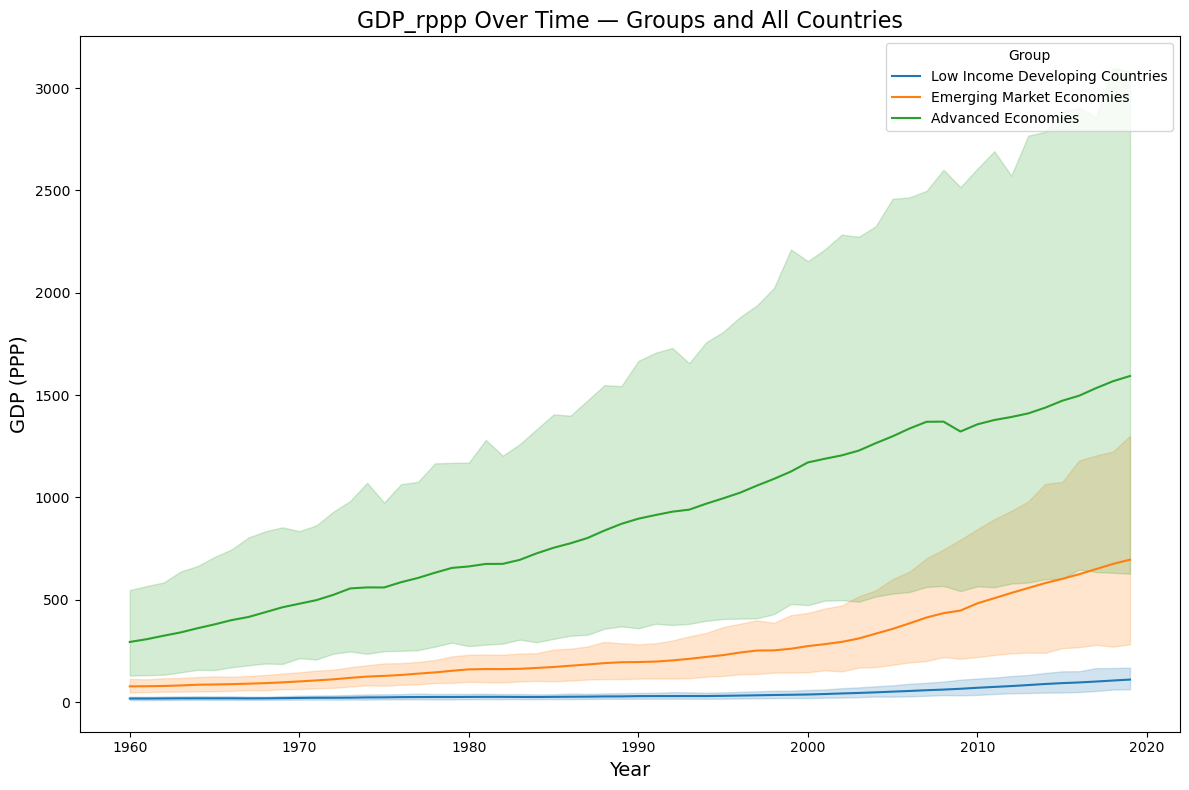

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

for group, group_df in panel_1_groups.items():
    df = group_df.reset_index()
    sns.lineplot(data=df, x='year', y='GDP_rppp', ax=ax, label=f'{group}')

ax.set_title('GDP_rppp Over Time — Groups and All Countries', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('GDP (PPP)', fontsize=14)
ax.legend(title='Group')
fig.tight_layout()
plt.show()


The graph shows the GDP (PPP) trends over time for different income groups.
Each line represents the average GDP (PPP) for an income group, while the shaded area around each line reflects the distribution of countries within the group.
There is a clear distinction between Low Income Developing Countries and Emerging Market Economies.
However, after around 2005, some countries in the Emerging Market Economies group overtook some countries in the Advanced Economies group in terms of GDP (PPP).



In this step, we plot log(GDP) trends over time by income group to normalize differences in scale and highlight relative growth dynamics between groups.


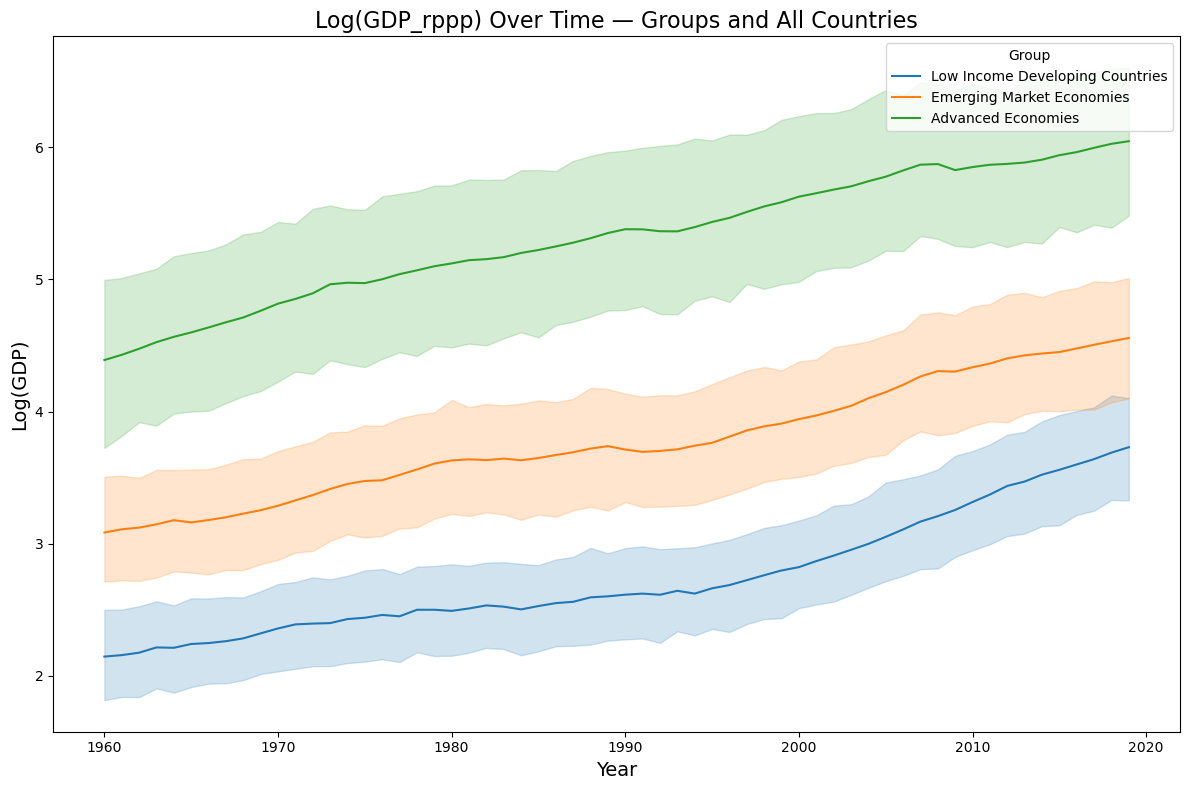

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

for group, group_df in panel_1_groups.items():
    df = group_df.reset_index()
    sns.lineplot(data=df, x='year', y=np.log1p(df['GDP_rppp']), ax=ax, label=f'{group}')

ax.set_title('Log(GDP_rppp) Over Time — Groups and All Countries', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Log(GDP)', fontsize=14)
ax.legend(title='Group')
fig.tight_layout()

plt.show()


The graph shows the log-transformed GDP (PPP) trends over time for different income groups.
Each line represents the average log(GDP) for a group, while the shaded area captures the spread of countries within each group.
The gap between groups remains clearly visible, but the log scale compresses differences and better highlights the consistent growth patterns across all groups, especially after 2000.

Now, We define a function to train either a Linear Regression or Random Forest model on the prepared dataset, scale features, split into training and test sets, and evaluate performance using MSE and R² metrics.


In [44]:
def train_test_models(df, feature_cols, target='GDP_rppp', model_type='linear'):
    X = df[feature_cols]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if model_type == 'linear':
        model = LinearRegression()
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_type.capitalize()} Model Test Results:")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}\n")

    return model, X_train_scaled, y_train

We create a function to apply a log(1+x) transformation to selected features and optionally the target variable, helping to stabilize variance and improve model performance.


In [45]:
def log_transform_features(df, features_to_log, target_to_log=None):
    df_transformed = df.copy()
    df_transformed = df_transformed[(df_transformed[features_to_log] >= 0).all(axis=1)]
    for col in features_to_log:
        df_transformed[f'log_{col}'] = np.log1p(df_transformed[col].fillna(0))
    if target_to_log:
        df_transformed[f'log_{target_to_log}'] = np.log1p(df_transformed[target_to_log].fillna(0))
    return df_transformed

We create a function to perform time-series cross-validation, training and evaluating models across multiple sequential folds using MSE and R² as performance metrics.


In [46]:
def cross_validate_models(model, X, y, cv_type='timeseries', n_splits=5):
    
    if cv_type == 'timeseries':
        cv = TimeSeriesSplit(n_splits=n_splits)
    else:
        raise ValueError("Only 'timeseries' is supported in this version.")
    
    if isinstance(y, pd.Series):
        if not (y.index.is_monotonic_increasing and (y.index == np.arange(len(y))).all()):
            y = y.reset_index(drop=True)
    
    mse_scores = []
    r2_scores = []
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        else:
            X_tr, X_te = X[train_idx], X[test_idx]
        
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        
        mse = mean_squared_error(y_te, y_pred)
        r2 = r2_score(y_te, y_pred)
        
        print(f"Fold {i+1}: MSE={mse:.4f}, R²={r2:.4f}")
        mse_scores.append(mse)
        r2_scores.append(r2)
    
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"\nAverage MSE: {avg_mse:.4f}")
    print(f"Average R² : {avg_r2:.4f}\n")
    
    return avg_mse, avg_r2


We create a utility function to display feature importances for models that support it, helping to interpret which variables contribute most to the model's predictions.


In [47]:
def print_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = pd.Series(model.feature_importances_, index=feature_names)
        importance = importance.sort_values(ascending=False)
        print("\nFeature Importances:")
        print(importance)
    else:
        print("Model does not support feature importances.")

We create a function to visualize residuals through scatter plots and distribution plots, helping to assess model fit, detect patterns, and check assumptions of homoscedasticity.


In [48]:
def plot_residuals(y_true, y_pred, model_label="Model"):
    resid = y_true - y_pred

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  
    axs[0].scatter(y_pred, resid, alpha=0.6)
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_title(f'Residuals Scatter - {model_label}')
    axs[0].set_xlabel('Predicted Values')
    axs[0].set_ylabel('Residuals')
    axs[0].grid(True)

    sns.histplot(resid, kde=True, color='blue', bins=20, ax=axs[1])
    axs[1].set_title(f'Distribution of Residuals - {model_label}')
    axs[1].set_xlabel('Residuals')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

We define an improved function that builds a machine learning pipeline with imputation, scaling, and modeling steps, trains either a Linear Regression or Random Forest model, and evaluates performance using MSE and R² on a time-consistent train-test split.


In [49]:
def train_test_models(
    df,
    feature_cols,
    target='GDP_rppp',
    model_type='linear',
    test_size=0.2,
    random_state=42
):

    X = df[feature_cols]
    y = df[target]
    mask = y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        shuffle=False,
        random_state=random_state
    )

    steps = [
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
    if model_type == 'linear':
        steps.append(('model', LinearRegression()))
    else:
        steps.append((
            'model',
            RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
        ))
    pipeline = Pipeline(steps)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    print(f"{model_type.title()} Model Test Results:")
    print(f" → Test MSE: {mse:.4f}")
    print(f" → Test R² : {r2:.4f}\n")

    return pipeline, X_train, y_train


We create a comprehensive evaluation function that trains both Linear Regression and Random Forest models on raw and log-transformed features, performs cross-validation, plots residuals, extracts feature importances, and summarizes model performance for each dataset.


In [50]:
def evaluate_dataset(
    df,
    dataset_label: str,
    features: list,
    features_to_log: list,
    target: str = 'GDP_rppp',
    is_panel: bool = False,
      min_log_rows: int = 2 
):

    results = []

    log_features = [f'log_{c}' for c in features]
    
    print(f"\n{dataset_label}-No Log Models ")
    model_lr, X_train_lr, y_train_lr = train_test_models(df, features, target, 'linear')
    mse_lr, r2_lr = cross_validate_models(model_lr, X_train_lr, y_train_lr)
    plot_residuals(y_train_lr, model_lr.predict(X_train_lr),
                   model_label=f"Linear (No Log, {dataset_label})")
    results.append({
        'Dataset': dataset_label,
        'Model': 'Linear (No Log)',
        'MSE': mse_lr,
        'R2': r2_lr
    })
    model_rf, X_train_rf, y_train_rf = train_test_models(df, features, target, 'randomforest')
    mse_rf, r2_rf = cross_validate_models(model_rf, X_train_rf, y_train_rf)
    print_feature_importance(model_rf, features)
    plot_residuals(y_train_rf, model_rf.predict(X_train_rf),
                   model_label=f"Random Forest (No Log, {dataset_label})")
    results.append({
        'Dataset': dataset_label,
        'Model': 'Random Forest (No Log)',
        'MSE': mse_rf,
        'R2': r2_rf
    })
    
    
    print(f"\n{dataset_label}-Log Models")
    df_log = log_transform_features(df, features_to_log=features, target_to_log=target)
    
    if df_log.shape[0] < min_log_rows:
        print(f"Skipping Log Models for {dataset_label}: only {df_log.shape[0]} rows after log → need ≥ {min_log_rows}.")
    else:
        model_lr_log, X_lr_log, y_lr_log = train_test_models(
            df_log, log_features, target=f'log_{target}', model_type='linear'
        )
        mse_lr_log, r2_lr_log = cross_validate_models(model_lr_log, X_lr_log, y_lr_log)
        plot_residuals(y_lr_log, model_lr_log.predict(X_lr_log),
                       model_label=f"Linear (Log, {dataset_label})")
        results.append({
            'Dataset': dataset_label,
            'Model': 'Linear (Log)',
            'MSE': mse_lr_log,
            'R2': r2_lr_log
        })
        
        model_rf_log, X_rf_log, y_rf_log = train_test_models(
            df_log, log_features, target=f'log_{target}', model_type='randomforest'
        )
        mse_rf_log, r2_rf_log = cross_validate_models(model_rf_log, X_rf_log, y_rf_log)
        print_feature_importance(model_rf_log, log_features)
        plot_residuals(y_rf_log, model_rf_log.predict(X_rf_log),
                       model_label=f"RF (Log, {dataset_label})")
        results.append({
            'Dataset': dataset_label,
            'Model': 'Random Forest (Log)',
            'MSE': mse_rf_log,
            'R2': r2_rf_log
        })
        
    return results


We loop through all predefined feature sets, applying the evaluation pipeline to the full dataset, and collect performance results for both raw and log-transformed models.



Full – set1-No Log Models 
Linear Model Test Results:
 → Test MSE: 750051.4654
 → Test R² : 0.8359

Fold 1: MSE=160606.4430, R²=0.9352
Fold 2: MSE=64660.2085, R²=0.8833
Fold 3: MSE=107730.9505, R²=0.9163
Fold 4: MSE=6177.9166, R²=0.9351
Fold 5: MSE=10978.8247, R²=0.8093

Average MSE: 70030.8687
Average R² : 0.8958



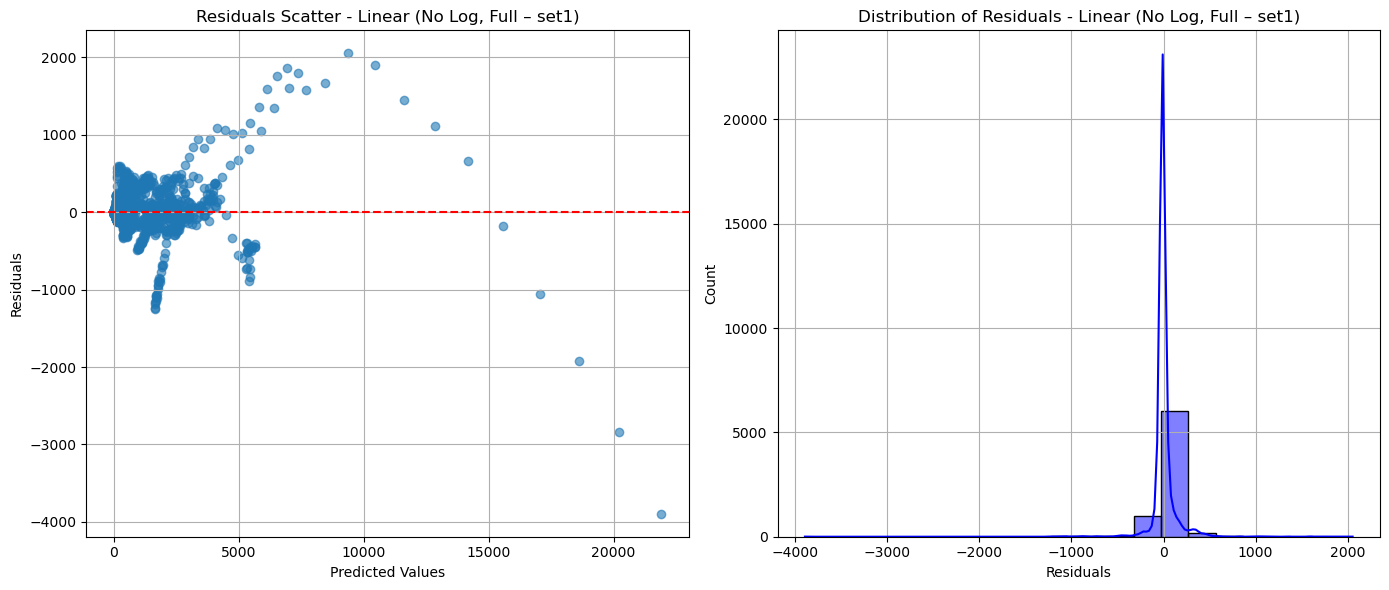

Randomforest Model Test Results:
 → Test MSE: 1599146.1277
 → Test R² : 0.6500

Fold 1: MSE=2046969.6200, R²=0.1745
Fold 2: MSE=68421.7404, R²=0.8765
Fold 3: MSE=150930.2150, R²=0.8828
Fold 4: MSE=12479.9609, R²=0.8689
Fold 5: MSE=10869.2168, R²=0.8112

Average MSE: 457934.1506
Average R² : 0.7228

Model does not support feature importances.


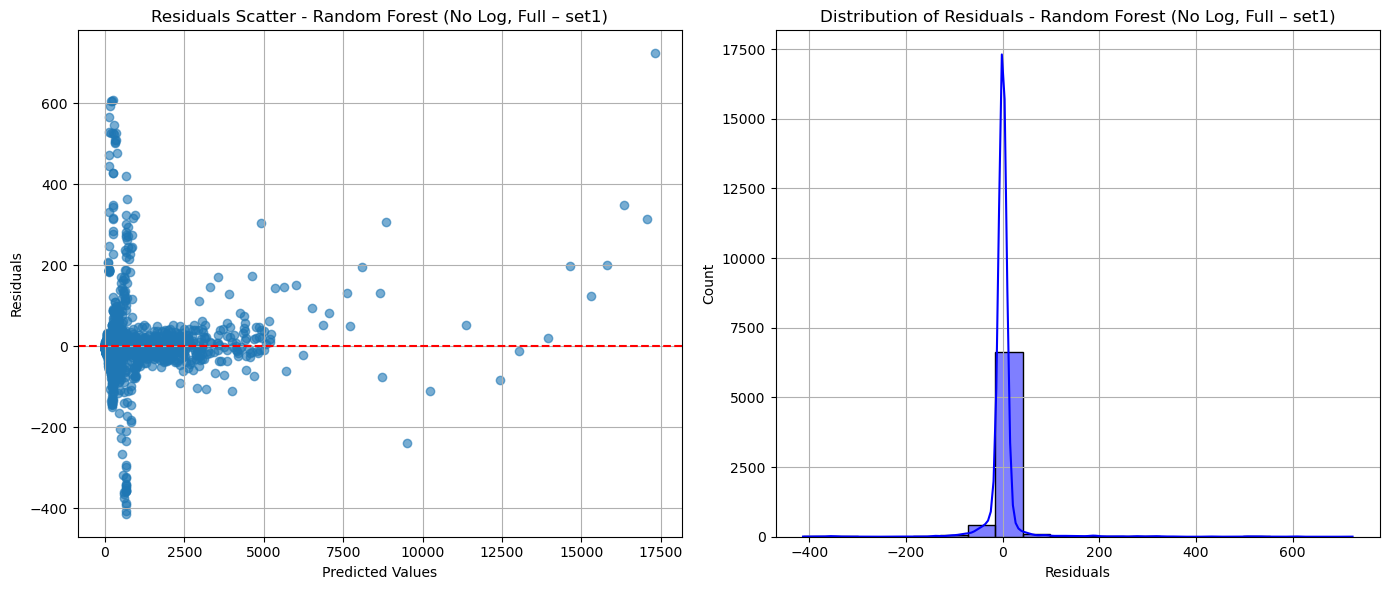


Full – set1-Log Models
Linear Model Test Results:
 → Test MSE: 0.1393
 → Test R² : 0.9649

Fold 1: MSE=0.1453, R²=0.9672
Fold 2: MSE=0.1147, R²=0.9700
Fold 3: MSE=0.1711, R²=0.9622
Fold 4: MSE=0.2027, R²=0.9135
Fold 5: MSE=0.0652, R²=0.9692

Average MSE: 0.1398
Average R² : 0.9564



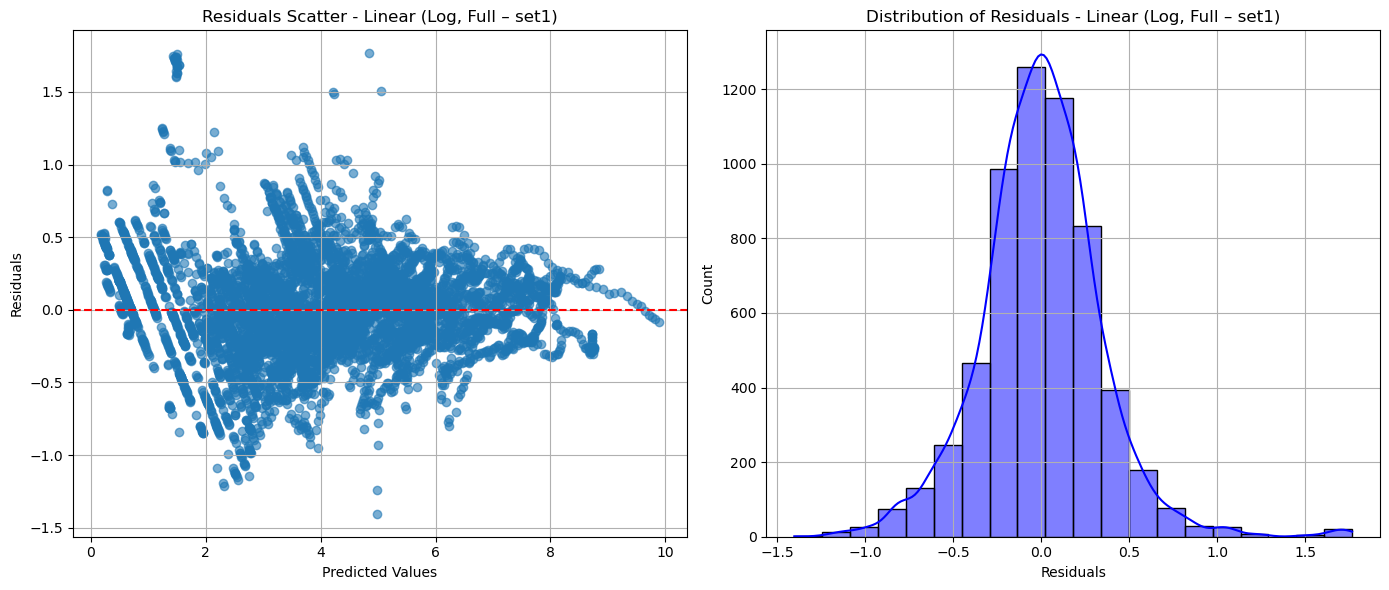

Randomforest Model Test Results:
 → Test MSE: 0.2110
 → Test R² : 0.9468

Fold 1: MSE=0.5665, R²=0.8722
Fold 2: MSE=0.2097, R²=0.9452
Fold 3: MSE=0.1968, R²=0.9565
Fold 4: MSE=0.1990, R²=0.9151
Fold 5: MSE=0.1013, R²=0.9521

Average MSE: 0.2547
Average R² : 0.9282

Model does not support feature importances.


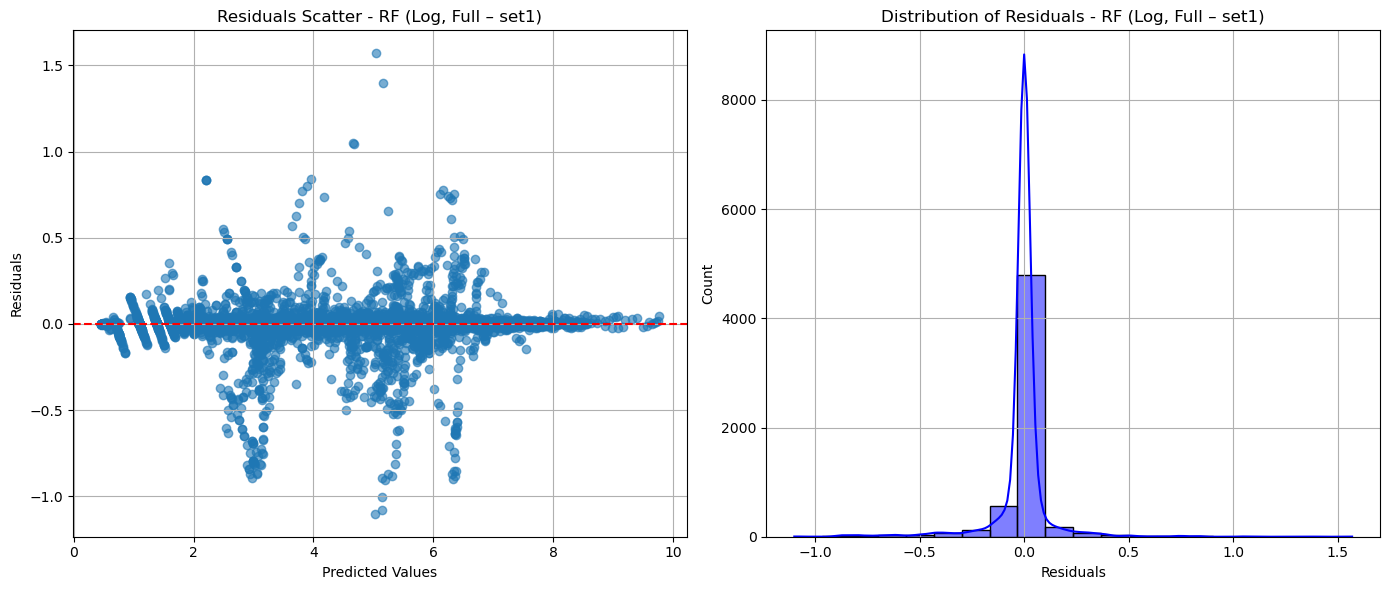


Full – set2-No Log Models 
Linear Model Test Results:
 → Test MSE: 753980.5064
 → Test R² : 0.8350

Fold 1: MSE=131797.6449, R²=0.9469
Fold 2: MSE=71844.4771, R²=0.8703
Fold 3: MSE=104954.3501, R²=0.9185
Fold 4: MSE=6248.6792, R²=0.9343
Fold 5: MSE=11822.9599, R²=0.7947

Average MSE: 65333.6222
Average R² : 0.8929



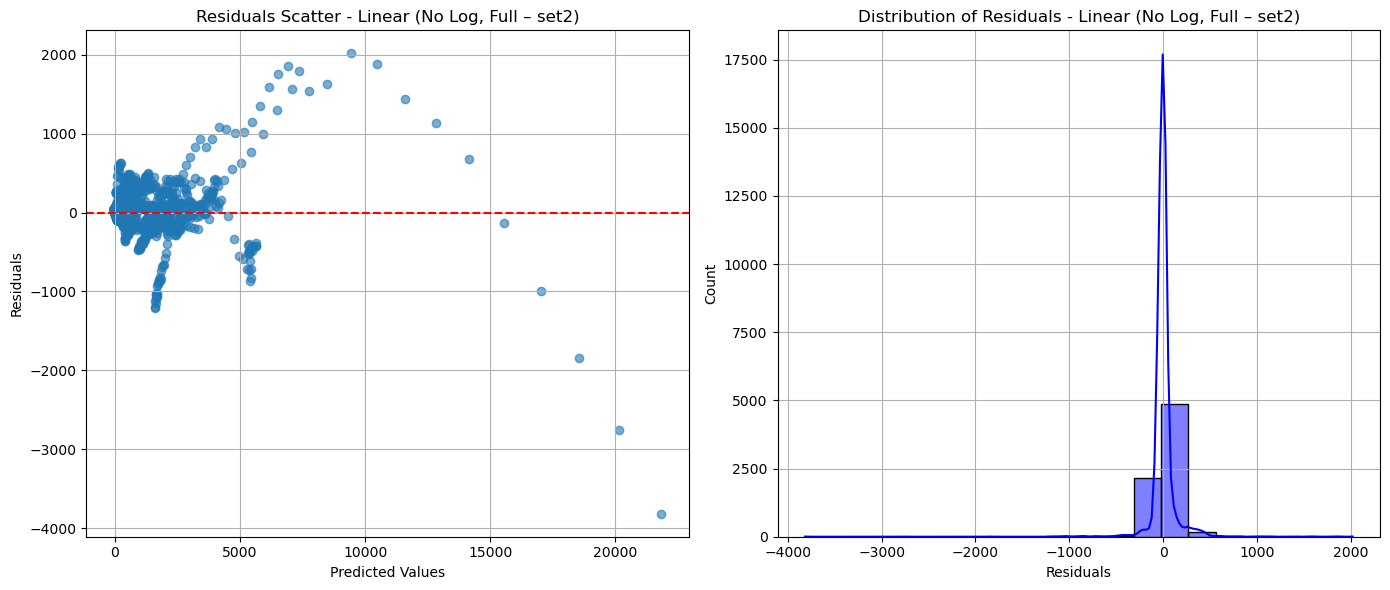

Randomforest Model Test Results:
 → Test MSE: 1195503.3932
 → Test R² : 0.7384

Fold 1: MSE=2029340.5063, R²=0.1817
Fold 2: MSE=81304.2206, R²=0.8533
Fold 3: MSE=139391.1381, R²=0.8917
Fold 4: MSE=12274.6279, R²=0.8710
Fold 5: MSE=11743.2839, R²=0.7960

Average MSE: 454810.7554
Average R² : 0.7187

Model does not support feature importances.


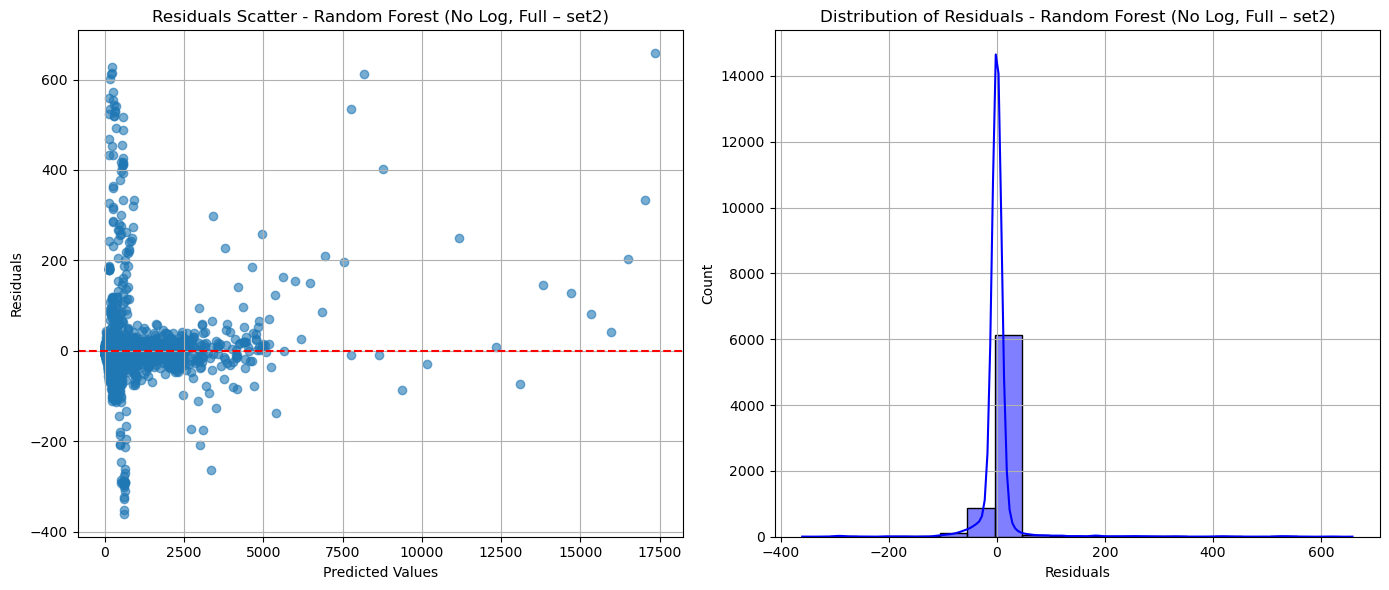


Full – set2-Log Models
Linear Model Test Results:
 → Test MSE: 0.0646
 → Test R² : 0.9734

Fold 1: MSE=0.0867, R²=0.9642
Fold 2: MSE=0.0935, R²=0.9639
Fold 3: MSE=0.1335, R²=0.9678
Fold 4: MSE=0.1874, R²=0.8830
Fold 5: MSE=0.0390, R²=0.9374

Average MSE: 0.1080
Average R² : 0.9433



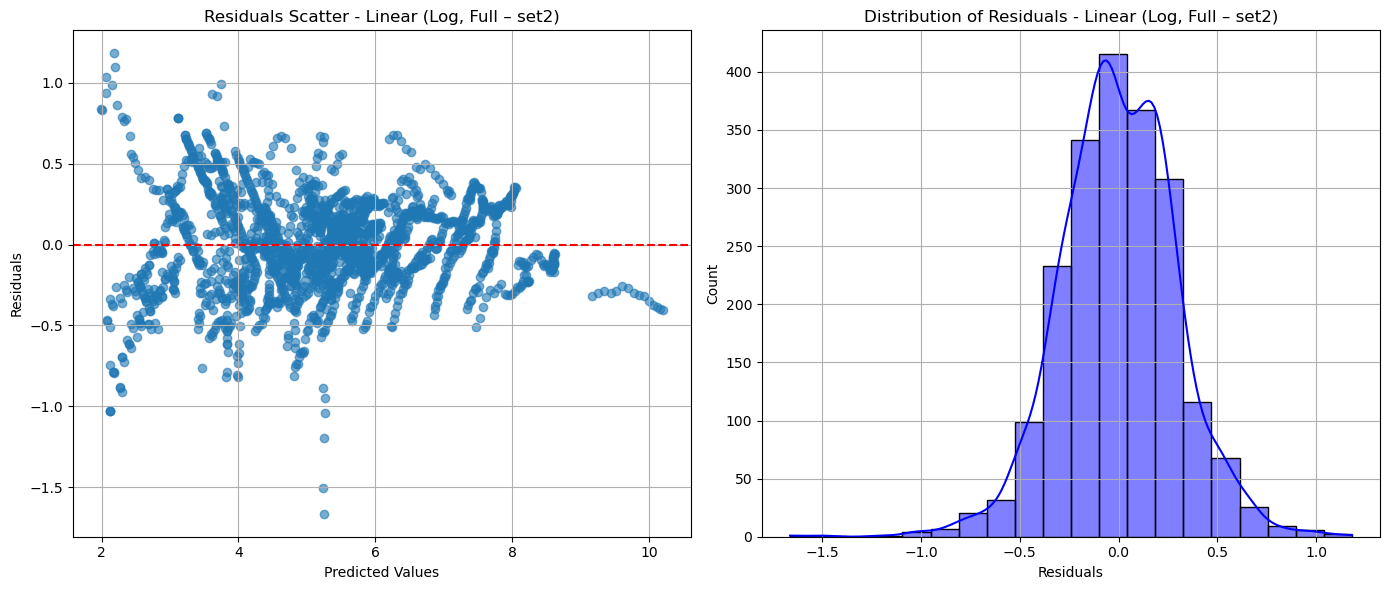

Randomforest Model Test Results:
 → Test MSE: 0.1119
 → Test R² : 0.9539

Fold 1: MSE=0.3377, R²=0.8607
Fold 2: MSE=0.1333, R²=0.9485
Fold 3: MSE=0.3716, R²=0.9103
Fold 4: MSE=0.1797, R²=0.8878
Fold 5: MSE=0.0634, R²=0.8983

Average MSE: 0.2171
Average R² : 0.9011

Model does not support feature importances.


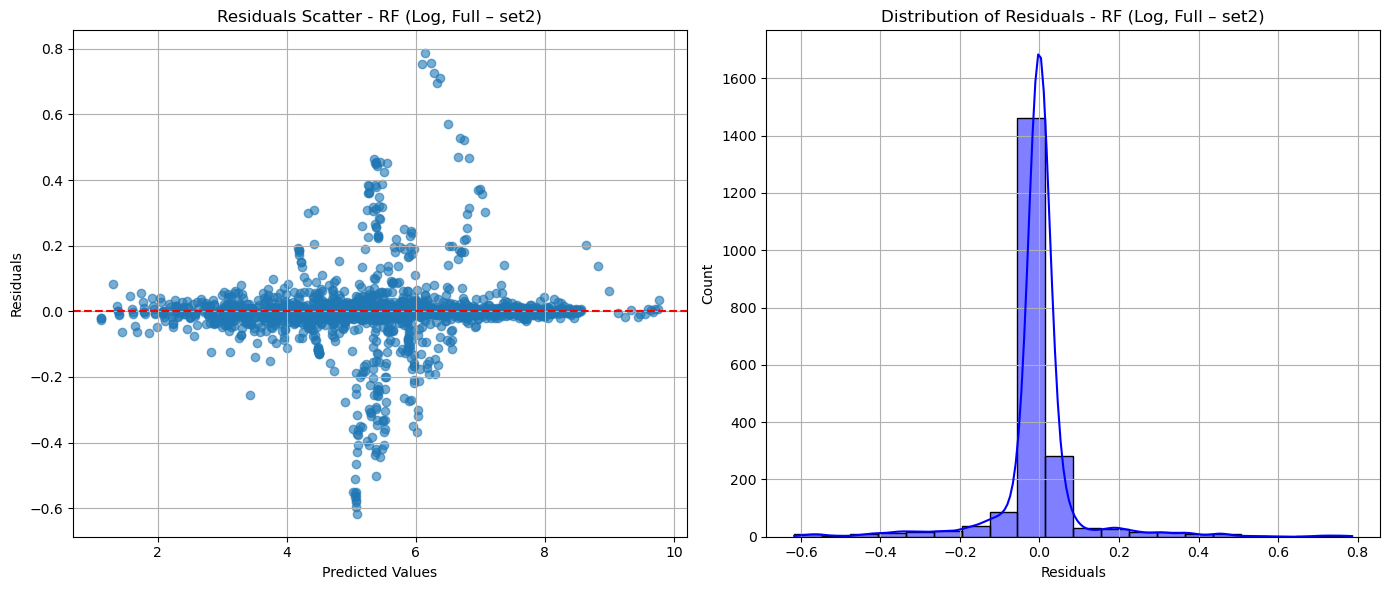


Full – set3-No Log Models 
Linear Model Test Results:
 → Test MSE: 766769.4364
 → Test R² : 0.8322

Fold 1: MSE=173843.8881, R²=0.9299
Fold 2: MSE=71597.0338, R²=0.8708
Fold 3: MSE=112149.3611, R²=0.9129
Fold 4: MSE=5889.9522, R²=0.9381
Fold 5: MSE=12127.1876, R²=0.7894

Average MSE: 75121.4846
Average R² : 0.8882



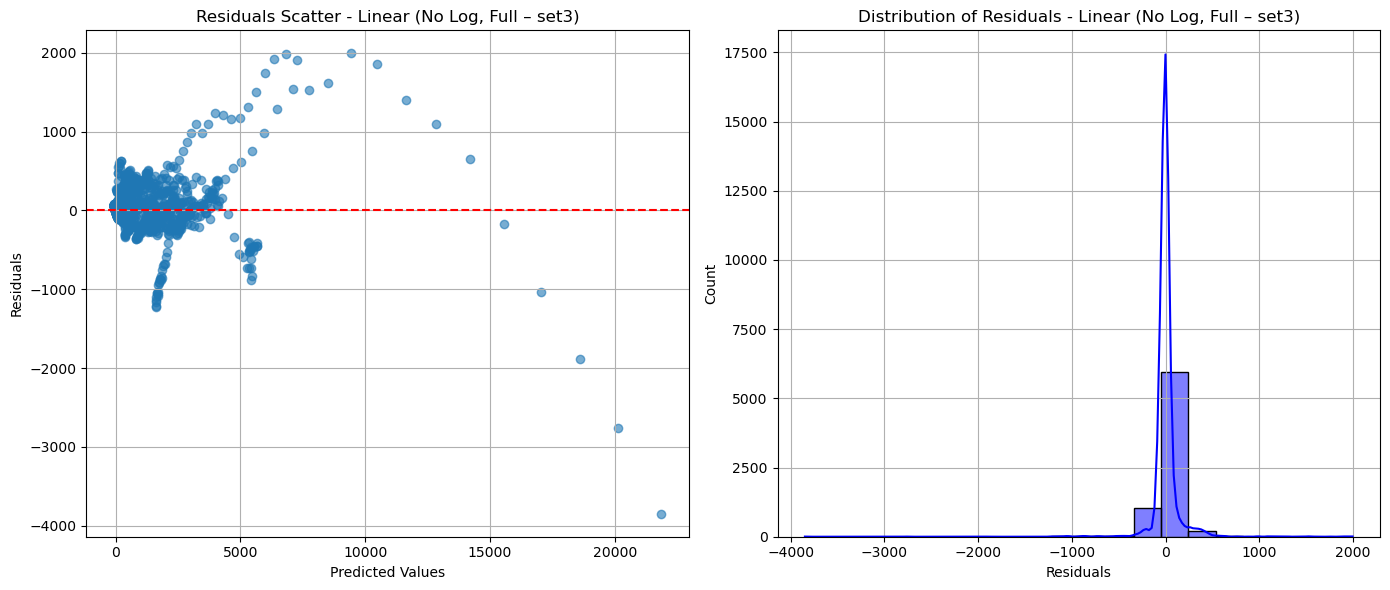

Randomforest Model Test Results:
 → Test MSE: 1191439.1400
 → Test R² : 0.7393

Fold 1: MSE=2050329.4005, R²=0.1732
Fold 2: MSE=79652.1193, R²=0.8562
Fold 3: MSE=140050.8683, R²=0.8912
Fold 4: MSE=11729.4543, R²=0.8767
Fold 5: MSE=11948.5041, R²=0.7925

Average MSE: 458742.0693
Average R² : 0.7180

Model does not support feature importances.


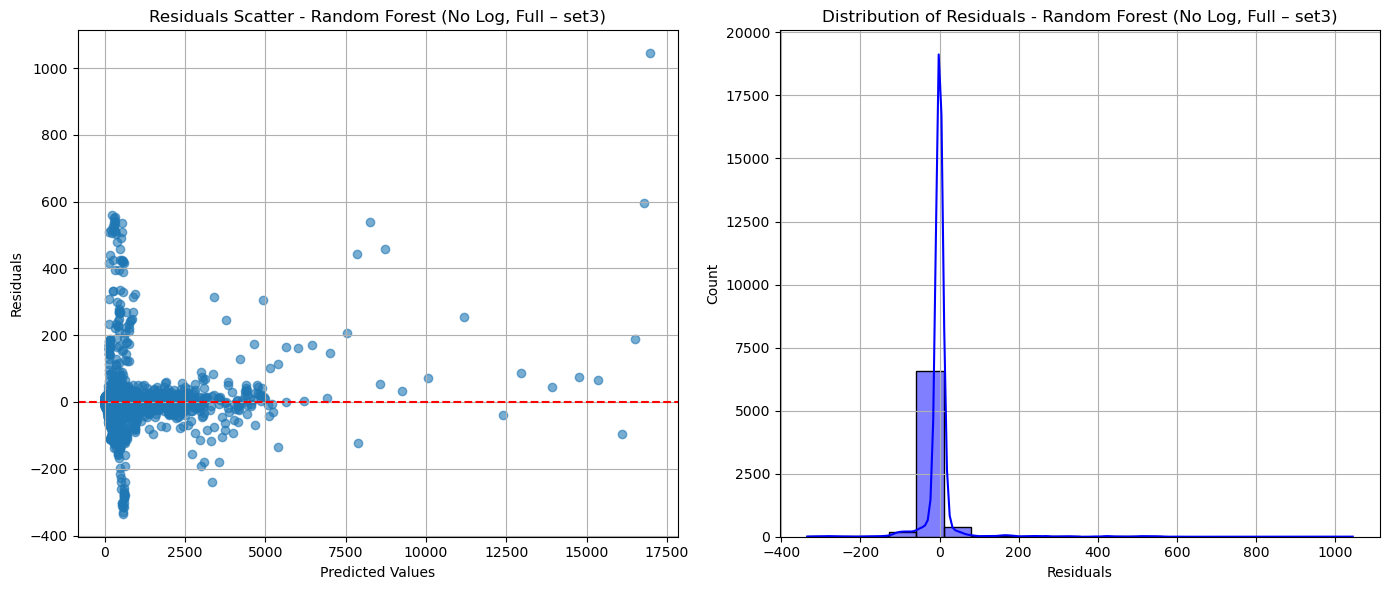


Full – set3-Log Models
Linear Model Test Results:
 → Test MSE: 0.0971
 → Test R² : 0.9166

Fold 1: MSE=1.1288, R²=-0.5446
Fold 2: MSE=0.0488, R²=0.8244
Fold 3: MSE=0.0146, R²=0.8927
Fold 4: MSE=0.0756, R²=0.8959
Fold 5: MSE=0.1460, R²=0.2594

Average MSE: 0.2828
Average R² : 0.4656



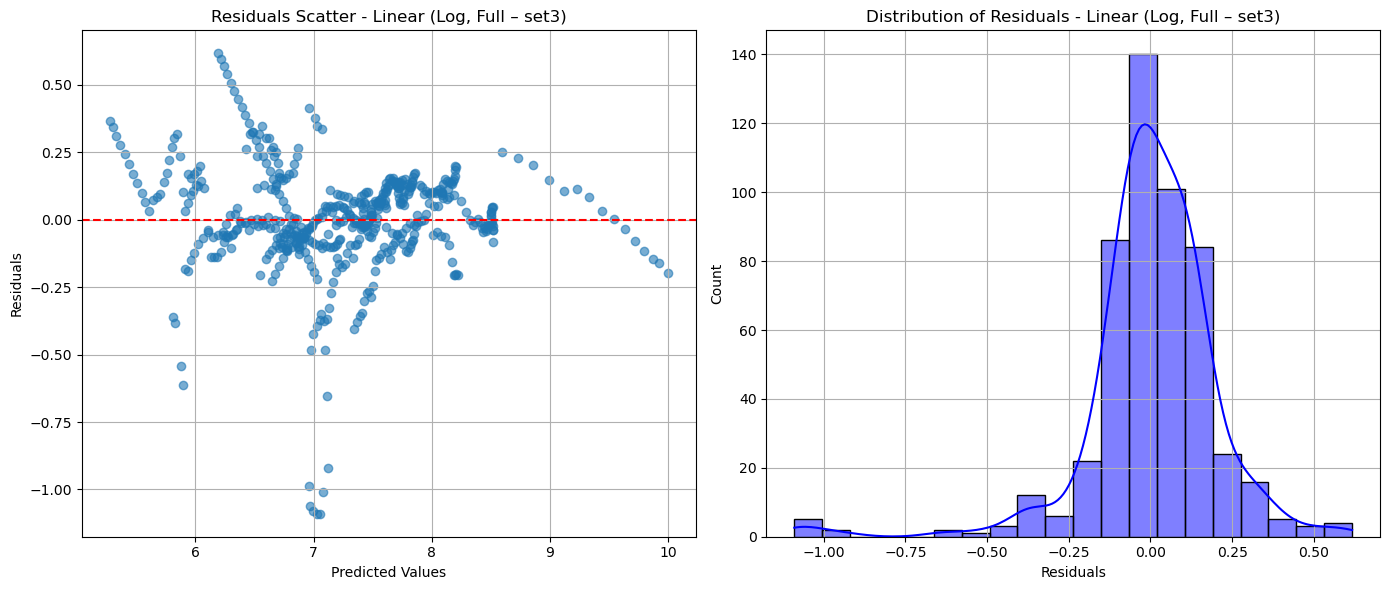

Randomforest Model Test Results:
 → Test MSE: 0.2504
 → Test R² : 0.7850

Fold 1: MSE=0.8388, R²=-0.1477
Fold 2: MSE=0.0501, R²=0.8201
Fold 3: MSE=0.0849, R²=0.3738
Fold 4: MSE=0.0291, R²=0.9599
Fold 5: MSE=0.1504, R²=0.2375

Average MSE: 0.2306
Average R² : 0.4487

Model does not support feature importances.


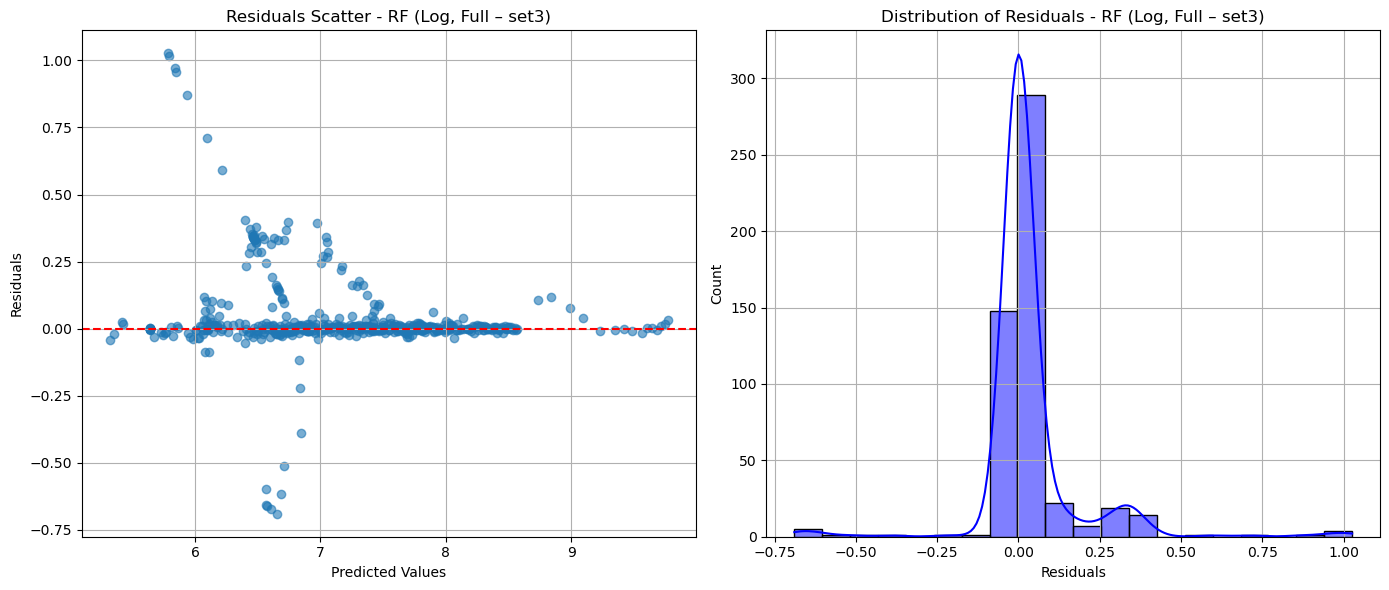


Full – set4-No Log Models 
Linear Model Test Results:
 → Test MSE: 58567.1778
 → Test R² : 0.9872

Fold 1: MSE=208469.8660, R²=0.9159
Fold 2: MSE=34624.5609, R²=0.9375
Fold 3: MSE=253628.3580, R²=0.8030
Fold 4: MSE=16614.2531, R²=0.8254
Fold 5: MSE=17706.2660, R²=0.6925

Average MSE: 106208.6608
Average R² : 0.8349



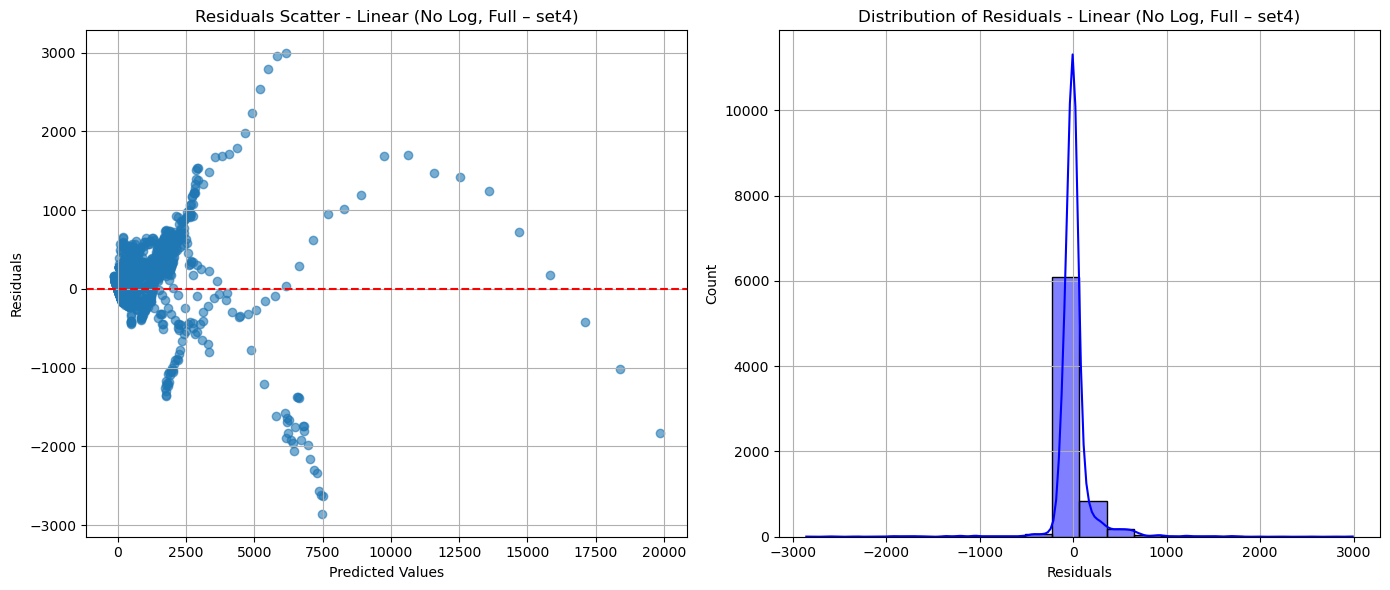

Randomforest Model Test Results:
 → Test MSE: 963243.8428
 → Test R² : 0.7892

Fold 1: MSE=2026843.6698, R²=0.1827
Fold 2: MSE=101578.2594, R²=0.8167
Fold 3: MSE=558180.2127, R²=0.5664
Fold 4: MSE=8865.4212, R²=0.9068
Fold 5: MSE=12419.3445, R²=0.7843

Average MSE: 541577.3815
Average R² : 0.6514

Model does not support feature importances.


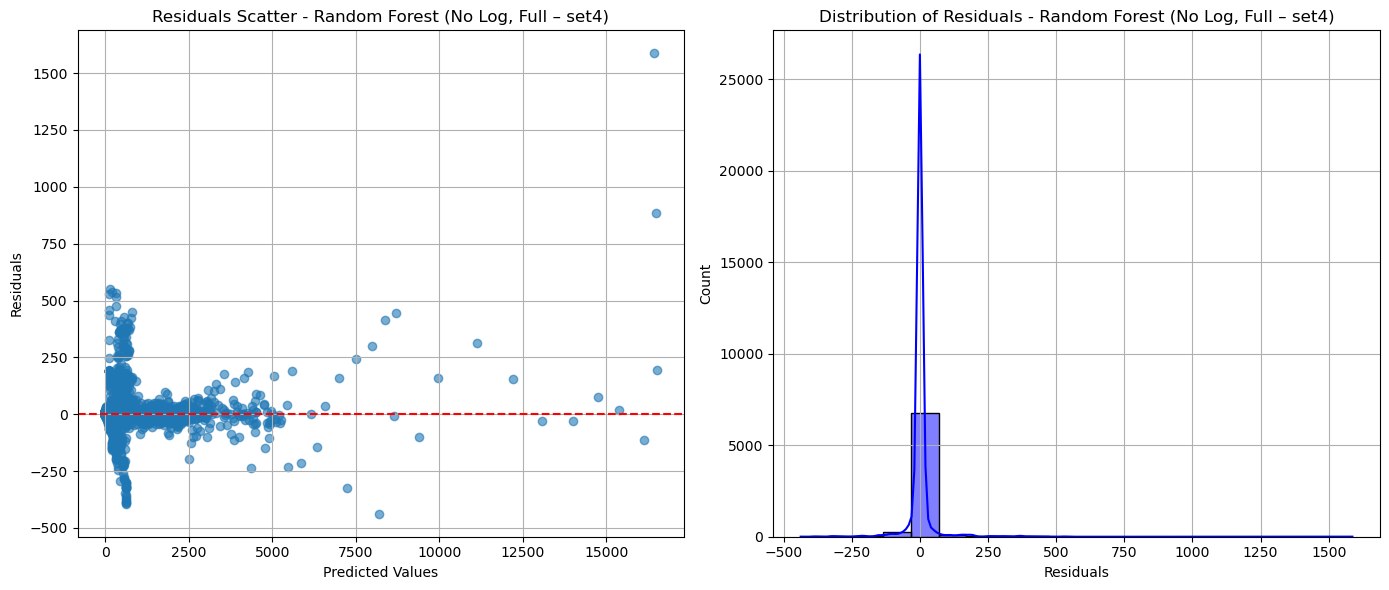


Full – set4-Log Models
Linear Model Test Results:
 → Test MSE: 0.0568
 → Test R² : 0.9401

Fold 1: MSE=0.2835, R²=0.6466
Fold 2: MSE=0.0716, R²=0.6118
Fold 3: MSE=0.0565, R²=0.6476
Fold 4: MSE=0.1141, R²=0.8617
Fold 5: MSE=0.1768, R²=0.0805

Average MSE: 0.1405
Average R² : 0.5696



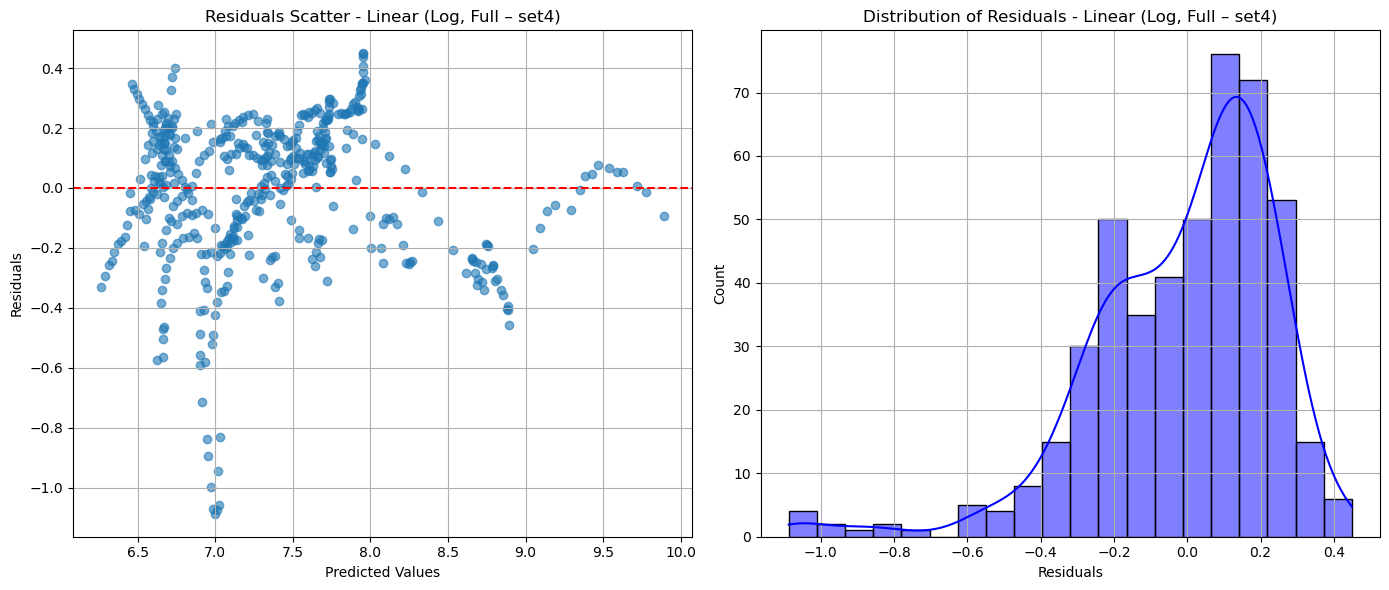

Randomforest Model Test Results:
 → Test MSE: 0.3552
 → Test R² : 0.6257

Fold 1: MSE=1.3140, R²=-0.6381
Fold 2: MSE=0.0799, R²=0.5667
Fold 3: MSE=0.0321, R²=0.7998
Fold 4: MSE=0.0680, R²=0.9176
Fold 5: MSE=0.1951, R²=-0.0147

Average MSE: 0.3378
Average R² : 0.3263

Model does not support feature importances.


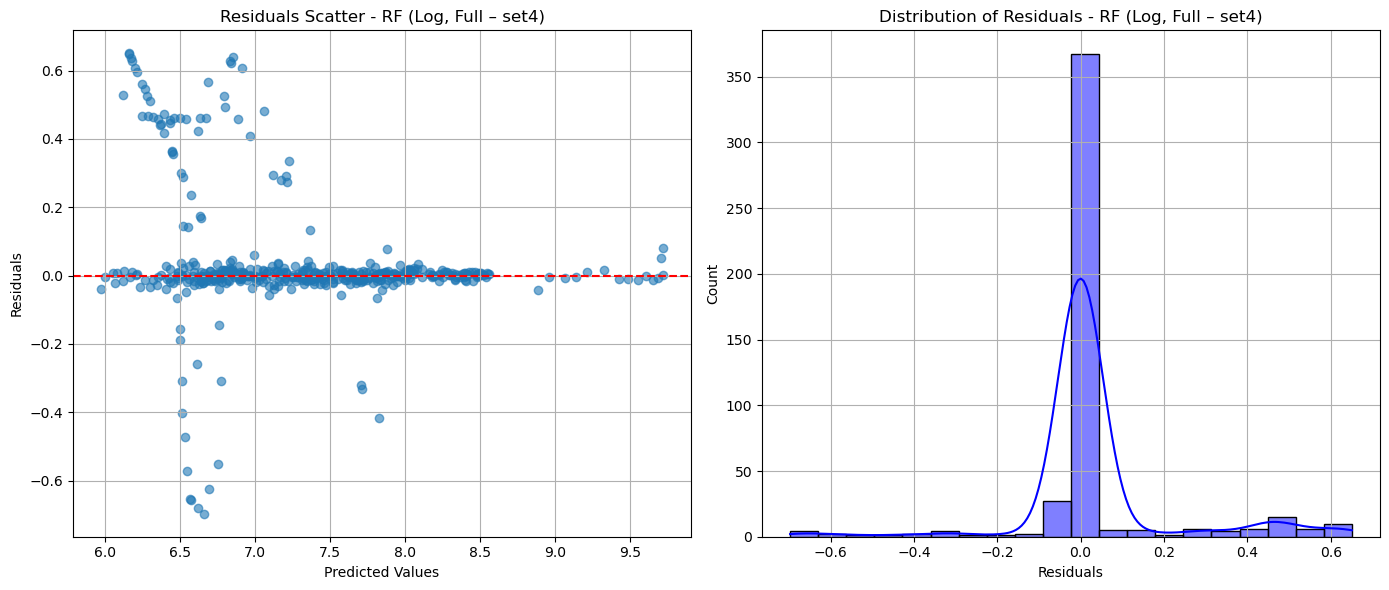

In [51]:
all_results = []

for set_name, feat in features_sets.items():
    all_results += evaluate_dataset(
        panel_2.reset_index(),      
        dataset_label=f"Full – {set_name}",
        features=feat,
        features_to_log=feat,
        is_panel=True
    )


For Set 1,
Without log transformation, the linear model performed better than Random Forest, achieving a higher Test R² (0.8359 vs. 0.6373). After applying log transformation, both models improved significantly — the linear model achieved excellent performance (Test R² = 0.9649), and Random Forest also improved (Test R² = 0.9469), showing that log transformation stabilized variance and greatly enhanced predictive accuracy.

For Set 2,
Before log transformation, the Random Forest model had moderate performance (Test R² = 0.7364), showing instability across folds. After applying log transformation, the model's performance improved significantly (Test R² = 0.9540), with much more consistent and stronger results across folds, confirming that log transformation helped stabilize variance and enhance predictive accuracy.

For  Set 3, 
Without log transformation, the linear model performed reasonably well (Test R² = 0.8322), and Random Forest was slightly weaker (Test R² = 0.7405). However, after log transformation, both models showed instability with very poor R² scores, especially for the linear model (average R² = 0.4656) and Random Forest (average R² = 0.4487), indicating that for this feature set, log transformation actually hurt the model performance instead of improving it.

For Set 4, 
Without log transformation, the linear model performed extremely well (Test R² = 0.9872) while Random Forest performed moderately (Test R² = 0.7891). However, after log transformation, both models' performances dropped significantly — the linear model’s Test R² fell to 0.9401 and Random Forest to 0.6257, with inconsistent and poor fold results, showing that log transformation was harmful for this feature set.

We apply the evaluation pipeline across each income group and feature set combination, allowing detailed comparison of model performance within different economic segments.



Low Income Developing Countries – set1-No Log Models 
Linear Model Test Results:
 → Test MSE: 3850.7509
 → Test R² : 0.4881

Fold 1: MSE=26.0958, R²=0.9198
Fold 2: MSE=217.0184, R²=0.8427
Fold 3: MSE=166.5287, R²=0.8686
Fold 4: MSE=259.8709, R²=0.8281
Fold 5: MSE=7787.5343, R²=0.7562

Average MSE: 1691.4096
Average R² : 0.8431



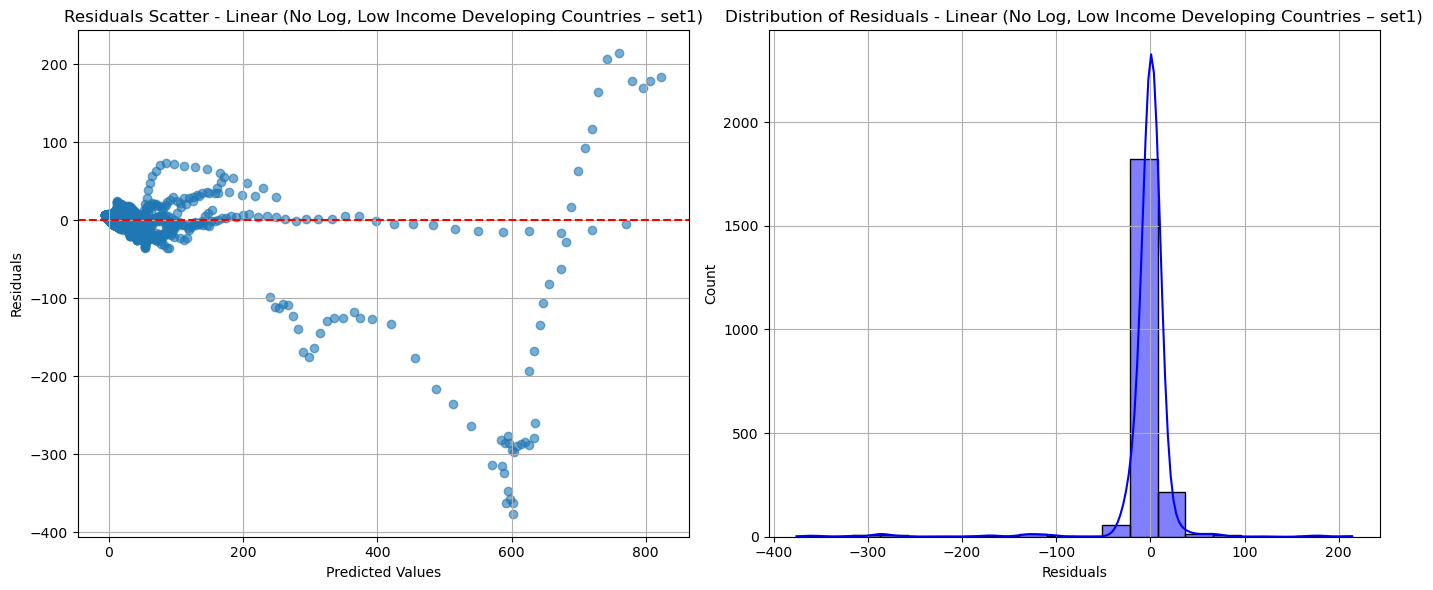

Randomforest Model Test Results:
 → Test MSE: 2499.3259
 → Test R² : 0.6678

Fold 1: MSE=87.4890, R²=0.7310
Fold 2: MSE=696.1010, R²=0.4956
Fold 3: MSE=158.9817, R²=0.8746
Fold 4: MSE=296.3507, R²=0.8040
Fold 5: MSE=5838.3814, R²=0.8172

Average MSE: 1415.4608
Average R² : 0.7445

Model does not support feature importances.


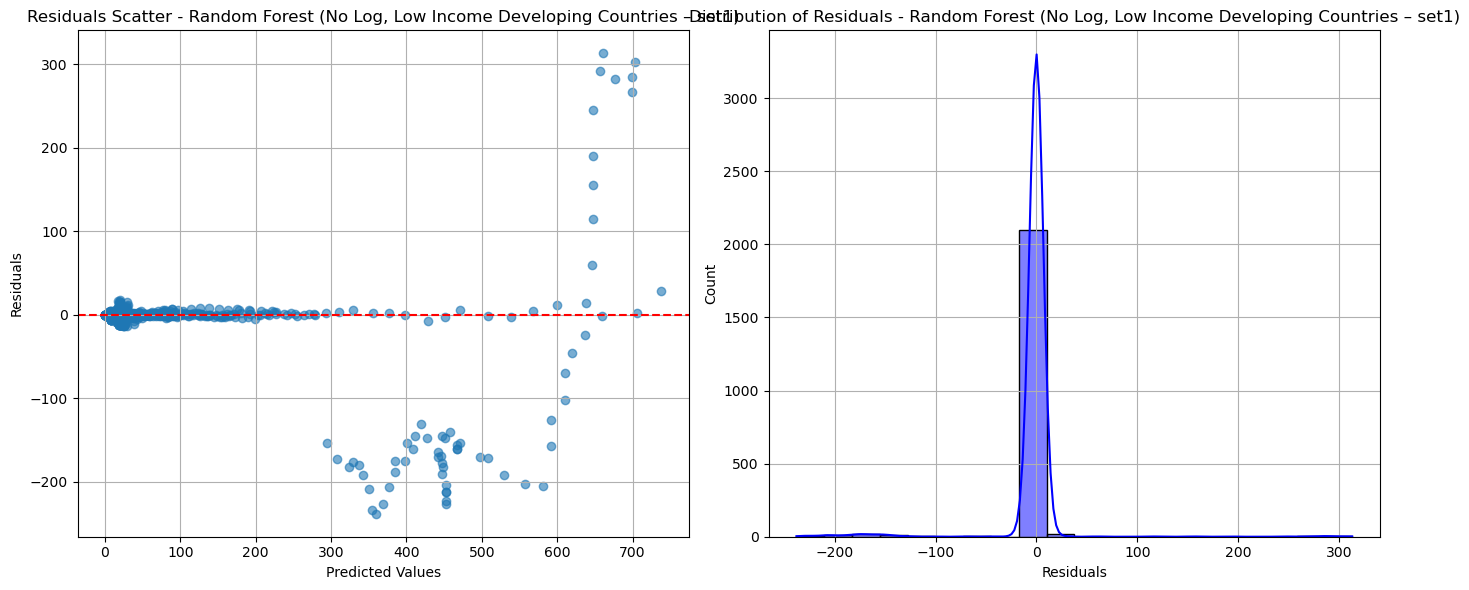


Low Income Developing Countries – set1-Log Models
Linear Model Test Results:
 → Test MSE: 0.3958
 → Test R² : 0.6572

Fold 1: MSE=0.7663, R²=0.4838
Fold 2: MSE=0.2001, R²=0.8898
Fold 3: MSE=0.3476, R²=0.7592
Fold 4: MSE=0.1246, R²=0.8390
Fold 5: MSE=0.2258, R²=0.8969

Average MSE: 0.3329
Average R² : 0.7737



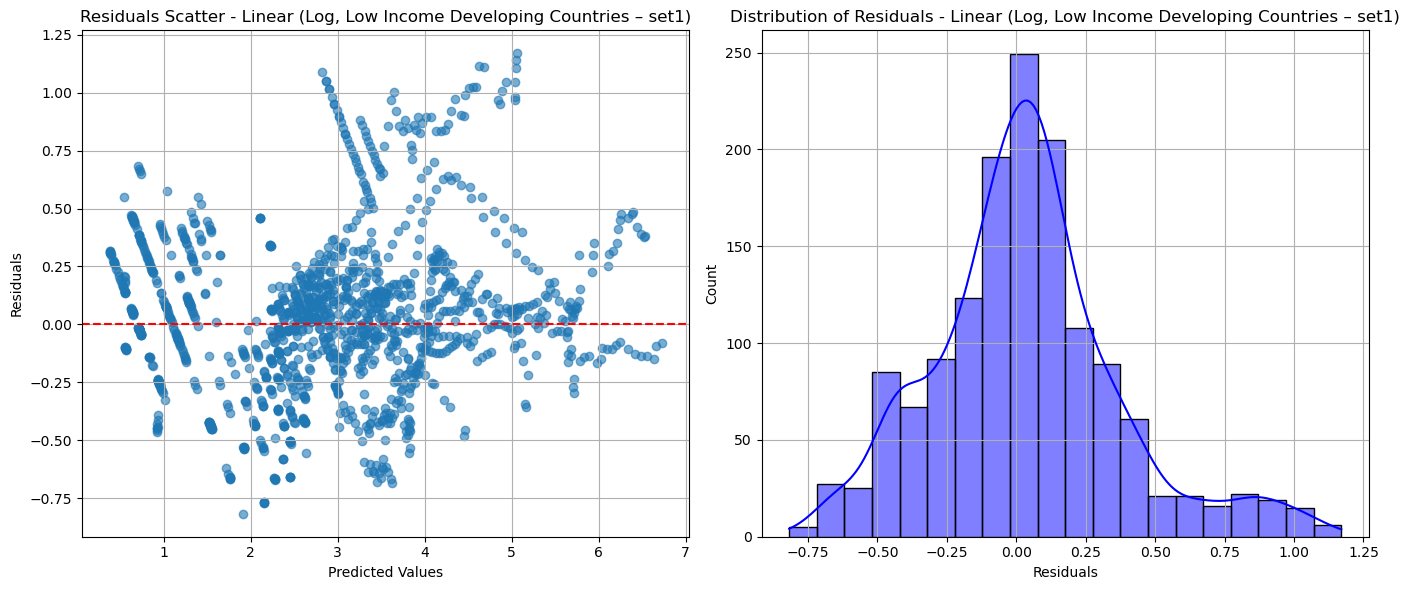

Randomforest Model Test Results:
 → Test MSE: 0.5221
 → Test R² : 0.5479

Fold 1: MSE=0.1181, R²=0.9204
Fold 2: MSE=0.1755, R²=0.9034
Fold 3: MSE=0.8148, R²=0.4357
Fold 4: MSE=0.2609, R²=0.6629
Fold 5: MSE=0.2167, R²=0.9011

Average MSE: 0.3172
Average R² : 0.7647

Model does not support feature importances.


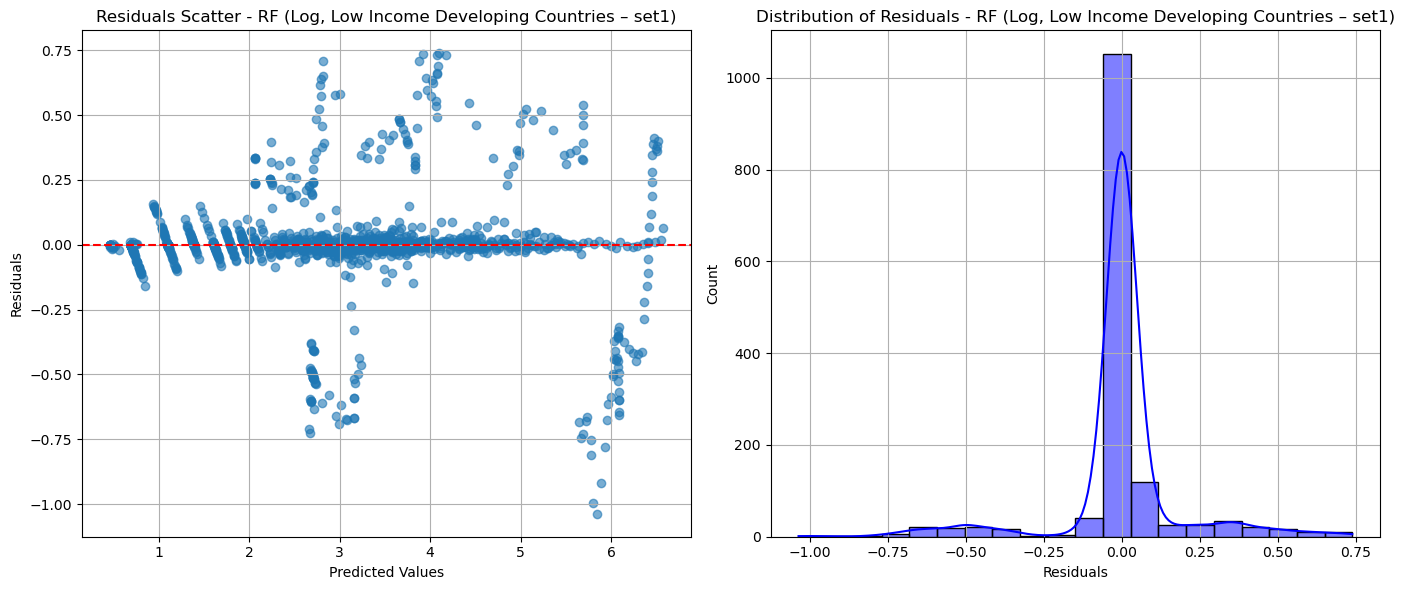


Emerging Market Economies – set1-No Log Models 
Linear Model Test Results:
 → Test MSE: 63076.1655
 → Test R² : 0.4042

Fold 1: MSE=54023.7737, R²=0.8250
Fold 2: MSE=3238815.3318, R²=0.2960
Fold 3: MSE=240110.6594, R²=0.8028
Fold 4: MSE=16936.7660, R²=0.9008
Fold 5: MSE=5454.3088, R²=0.8252

Average MSE: 711068.1679
Average R² : 0.7300



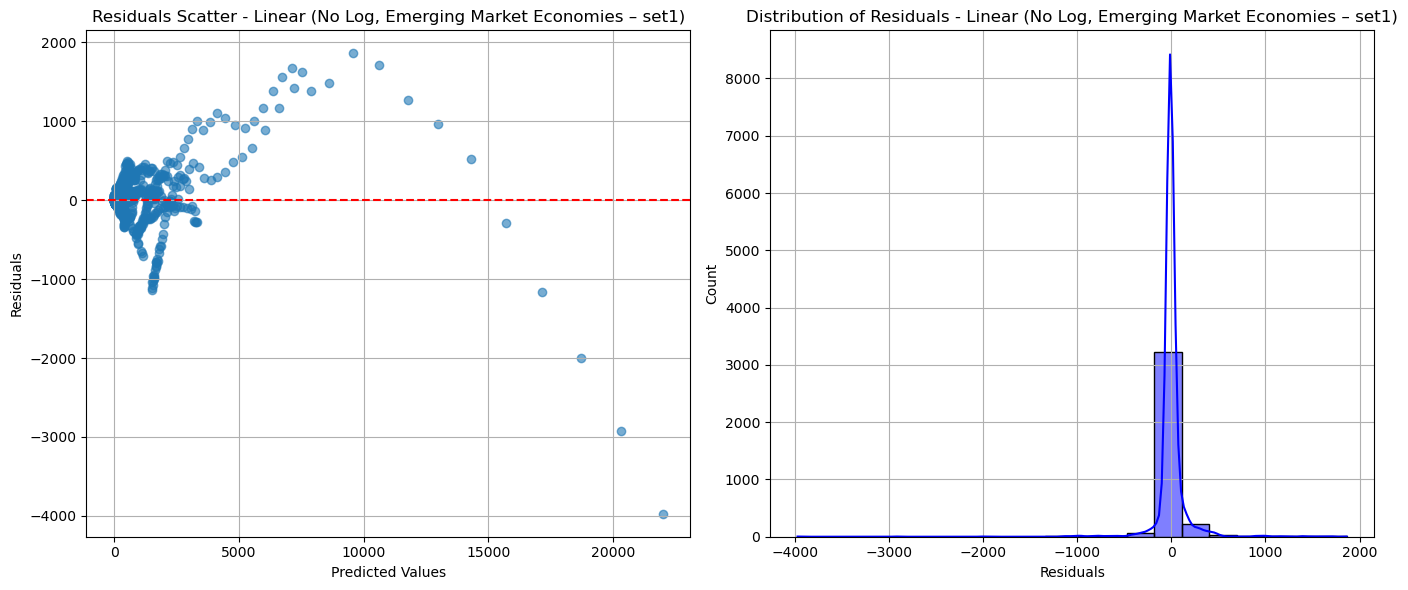

Randomforest Model Test Results:
 → Test MSE: 32116.3167
 → Test R² : 0.6966

Fold 1: MSE=141324.1630, R²=0.5423
Fold 2: MSE=2974528.4438, R²=0.3535
Fold 3: MSE=315076.6234, R²=0.7413
Fold 4: MSE=28311.7628, R²=0.8342
Fold 5: MSE=5316.7209, R²=0.8297

Average MSE: 692911.5428
Average R² : 0.6602

Model does not support feature importances.


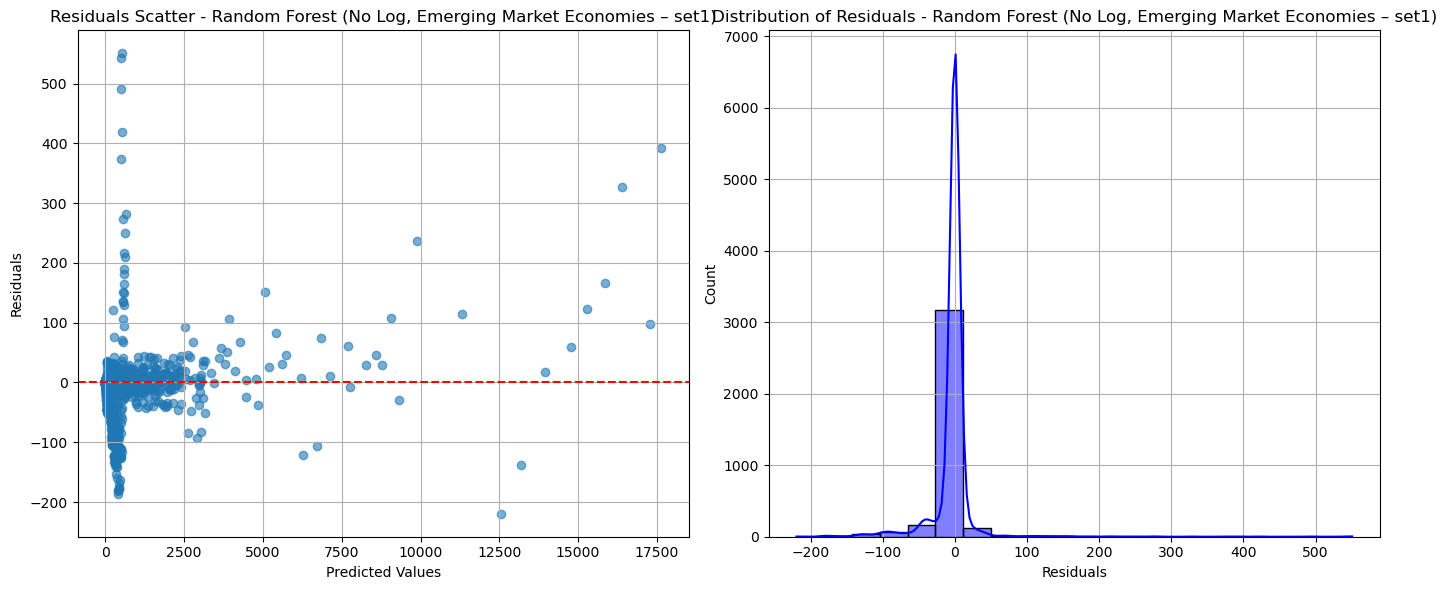


Emerging Market Economies – set1-Log Models
Linear Model Test Results:
 → Test MSE: 0.1169
 → Test R² : 0.9674

Fold 1: MSE=0.1831, R²=0.9531
Fold 2: MSE=0.1122, R²=0.9664
Fold 3: MSE=0.0815, R²=0.9789
Fold 4: MSE=0.2621, R²=0.8796
Fold 5: MSE=0.1030, R²=0.9576

Average MSE: 0.1484
Average R² : 0.9471



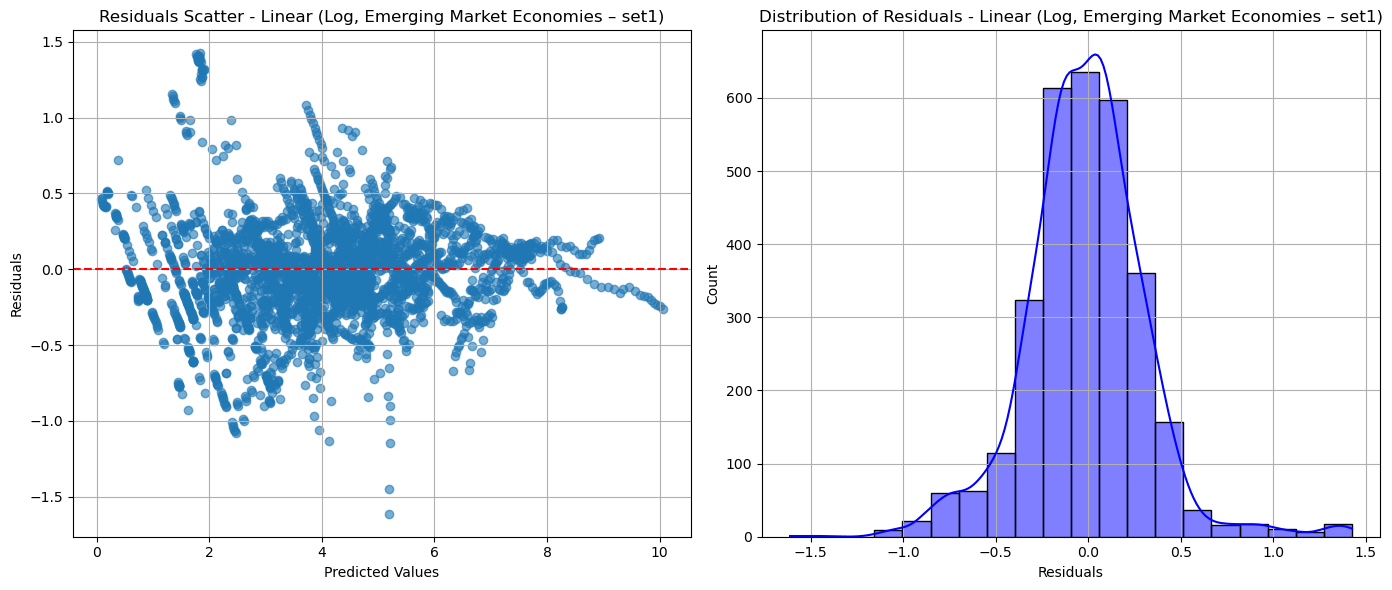

Randomforest Model Test Results:
 → Test MSE: 0.1627
 → Test R² : 0.9546

Fold 1: MSE=0.4971, R²=0.8726
Fold 2: MSE=0.3176, R²=0.9049
Fold 3: MSE=0.1899, R²=0.9509
Fold 4: MSE=0.3267, R²=0.8499
Fold 5: MSE=0.1992, R²=0.9180

Average MSE: 0.3061
Average R² : 0.8992

Model does not support feature importances.


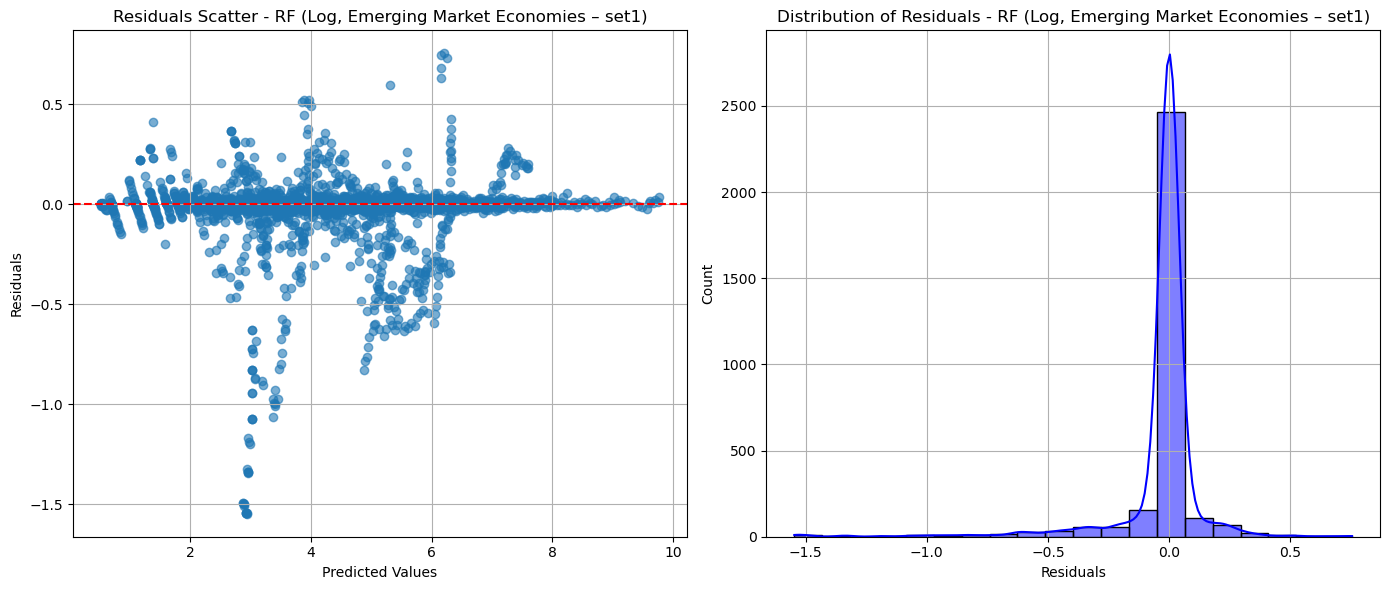


Advanced Economies – set1-No Log Models 
Linear Model Test Results:
 → Test MSE: 1956600.4116
 → Test R² : 0.8911

Fold 1: MSE=4312.4449, R²=0.9767
Fold 2: MSE=29529.1641, R²=0.9832
Fold 3: MSE=144324.4460, R²=0.9402
Fold 4: MSE=3140.4392, R²=0.9517
Fold 5: MSE=1046.2091, R²=0.9100

Average MSE: 36470.5407
Average R² : 0.9523



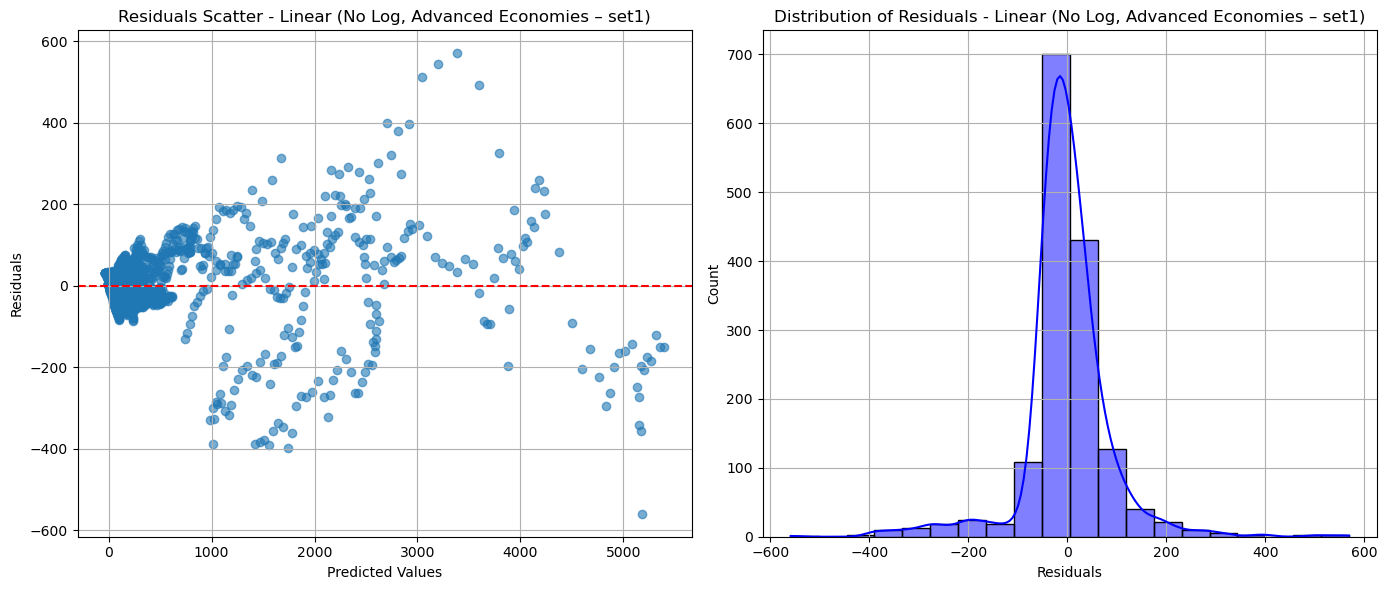

Randomforest Model Test Results:
 → Test MSE: 9913196.1698
 → Test R² : 0.4485

Fold 1: MSE=9889.5409, R²=0.9466
Fold 2: MSE=441458.7196, R²=0.7482
Fold 3: MSE=85008.2275, R²=0.9648
Fold 4: MSE=970.1281, R²=0.9851
Fold 5: MSE=959.8652, R²=0.9174

Average MSE: 107657.2963
Average R² : 0.9124

Model does not support feature importances.


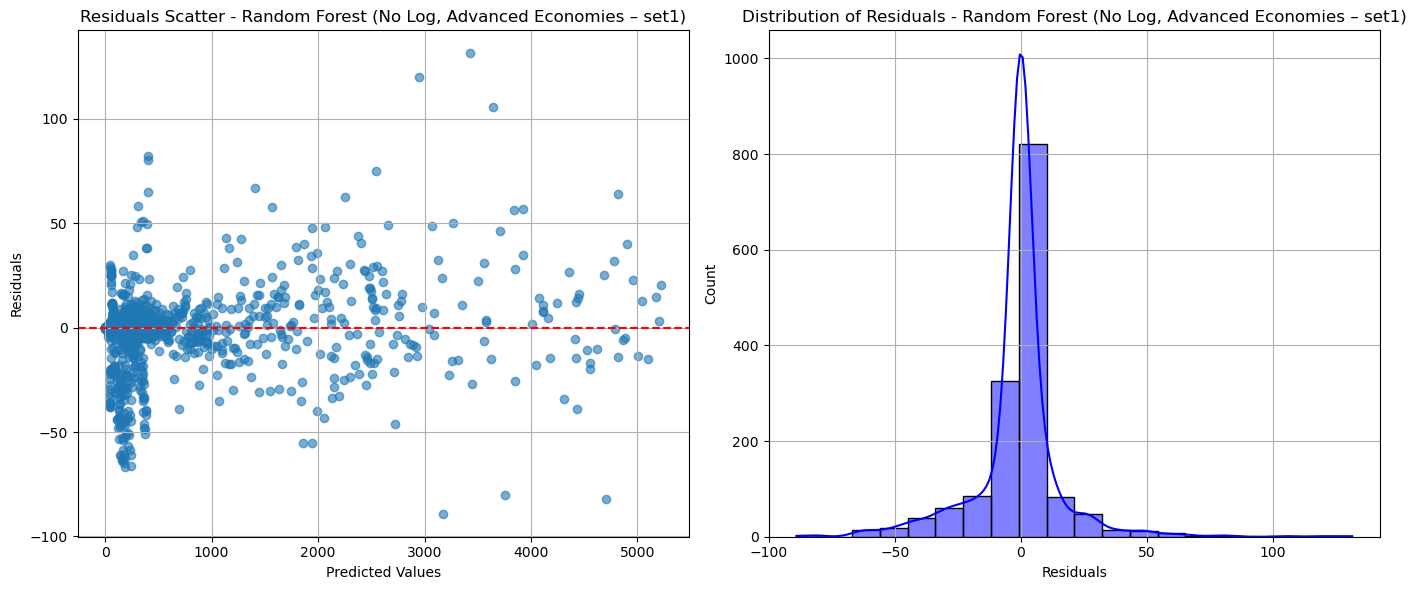


Advanced Economies – set1-Log Models
Linear Model Test Results:
 → Test MSE: 0.0874
 → Test R² : 0.9711

Fold 1: MSE=0.1570, R²=0.9001
Fold 2: MSE=0.1643, R²=0.9681
Fold 3: MSE=0.2223, R²=0.9270
Fold 4: MSE=0.2229, R²=0.7698
Fold 5: MSE=0.1131, R²=0.7966

Average MSE: 0.1759
Average R² : 0.8723



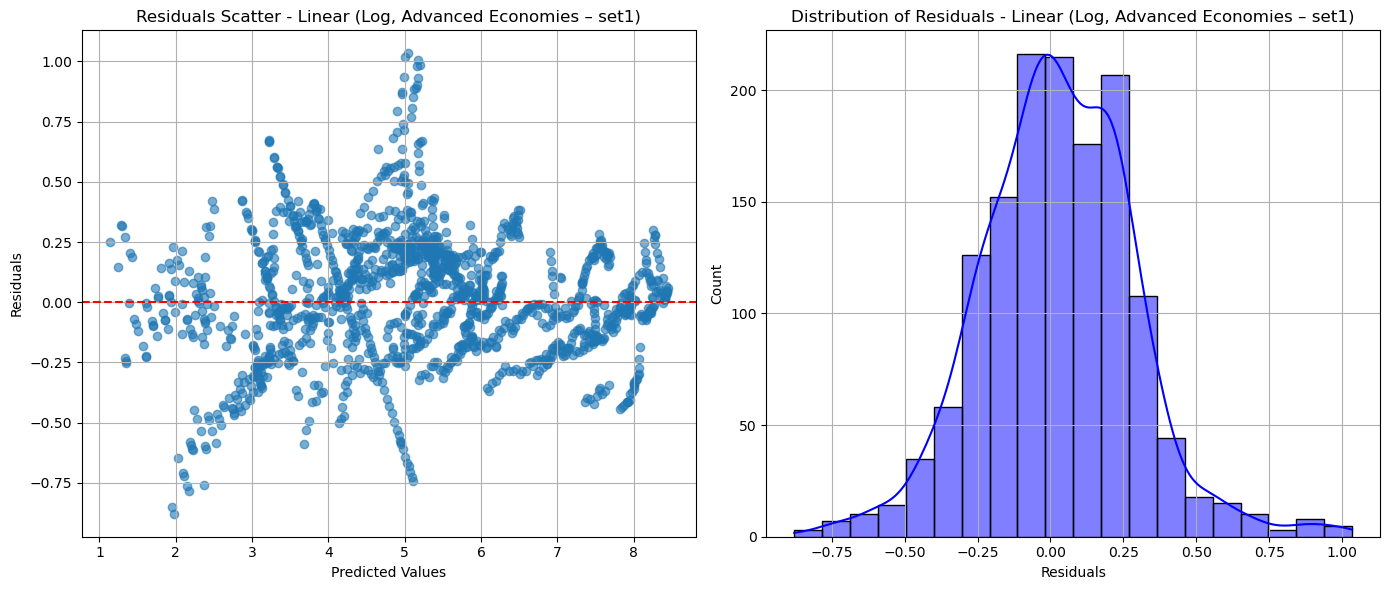

Randomforest Model Test Results:
 → Test MSE: 0.1680
 → Test R² : 0.9444

Fold 1: MSE=2.0465, R²=-0.3019
Fold 2: MSE=0.2233, R²=0.9566
Fold 3: MSE=0.0387, R²=0.9873
Fold 4: MSE=0.4226, R²=0.5637
Fold 5: MSE=0.0529, R²=0.9050

Average MSE: 0.5568
Average R² : 0.6221

Model does not support feature importances.


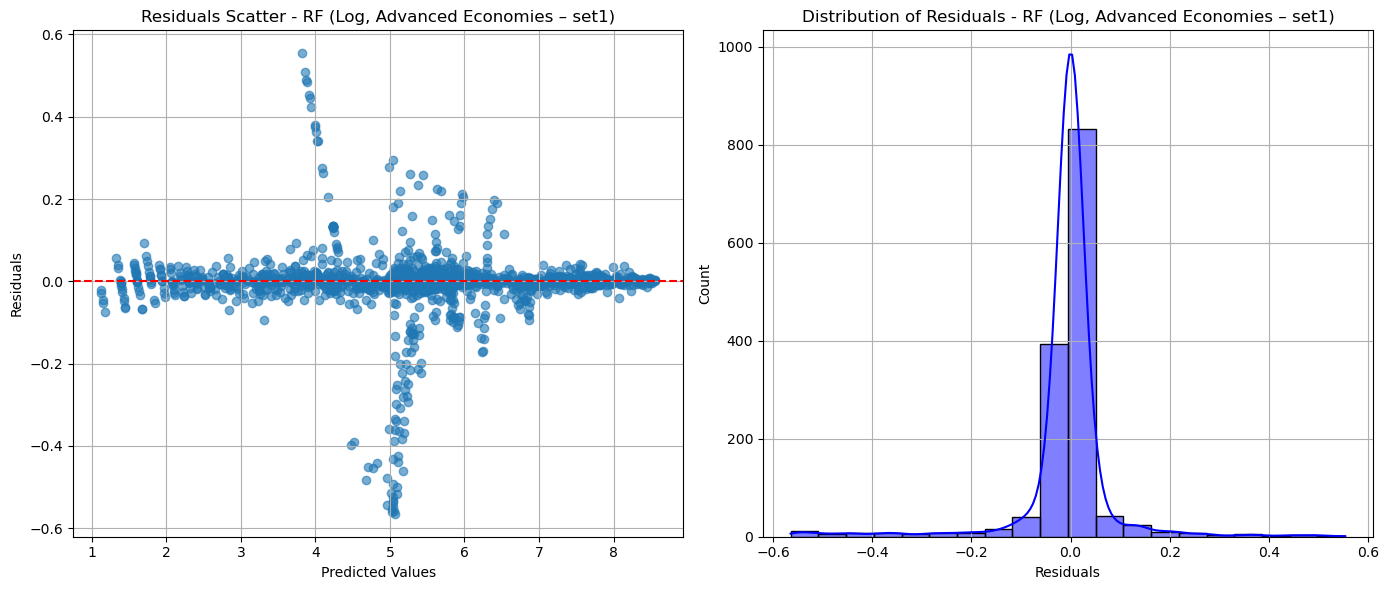


Low Income Developing Countries – set2-No Log Models 
Linear Model Test Results:
 → Test MSE: 4001.5642
 → Test R² : 0.4681

Fold 1: MSE=23.4561, R²=0.9279
Fold 2: MSE=195.5810, R²=0.8583
Fold 3: MSE=146.8388, R²=0.8841
Fold 4: MSE=306.3759, R²=0.7974
Fold 5: MSE=7692.0854, R²=0.7592

Average MSE: 1672.8674
Average R² : 0.8454



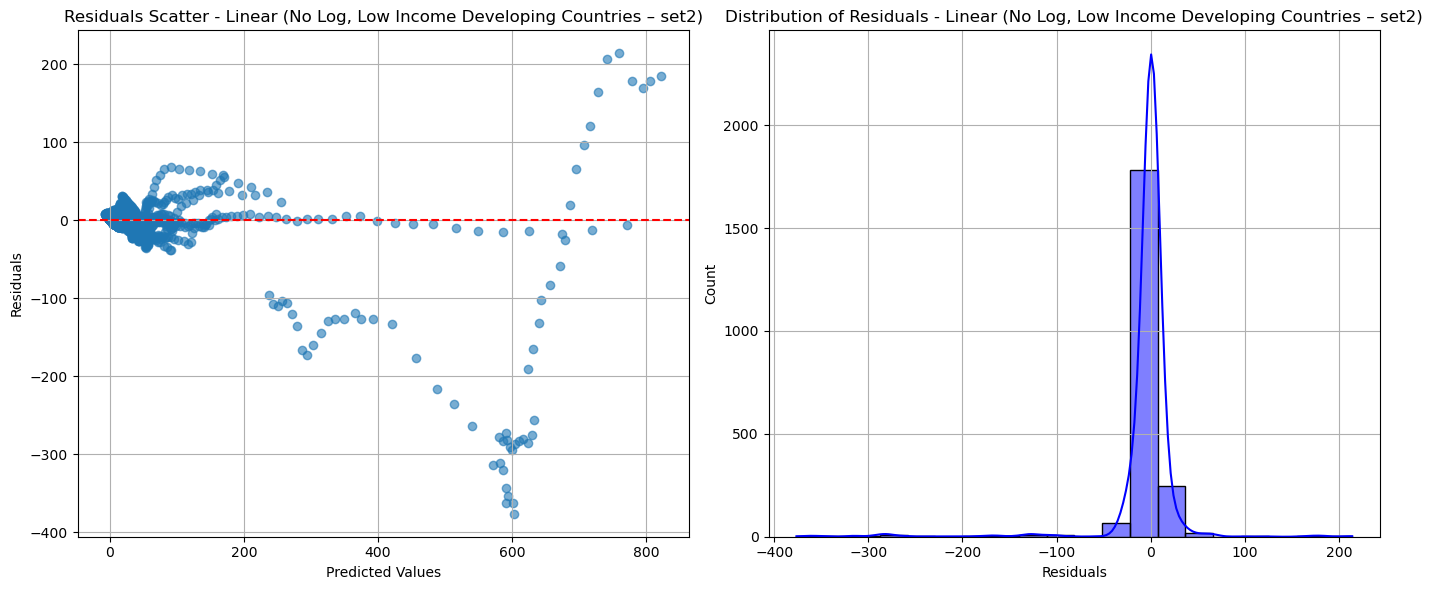

Randomforest Model Test Results:
 → Test MSE: 2678.8385
 → Test R² : 0.6439

Fold 1: MSE=33.2114, R²=0.8979
Fold 2: MSE=430.7674, R²=0.6879
Fold 3: MSE=268.1481, R²=0.7884
Fold 4: MSE=283.5510, R²=0.8125
Fold 5: MSE=5105.7787, R²=0.8402

Average MSE: 1224.2913
Average R² : 0.8054

Model does not support feature importances.


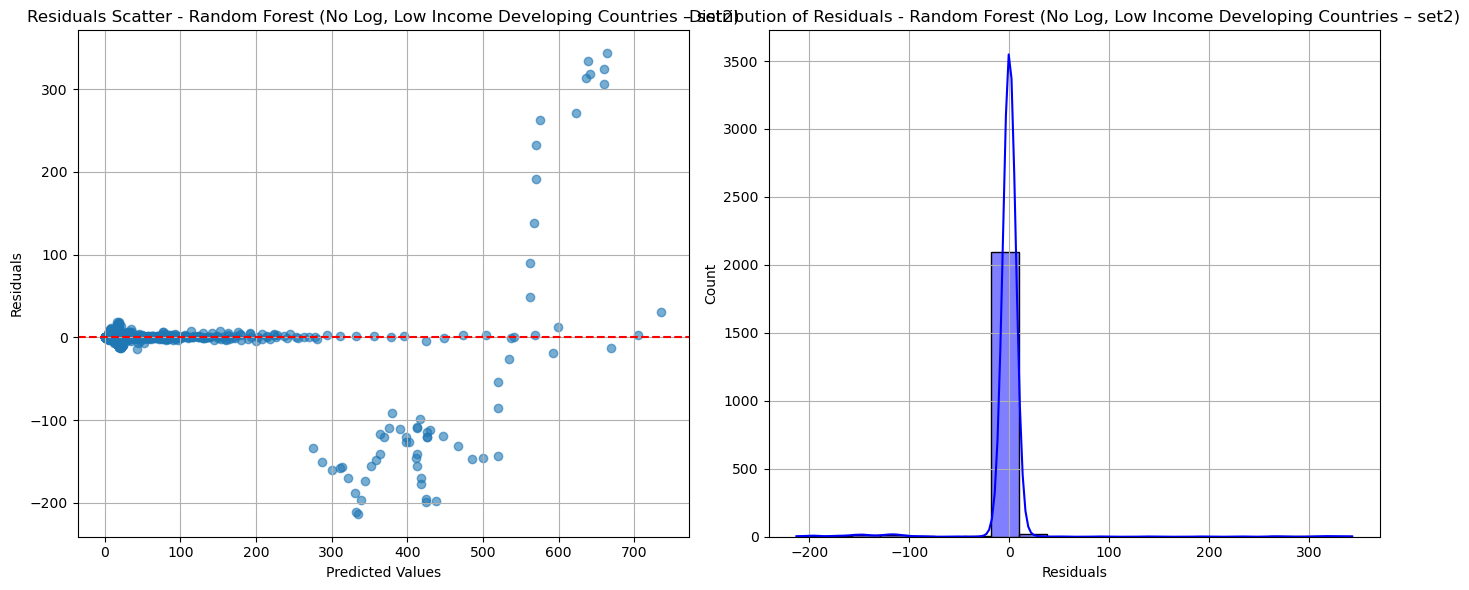


Low Income Developing Countries – set2-Log Models
Linear Model Test Results:
 → Test MSE: 0.3838
 → Test R² : -17.6145

Fold 1: MSE=0.0000, R²=0.0000
Fold 2: MSE=0.0000, R²=0.0000
Fold 3: MSE=0.0000, R²=1.0000
Fold 4: MSE=0.0751, R²=-0.7205
Fold 5: MSE=3811.8799, R²=-7165.9366

Average MSE: 762.3910
Average R² : -1433.1314



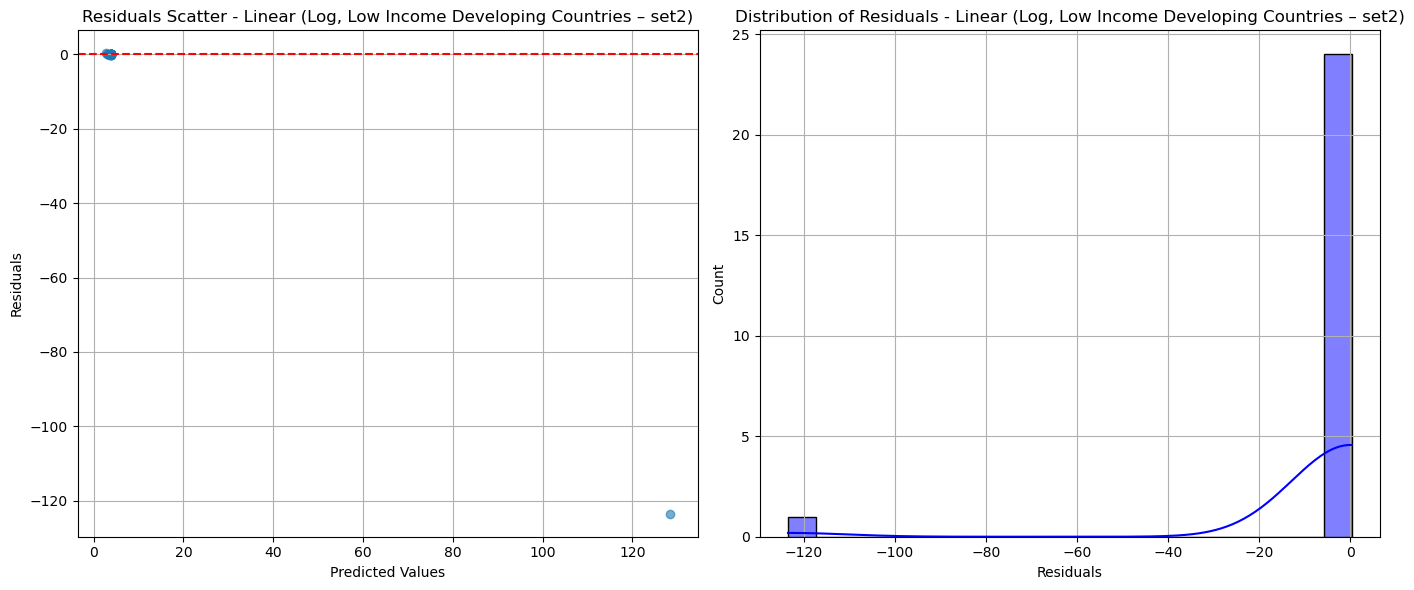

Randomforest Model Test Results:
 → Test MSE: 1.1708
 → Test R² : -55.7793

Fold 1: MSE=0.0000, R²=0.0000
Fold 2: MSE=0.0000, R²=0.0000
Fold 3: MSE=0.0000, R²=0.0000
Fold 4: MSE=0.0751, R²=-0.7205
Fold 5: MSE=0.5012, R²=0.0577

Average MSE: 0.1153
Average R² : -0.1326

Model does not support feature importances.


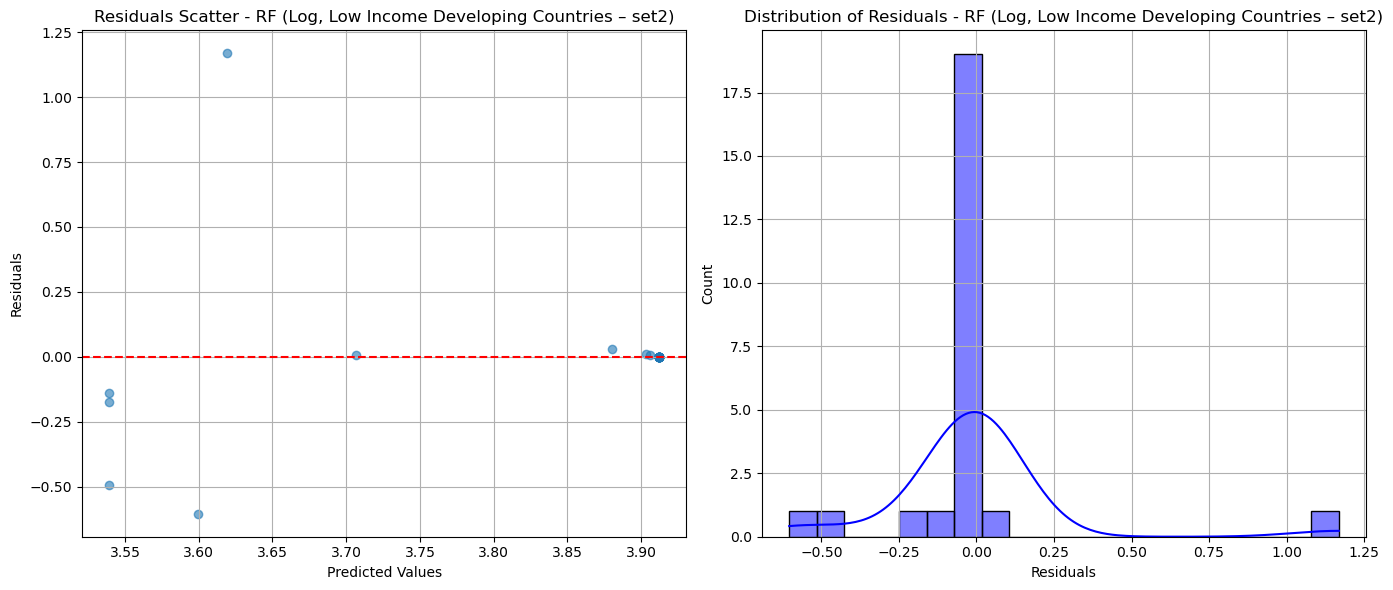


Emerging Market Economies – set2-No Log Models 
Linear Model Test Results:
 → Test MSE: 52768.8475
 → Test R² : 0.5016

Fold 1: MSE=55048.8647, R²=0.8217
Fold 2: MSE=3209292.7040, R²=0.3024
Fold 3: MSE=224617.8956, R²=0.8156
Fold 4: MSE=19451.9317, R²=0.8861
Fold 5: MSE=6911.2147, R²=0.7786

Average MSE: 703064.5221
Average R² : 0.7209



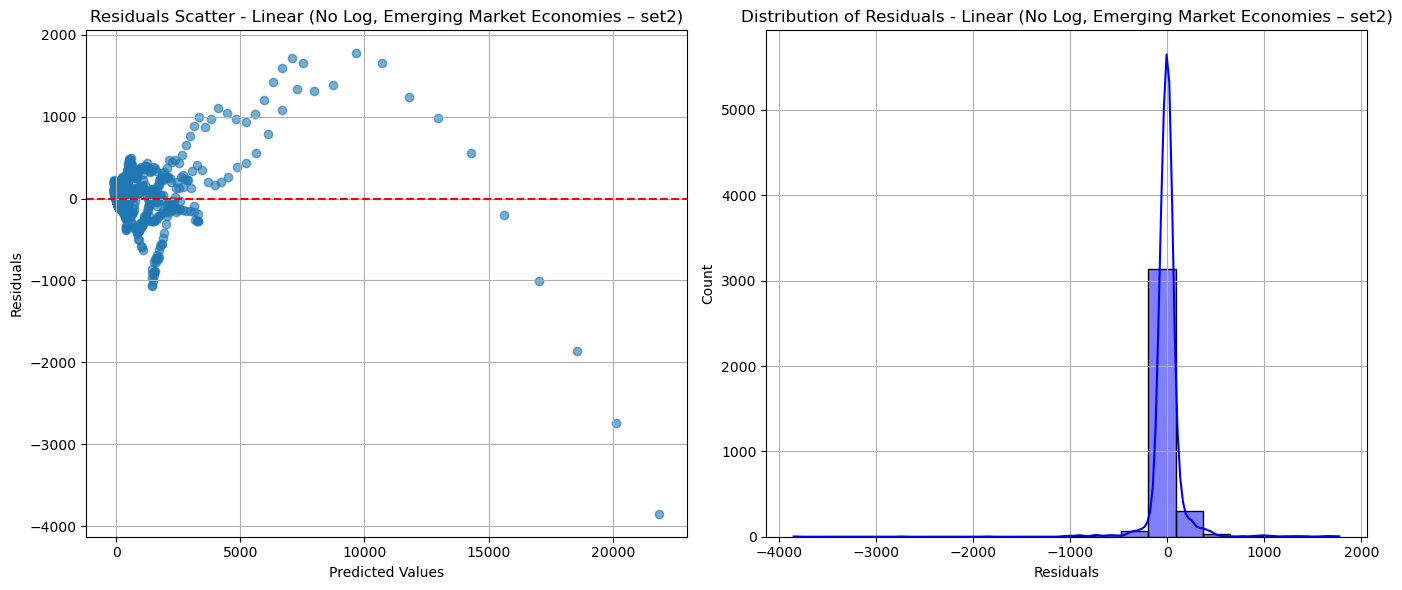

Randomforest Model Test Results:
 → Test MSE: 38630.6712
 → Test R² : 0.6351

Fold 1: MSE=139324.3071, R²=0.5488
Fold 2: MSE=3069789.3580, R²=0.3328
Fold 3: MSE=353986.3318, R²=0.7093
Fold 4: MSE=28621.9759, R²=0.8324
Fold 5: MSE=6761.6017, R²=0.7834

Average MSE: 719696.7149
Average R² : 0.6413

Model does not support feature importances.


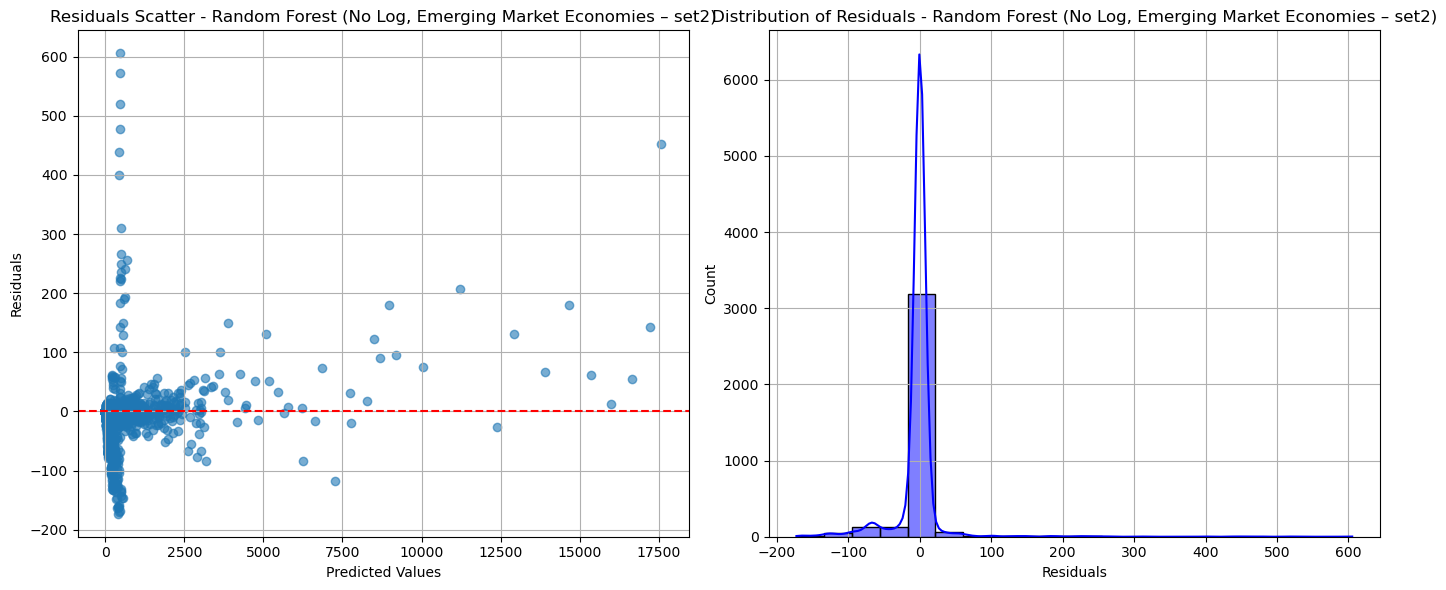


Emerging Market Economies – set2-Log Models
Linear Model Test Results:
 → Test MSE: 0.0984
 → Test R² : 0.8942

Fold 1: MSE=1.0767, R²=0.4081
Fold 2: MSE=0.0582, R²=0.9798
Fold 3: MSE=0.0583, R²=0.9031
Fold 4: MSE=0.2489, R²=0.6542
Fold 5: MSE=0.0547, R²=0.8124

Average MSE: 0.2994
Average R² : 0.7515



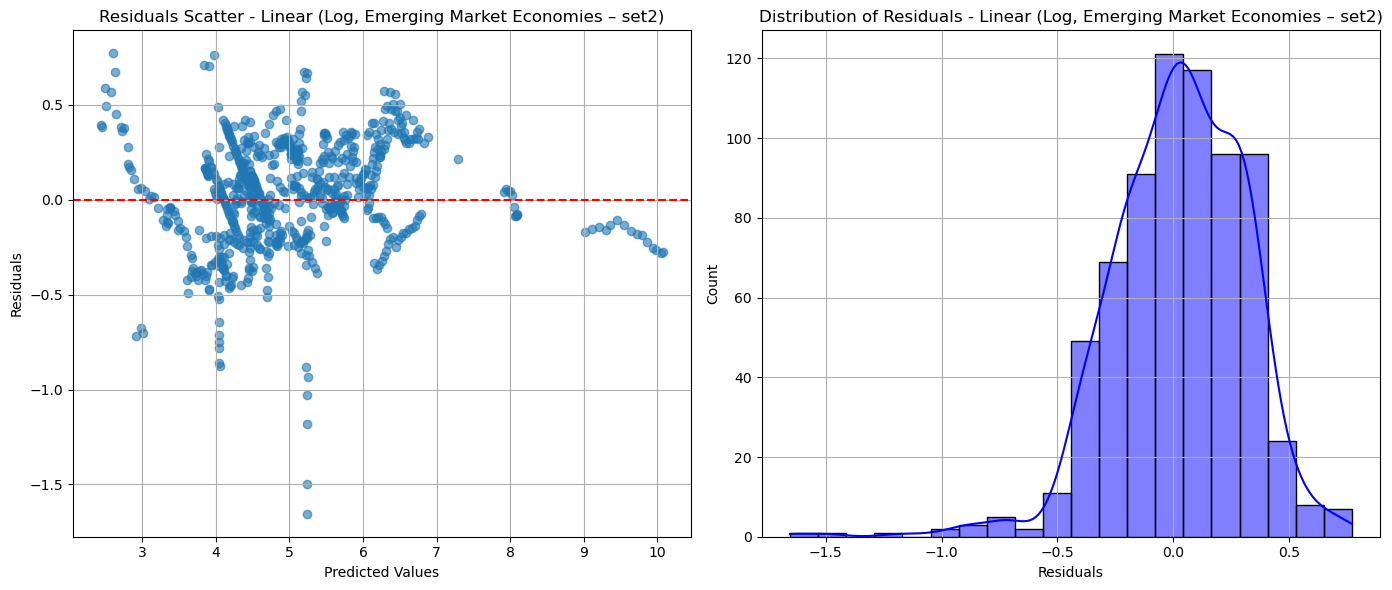

Randomforest Model Test Results:
 → Test MSE: 0.1423
 → Test R² : 0.8470

Fold 1: MSE=0.3684, R²=0.7975
Fold 2: MSE=0.6885, R²=0.7615
Fold 3: MSE=0.0923, R²=0.8466
Fold 4: MSE=0.4519, R²=0.3723
Fold 5: MSE=0.2945, R²=-0.0108

Average MSE: 0.3791
Average R² : 0.5534

Model does not support feature importances.


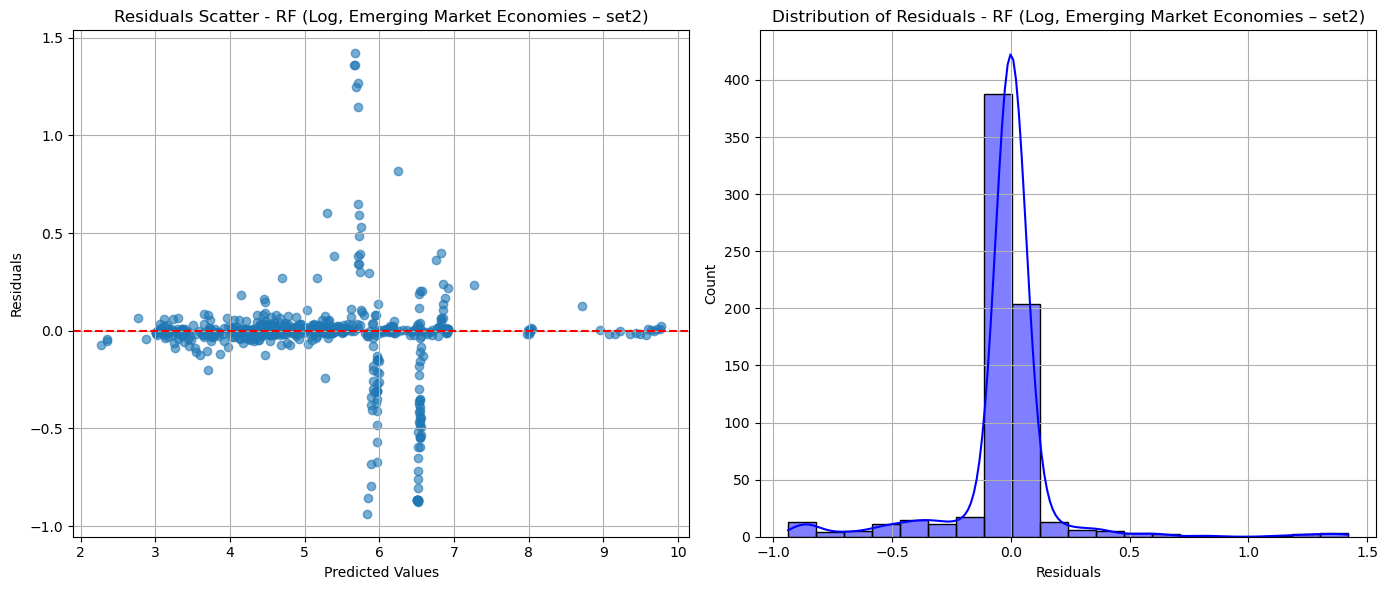


Advanced Economies – set2-No Log Models 
Linear Model Test Results:
 → Test MSE: 1978670.4307
 → Test R² : 0.8899

Fold 1: MSE=3592.1788, R²=0.9806
Fold 2: MSE=19267.8745, R²=0.9890
Fold 3: MSE=145588.5000, R²=0.9396
Fold 4: MSE=2127.5812, R²=0.9673
Fold 5: MSE=850.2296, R²=0.9268

Average MSE: 34285.2728
Average R² : 0.9607



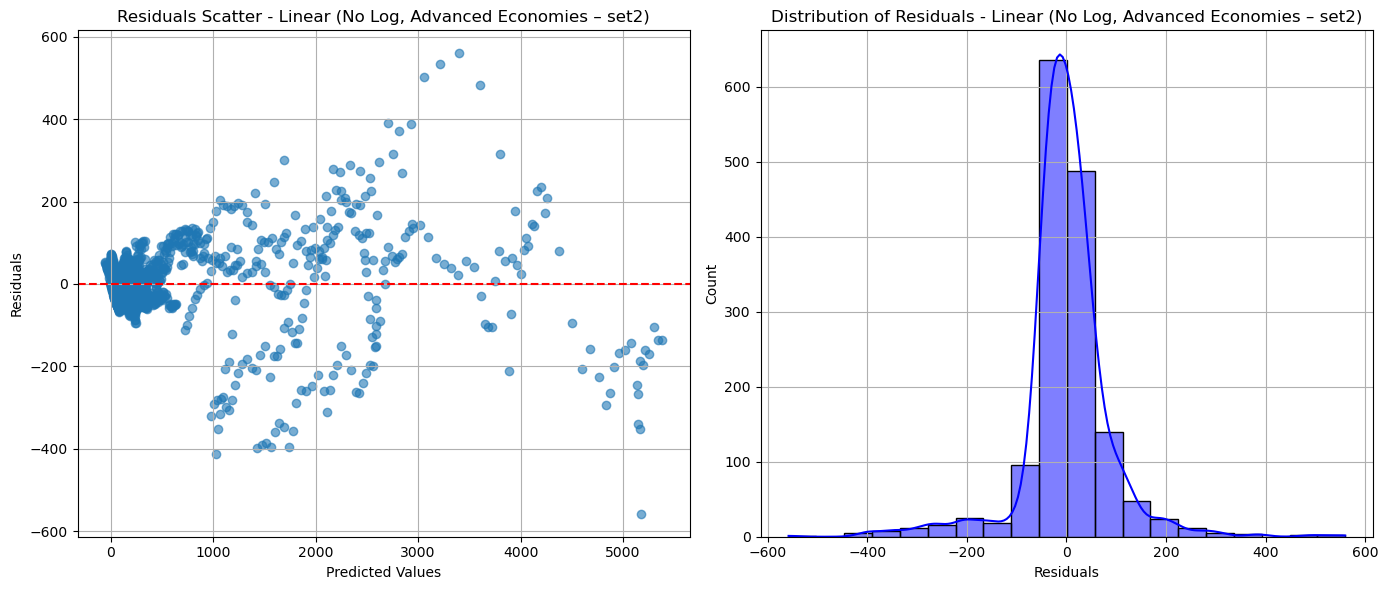

Randomforest Model Test Results:
 → Test MSE: 9726694.0311
 → Test R² : 0.4588

Fold 1: MSE=8129.7205, R²=0.9561
Fold 2: MSE=436034.3386, R²=0.7513
Fold 3: MSE=77063.1690, R²=0.9680
Fold 4: MSE=827.0485, R²=0.9873
Fold 5: MSE=1739.7138, R²=0.8503

Average MSE: 104758.7981
Average R² : 0.9026

Model does not support feature importances.


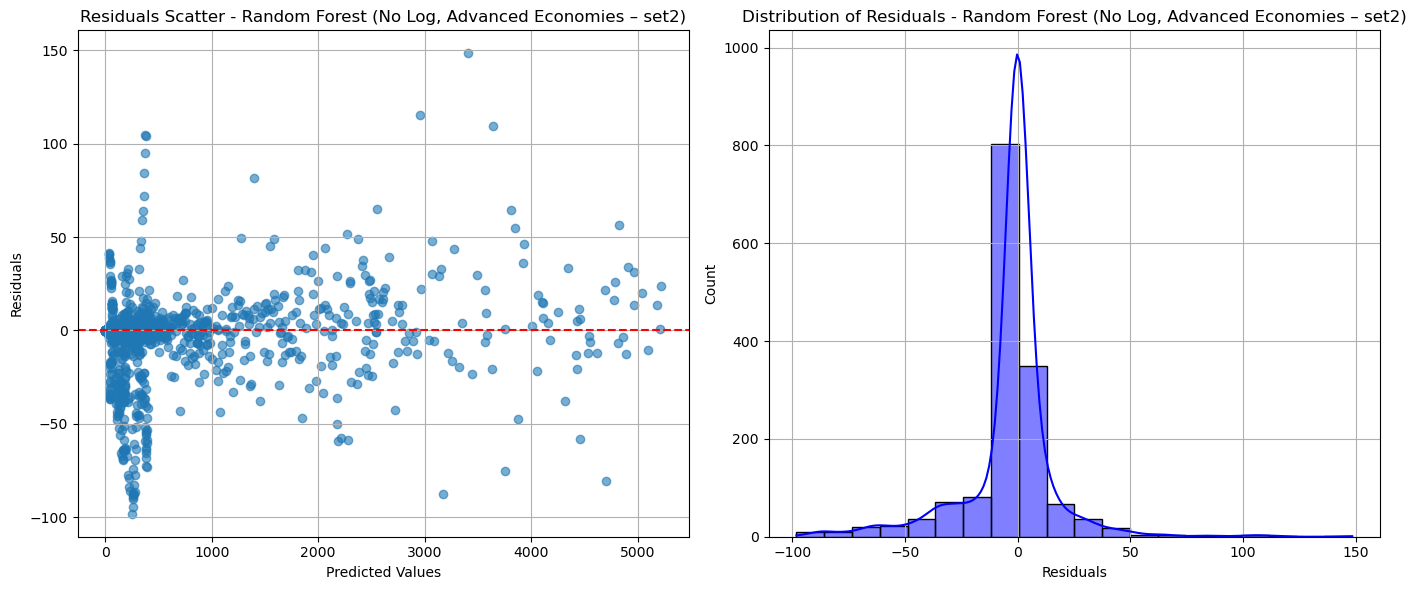


Advanced Economies – set2-Log Models
Linear Model Test Results:
 → Test MSE: 0.0462
 → Test R² : 0.9846

Fold 1: MSE=0.1615, R²=0.8946
Fold 2: MSE=0.1024, R²=0.9811
Fold 3: MSE=0.1814, R²=0.9350
Fold 4: MSE=0.1701, R²=0.8678
Fold 5: MSE=0.0413, R²=0.9244

Average MSE: 0.1313
Average R² : 0.9206



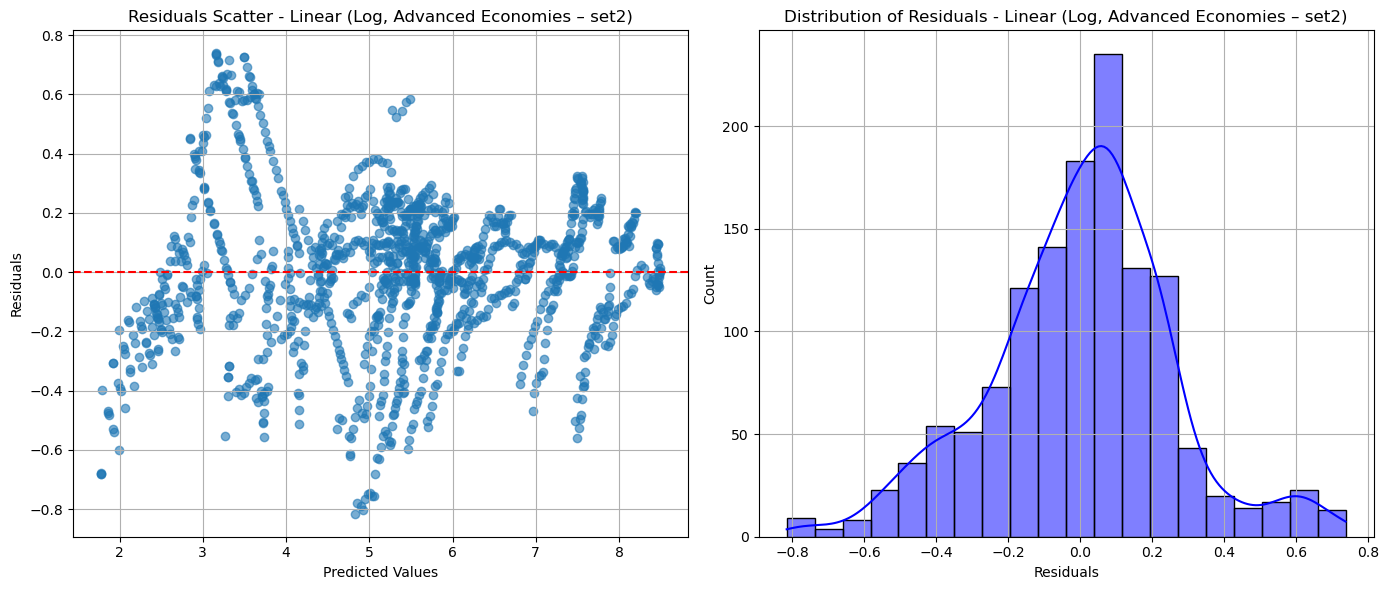

Randomforest Model Test Results:
 → Test MSE: 0.1783
 → Test R² : 0.9406

Fold 1: MSE=1.1205, R²=0.2688
Fold 2: MSE=0.7593, R²=0.8599
Fold 3: MSE=0.1322, R²=0.9526
Fold 4: MSE=0.2497, R²=0.8058
Fold 5: MSE=0.0559, R²=0.8978

Average MSE: 0.4635
Average R² : 0.7570

Model does not support feature importances.


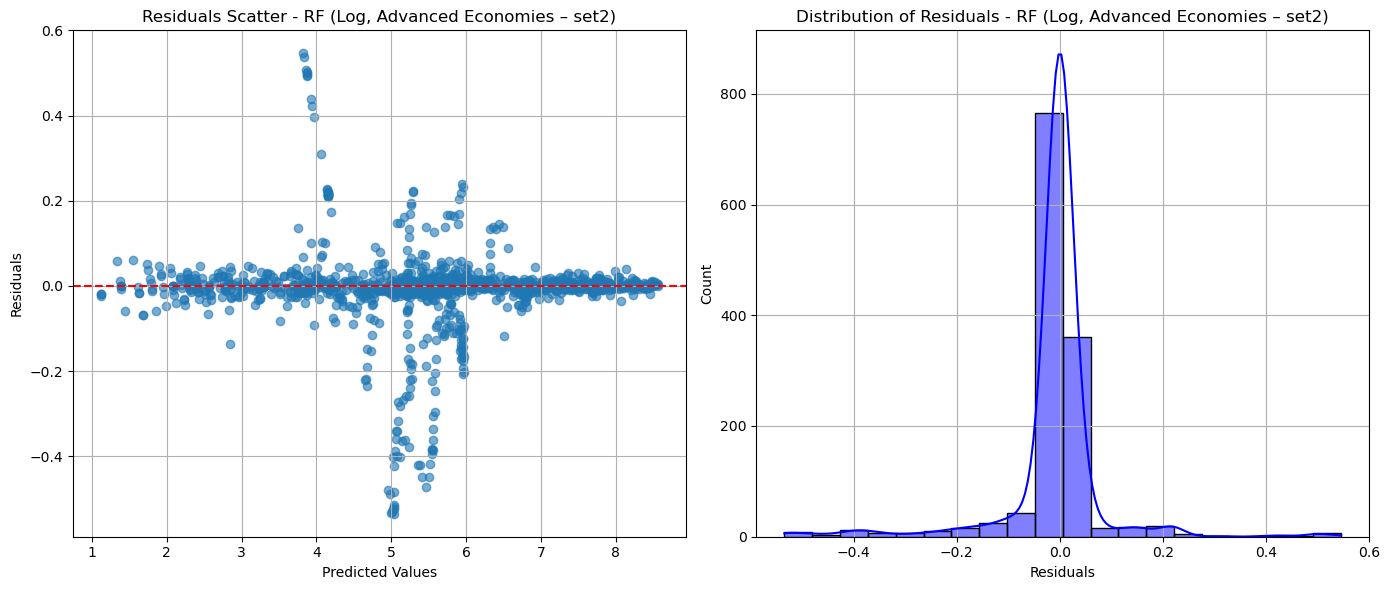


Low Income Developing Countries – set3-No Log Models 
Linear Model Test Results:
 → Test MSE: 4343.6294
 → Test R² : 0.4226

Fold 1: MSE=316.0769, R²=0.0283
Fold 2: MSE=242.3379, R²=0.8244
Fold 3: MSE=275.7884, R²=0.7824
Fold 4: MSE=239.9876, R²=0.8413
Fold 5: MSE=8722.3801, R²=0.7270

Average MSE: 1959.3142
Average R² : 0.6407



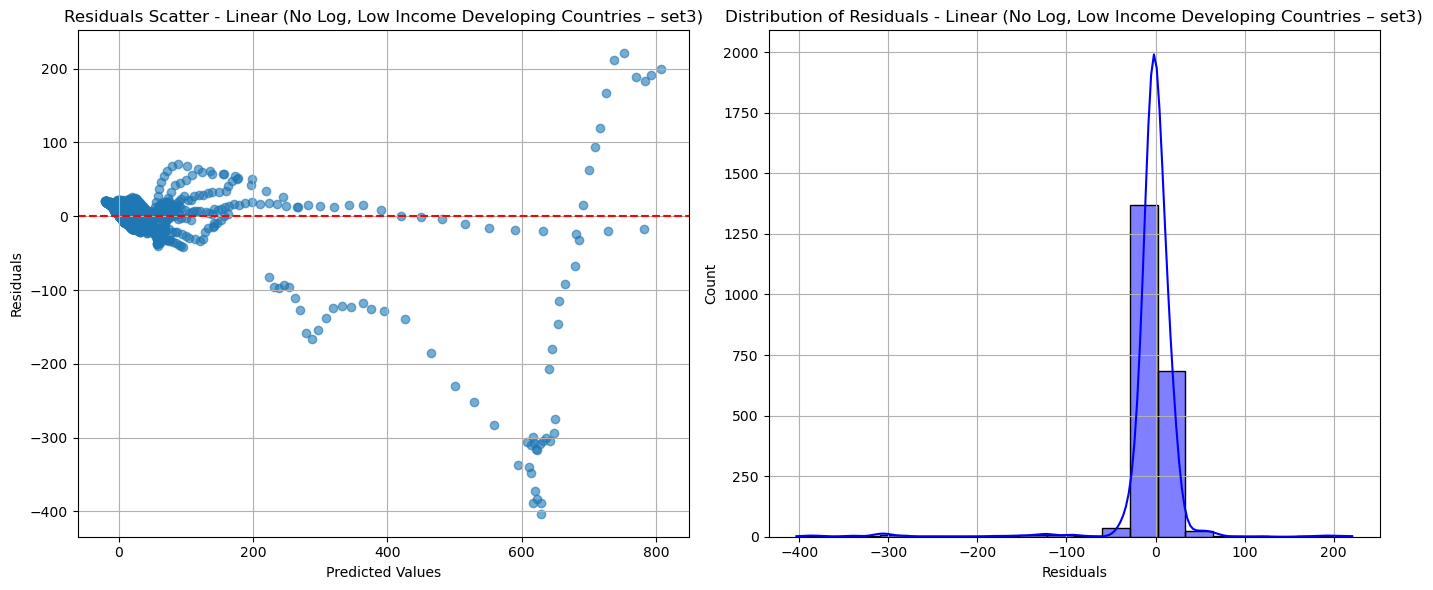

Randomforest Model Test Results:
 → Test MSE: 3014.3505
 → Test R² : 0.5993

Fold 1: MSE=67.7586, R²=0.7917
Fold 2: MSE=119.4807, R²=0.9134
Fold 3: MSE=281.1174, R²=0.7782
Fold 4: MSE=239.3779, R²=0.8417
Fold 5: MSE=5842.4053, R²=0.8171

Average MSE: 1310.0280
Average R² : 0.8284

Model does not support feature importances.


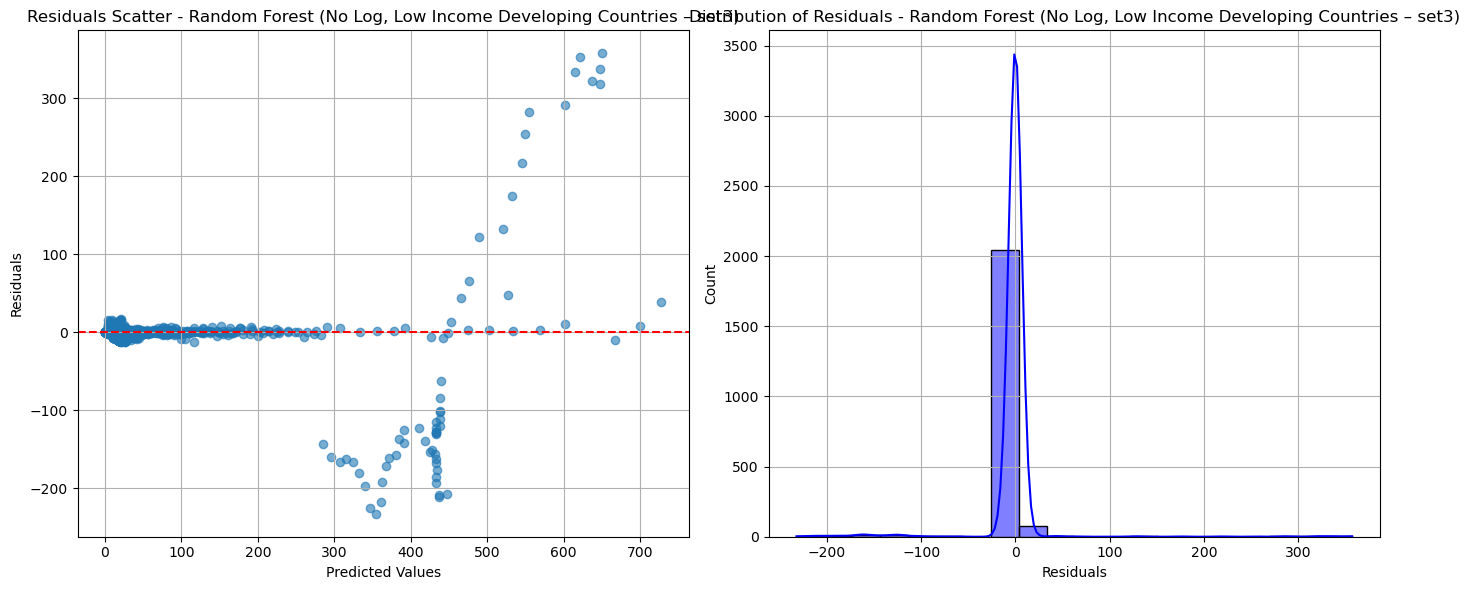


Low Income Developing Countries – set3-Log Models
Skipping Log Models for Low Income Developing Countries – set3: only 0 rows after log → need ≥ 2.

Emerging Market Economies – set3-No Log Models 
Linear Model Test Results:
 → Test MSE: 54826.8915
 → Test R² : 0.4821

Fold 1: MSE=62535.2083, R²=0.7975
Fold 2: MSE=2650346.8430, R²=0.4239
Fold 3: MSE=234079.0281, R²=0.8078
Fold 4: MSE=18484.9481, R²=0.8917
Fold 5: MSE=7186.8613, R²=0.7697

Average MSE: 594526.5778
Average R² : 0.7381



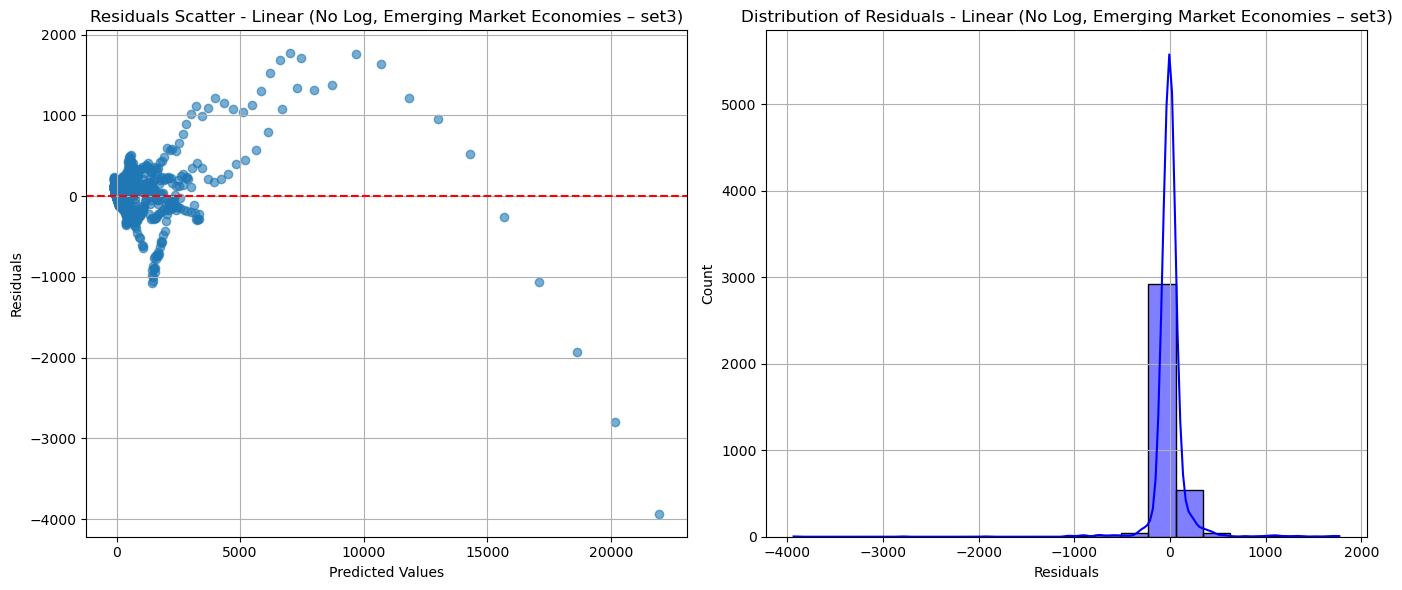

Randomforest Model Test Results:
 → Test MSE: 35895.4626
 → Test R² : 0.6609

Fold 1: MSE=145490.1000, R²=0.5288
Fold 2: MSE=3037988.2123, R²=0.3397
Fold 3: MSE=354842.8788, R²=0.7086
Fold 4: MSE=31652.5067, R²=0.8146
Fold 5: MSE=7666.5879, R²=0.7544

Average MSE: 715528.0571
Average R² : 0.6292

Model does not support feature importances.


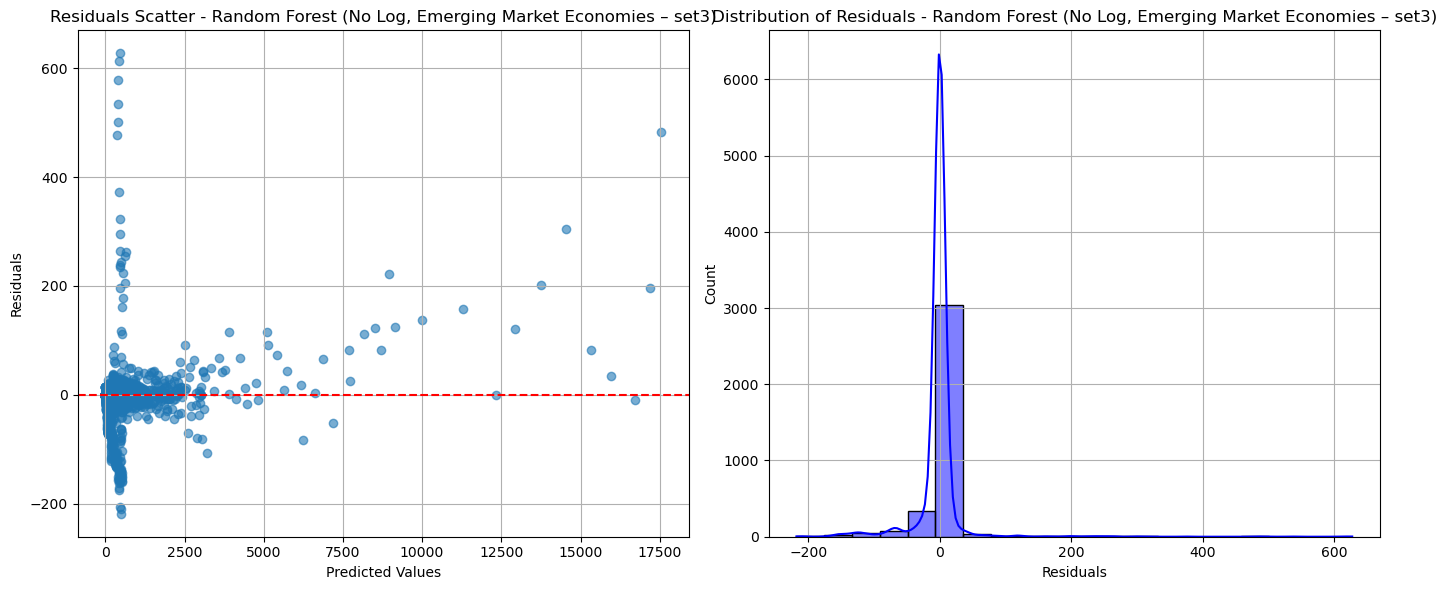


Emerging Market Economies – set3-Log Models
Linear Model Test Results:
 → Test MSE: 0.3158
 → Test R² : -1.7948

Fold 1: MSE=0.9956, R²=0.7047
Fold 2: MSE=0.7026, R²=-2.3265
Fold 3: MSE=0.0119, R²=0.6696
Fold 4: MSE=0.0458, R²=0.6277
Fold 5: MSE=0.1602, R²=-2.1125

Average MSE: 0.3832
Average R² : -0.4874



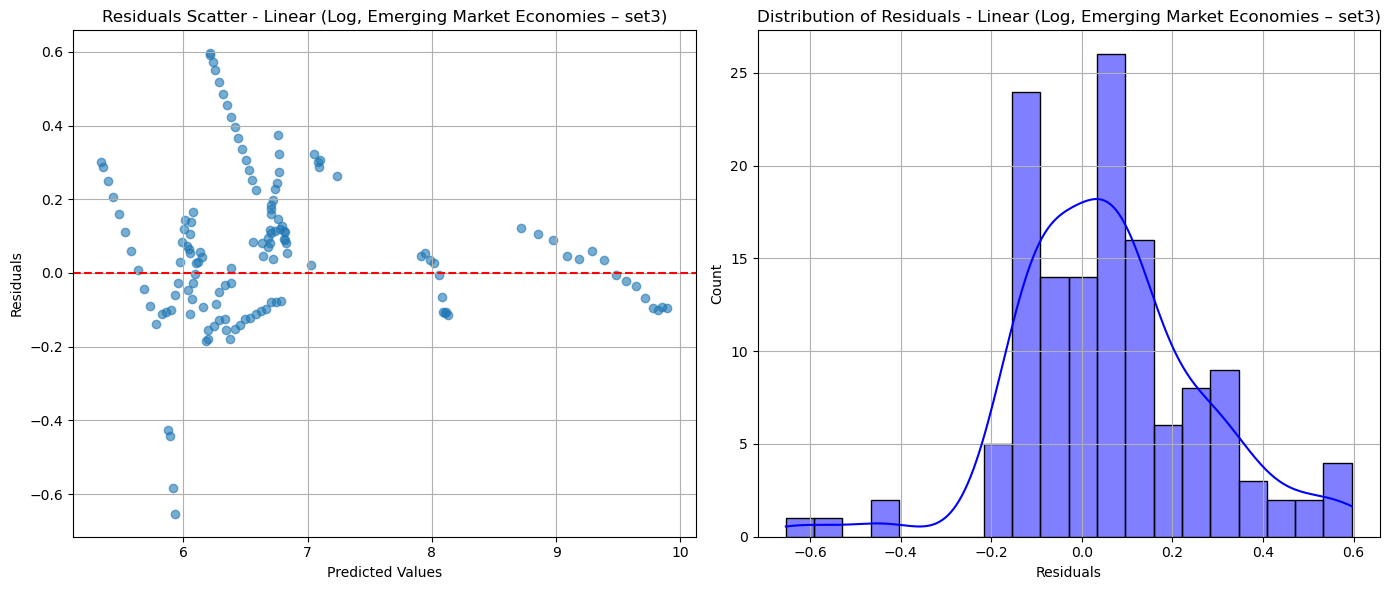

Randomforest Model Test Results:
 → Test MSE: 0.4928
 → Test R² : -3.3614

Fold 1: MSE=0.8324, R²=0.7531
Fold 2: MSE=0.4887, R²=-1.3140
Fold 3: MSE=0.0199, R²=0.4460
Fold 4: MSE=0.0300, R²=0.7559
Fold 5: MSE=0.1036, R²=-1.0125

Average MSE: 0.2949
Average R² : -0.0743

Model does not support feature importances.


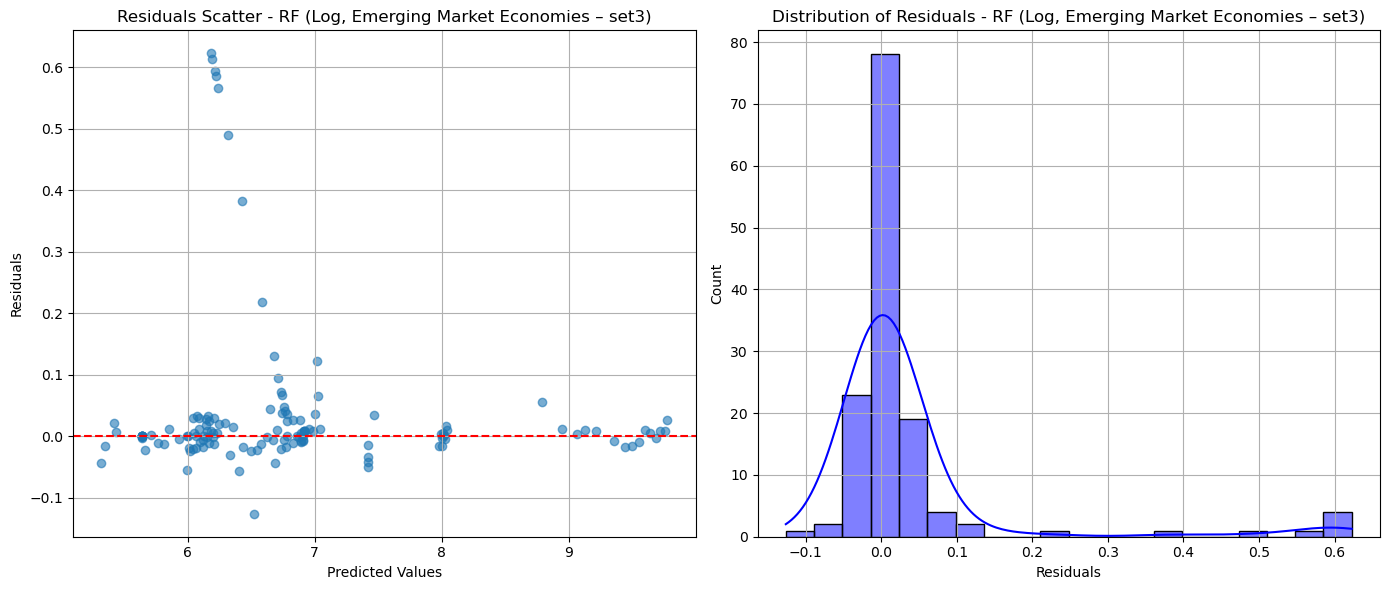


Advanced Economies – set3-No Log Models 
Linear Model Test Results:
 → Test MSE: 2198057.5478
 → Test R² : 0.8777

Fold 1: MSE=7759.2282, R²=0.9581
Fold 2: MSE=23683.9314, R²=0.9865
Fold 3: MSE=167066.3840, R²=0.9307
Fold 4: MSE=2543.9919, R²=0.9609
Fold 5: MSE=2692.4379, R²=0.7683

Average MSE: 40749.1947
Average R² : 0.9209



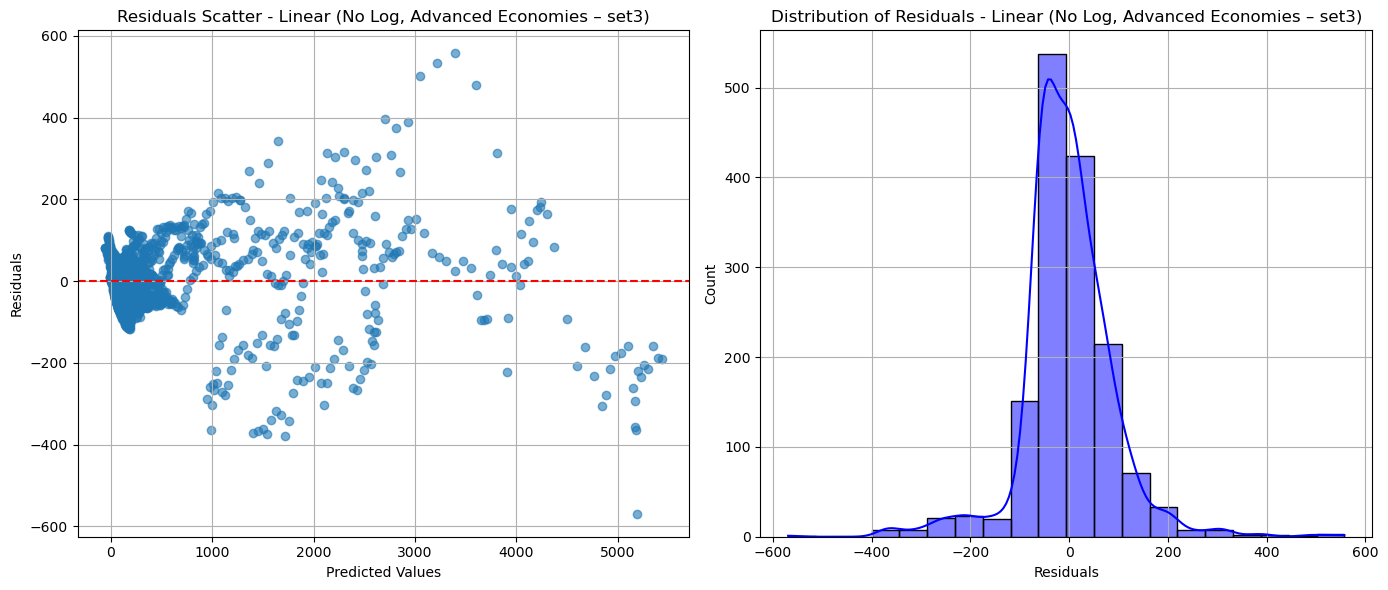

Randomforest Model Test Results:
 → Test MSE: 9603877.8661
 → Test R² : 0.4657

Fold 1: MSE=11253.1629, R²=0.9393
Fold 2: MSE=437514.1661, R²=0.7504
Fold 3: MSE=70288.1406, R²=0.9709
Fold 4: MSE=1084.4526, R²=0.9833
Fold 5: MSE=2285.4676, R²=0.8033

Average MSE: 104485.0779
Average R² : 0.8894

Model does not support feature importances.


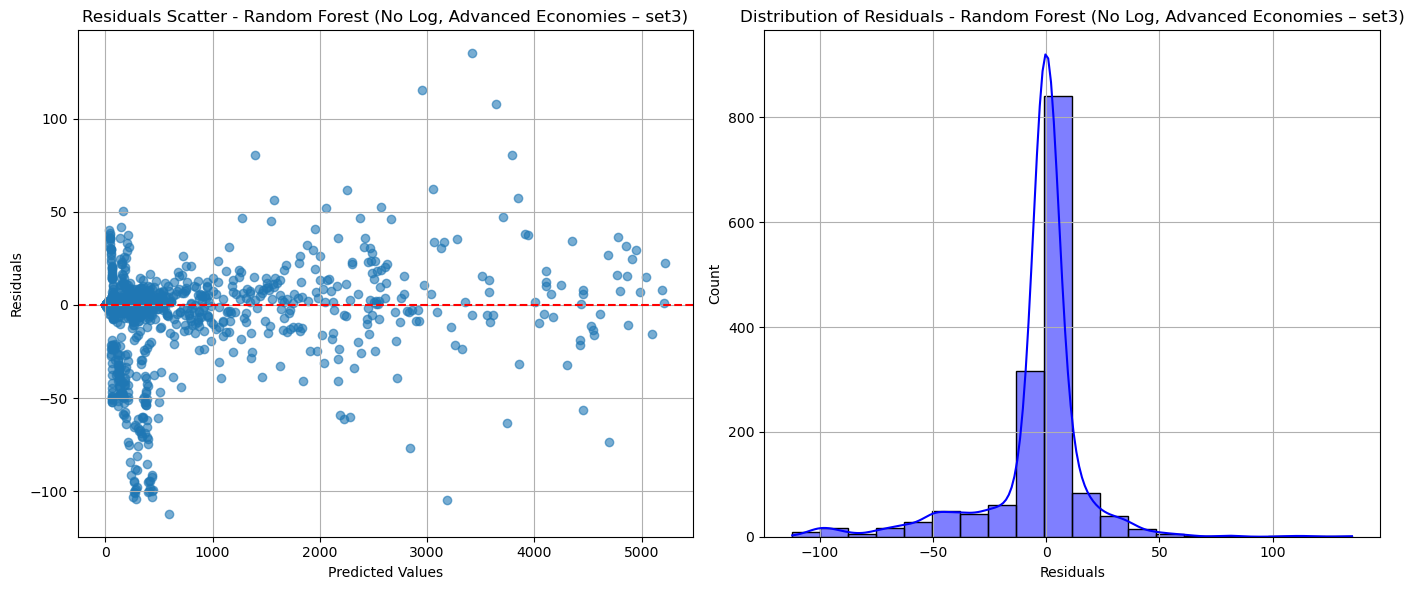


Advanced Economies – set3-Log Models
Linear Model Test Results:
 → Test MSE: 0.1501
 → Test R² : 0.7755

Fold 1: MSE=0.4618, R²=-2.7648
Fold 2: MSE=0.0117, R²=0.9086
Fold 3: MSE=0.0187, R²=0.9262
Fold 4: MSE=0.0666, R²=0.6979
Fold 5: MSE=0.0074, R²=0.9212

Average MSE: 0.1132
Average R² : 0.1378



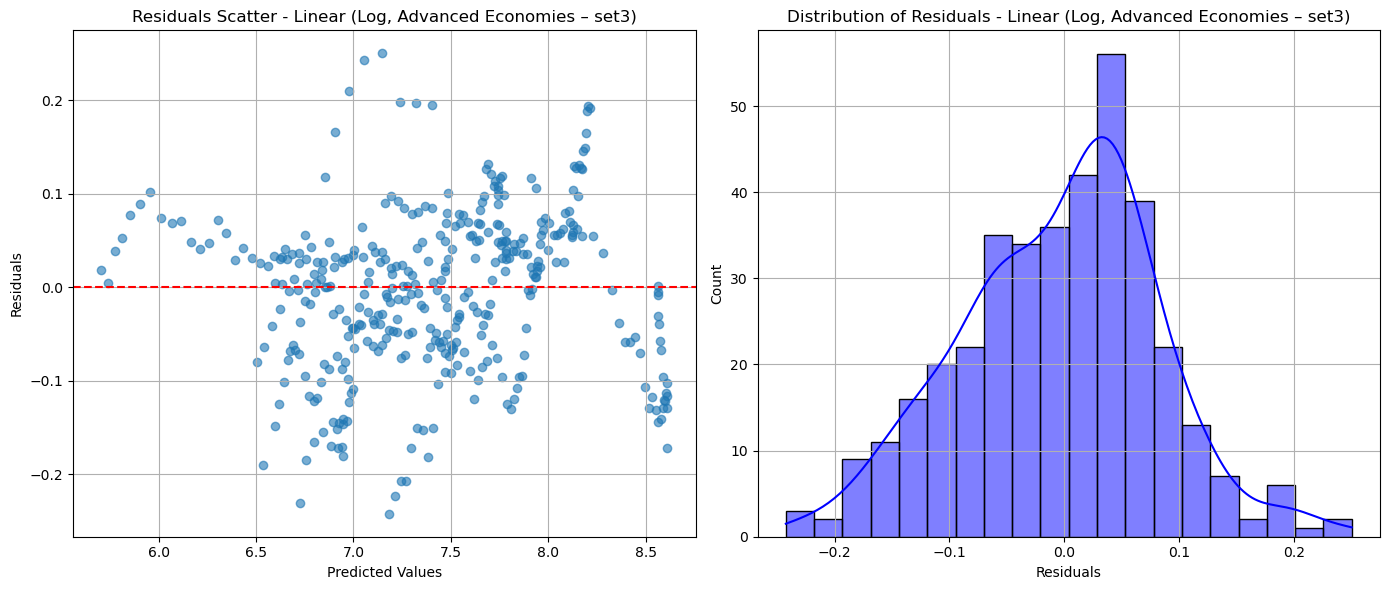

Randomforest Model Test Results:
 → Test MSE: 0.4817
 → Test R² : 0.2794

Fold 1: MSE=0.5472, R²=-3.4611
Fold 2: MSE=0.0392, R²=0.6940
Fold 3: MSE=0.0275, R²=0.8914
Fold 4: MSE=0.0232, R²=0.8947
Fold 5: MSE=0.0120, R²=0.8724

Average MSE: 0.1298
Average R² : -0.0217

Model does not support feature importances.


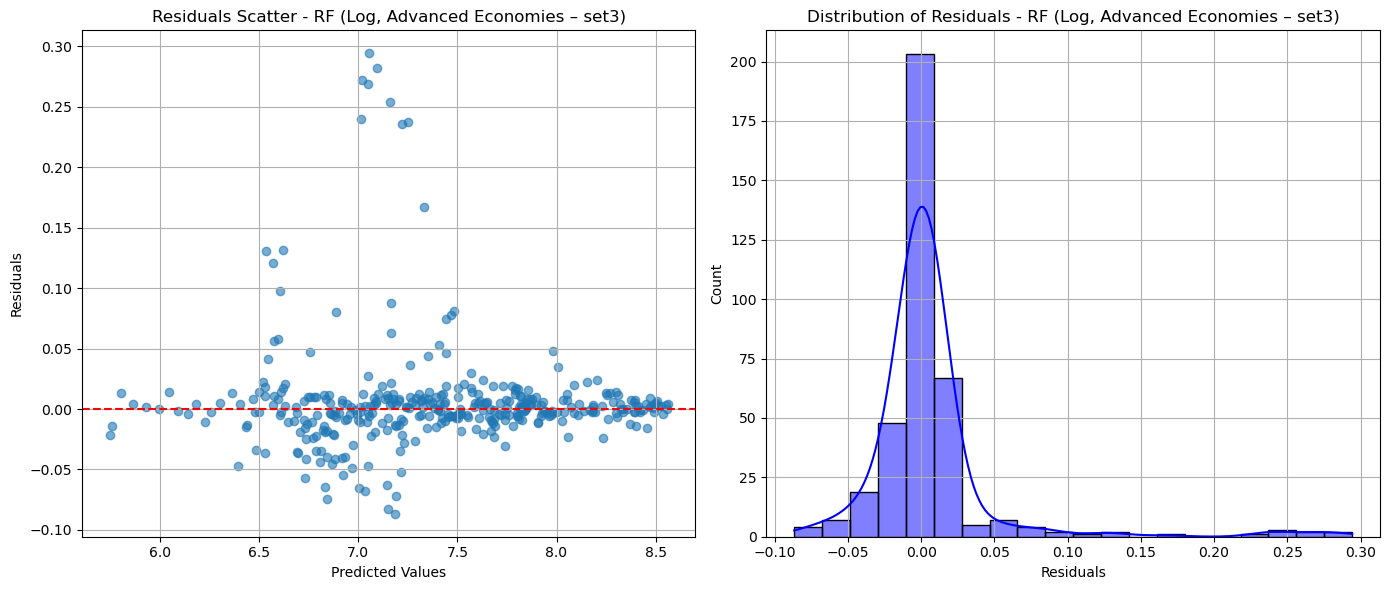


Low Income Developing Countries – set4-No Log Models 
Linear Model Test Results:
 → Test MSE: 5226.8323
 → Test R² : 0.3052

Fold 1: MSE=978.7354, R²=-2.0088
Fold 2: MSE=126.0547, R²=0.9087
Fold 3: MSE=442.7403, R²=0.6506
Fold 4: MSE=292.5088, R²=0.8065
Fold 5: MSE=11110.7056, R²=0.6522

Average MSE: 2590.1489
Average R² : 0.2019



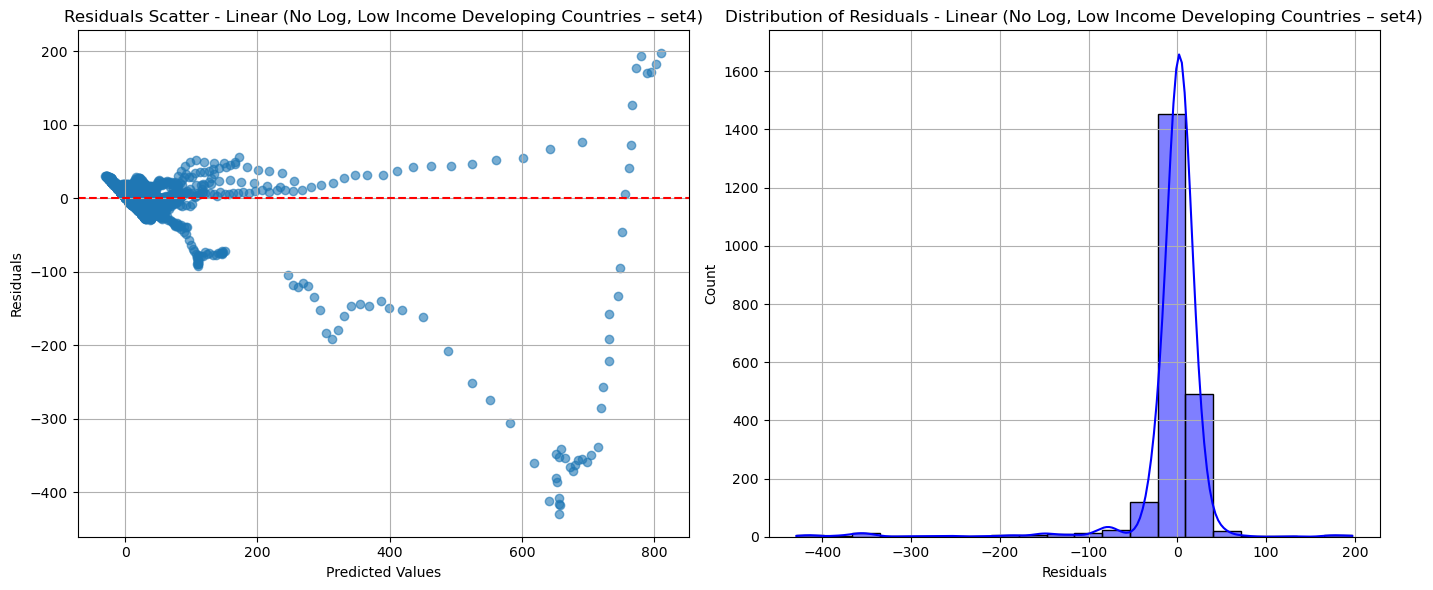

Randomforest Model Test Results:
 → Test MSE: 4916.9247
 → Test R² : 0.3464

Fold 1: MSE=94.6241, R²=0.7091
Fold 2: MSE=182.2594, R²=0.8679
Fold 3: MSE=981.3294, R²=0.2257
Fold 4: MSE=224.9941, R²=0.8512
Fold 5: MSE=4470.7832, R²=0.8601

Average MSE: 1190.7980
Average R² : 0.7028

Model does not support feature importances.


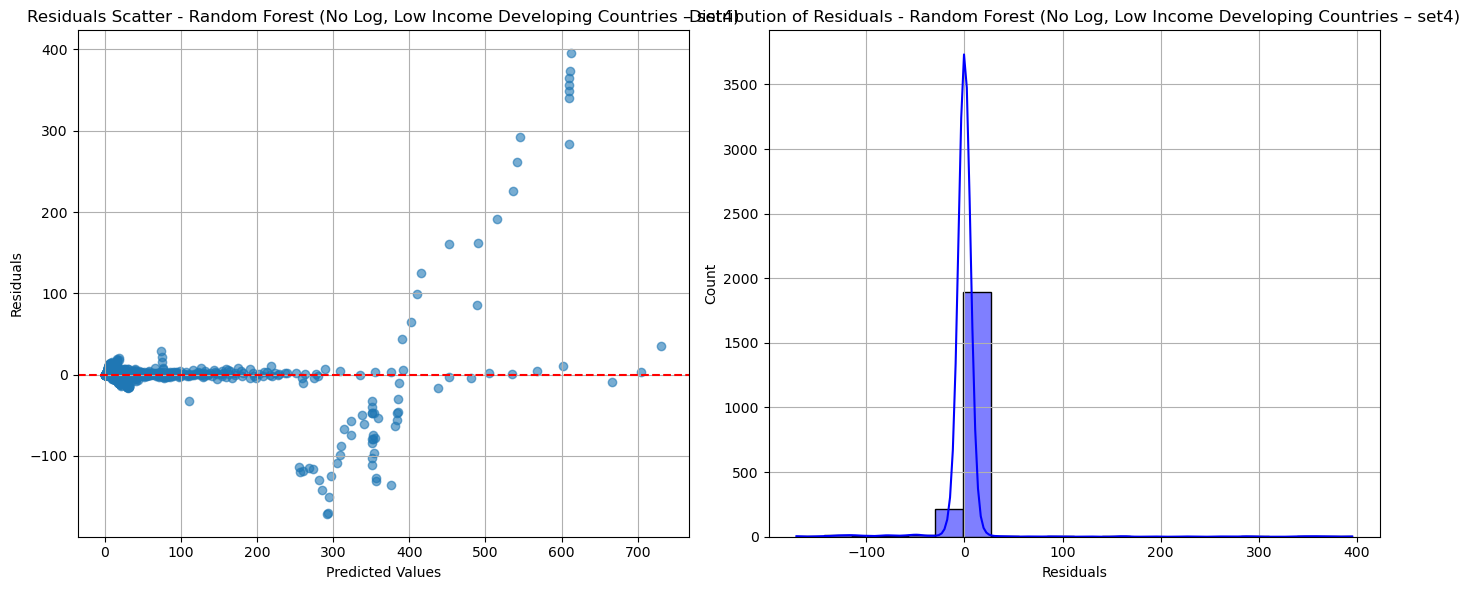


Low Income Developing Countries – set4-Log Models
Skipping Log Models for Low Income Developing Countries – set4: only 0 rows after log → need ≥ 2.

Emerging Market Economies – set4-No Log Models 
Linear Model Test Results:
 → Test MSE: 41986.8420
 → Test R² : 0.6034

Fold 1: MSE=155298.6310, R²=0.4970
Fold 2: MSE=260822.6787, R²=0.9433
Fold 3: MSE=126848.5760, R²=0.8958
Fold 4: MSE=29712.4227, R²=0.8260
Fold 5: MSE=9844.9141, R²=0.6846

Average MSE: 116505.4445
Average R² : 0.7693



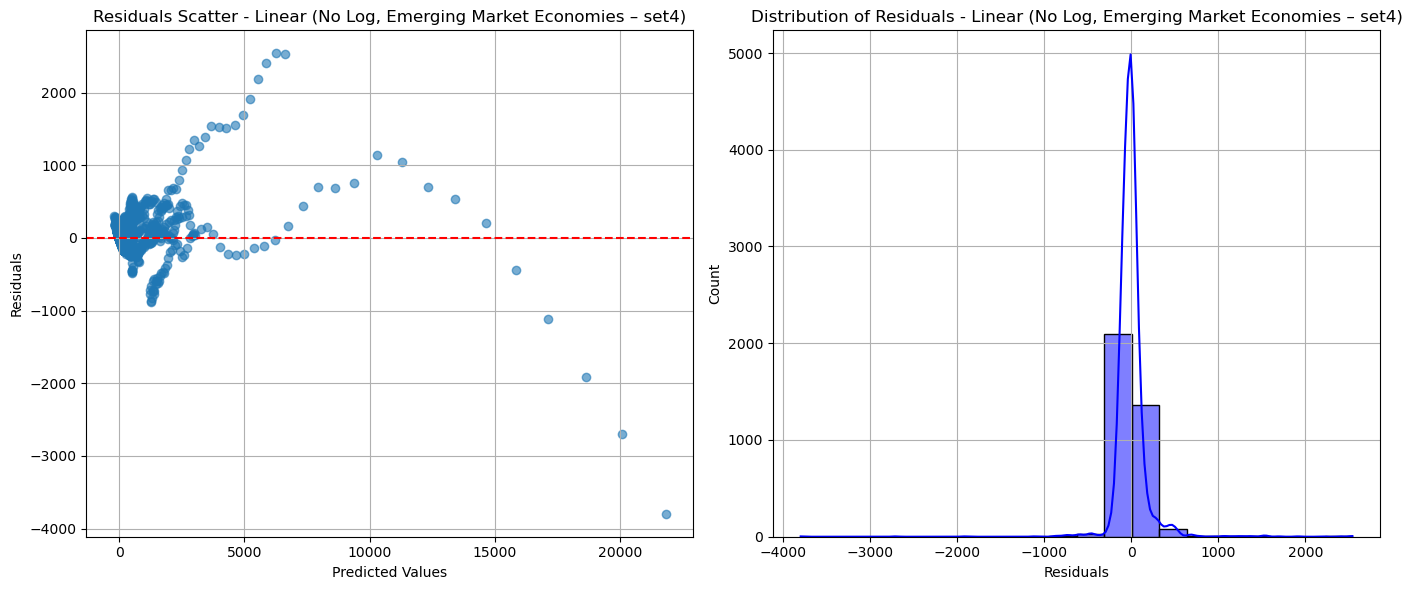

Randomforest Model Test Results:
 → Test MSE: 57446.8700
 → Test R² : 0.4574

Fold 1: MSE=164832.0327, R²=0.4662
Fold 2: MSE=2915893.2023, R²=0.3662
Fold 3: MSE=227365.2591, R²=0.8133
Fold 4: MSE=31924.7601, R²=0.8130
Fold 5: MSE=4882.7291, R²=0.8436

Average MSE: 668979.5967
Average R² : 0.6605

Model does not support feature importances.


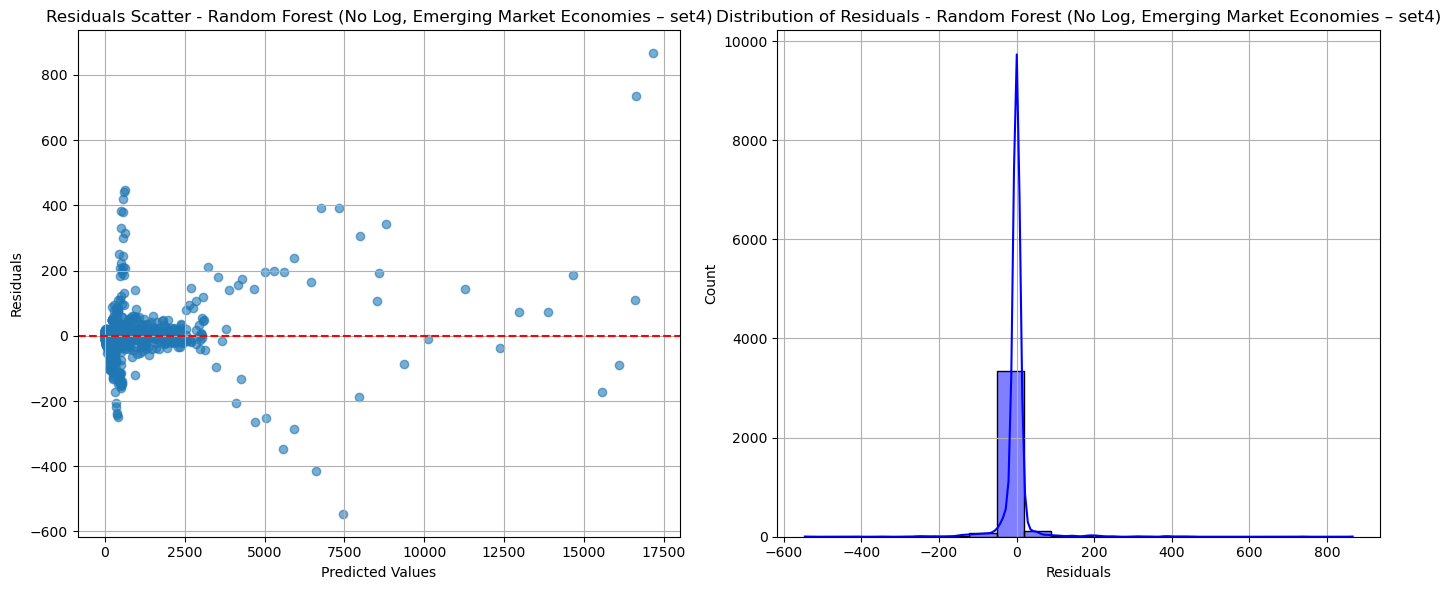


Emerging Market Economies – set4-Log Models
Linear Model Test Results:
 → Test MSE: 0.3843
 → Test R² : -2.9855

Fold 1: MSE=3.0389, R²=-8.1696
Fold 2: MSE=0.2064, R²=0.9313
Fold 3: MSE=0.1219, R²=-0.8467
Fold 4: MSE=0.2099, R²=-3.8089
Fold 5: MSE=0.0252, R²=-3545833064498279025725145088.0000

Average MSE: 0.7205
Average R² : -709166612899655832632819712.0000



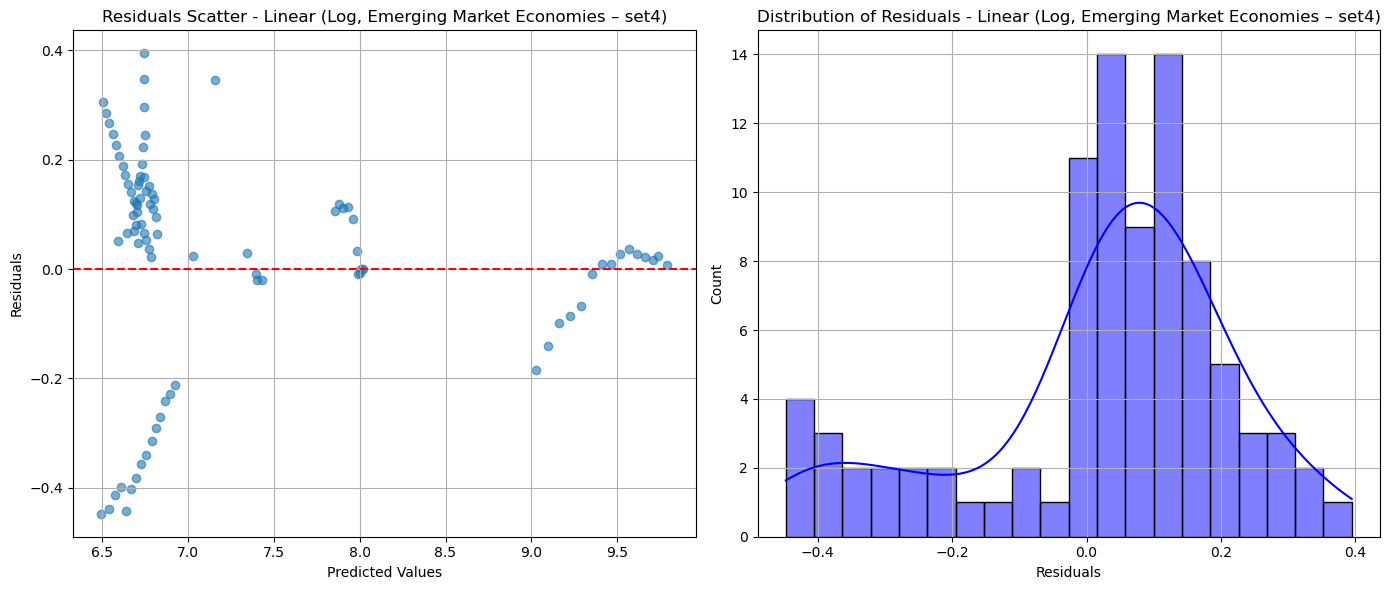

Randomforest Model Test Results:
 → Test MSE: 0.3615
 → Test R² : -2.7483

Fold 1: MSE=1.4280, R²=-3.3090
Fold 2: MSE=0.4068, R²=0.8646
Fold 3: MSE=0.1178, R²=-0.7851
Fold 4: MSE=0.1435, R²=-2.2871
Fold 5: MSE=0.0016, R²=-228212662779797618290589696.0000

Average MSE: 0.4195
Average R² : -45642532555959527094091776.0000

Model does not support feature importances.


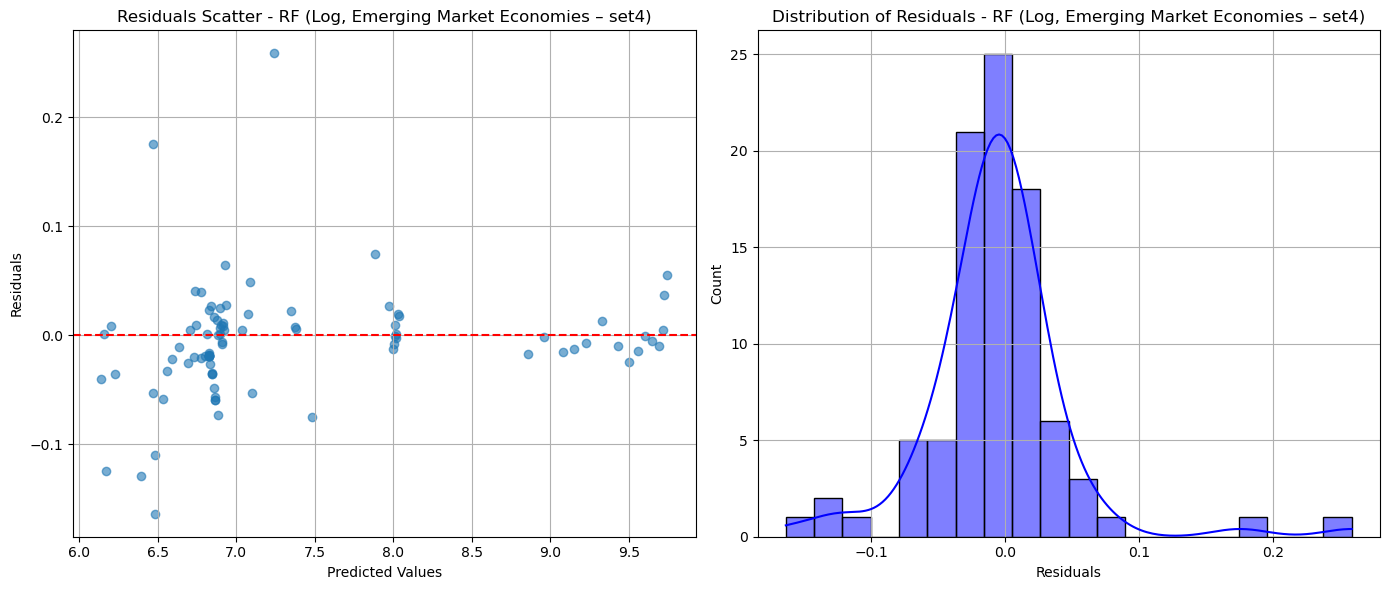


Advanced Economies – set4-No Log Models 
Linear Model Test Results:
 → Test MSE: 772754.3606
 → Test R² : 0.9570

Fold 1: MSE=61953.0573, R²=0.6657
Fold 2: MSE=219988.7170, R²=0.8745
Fold 3: MSE=1419494.0834, R²=0.4115
Fold 4: MSE=26417.5535, R²=0.5937
Fold 5: MSE=16396.6247, R²=-0.4112

Average MSE: 348850.0072
Average R² : 0.4268



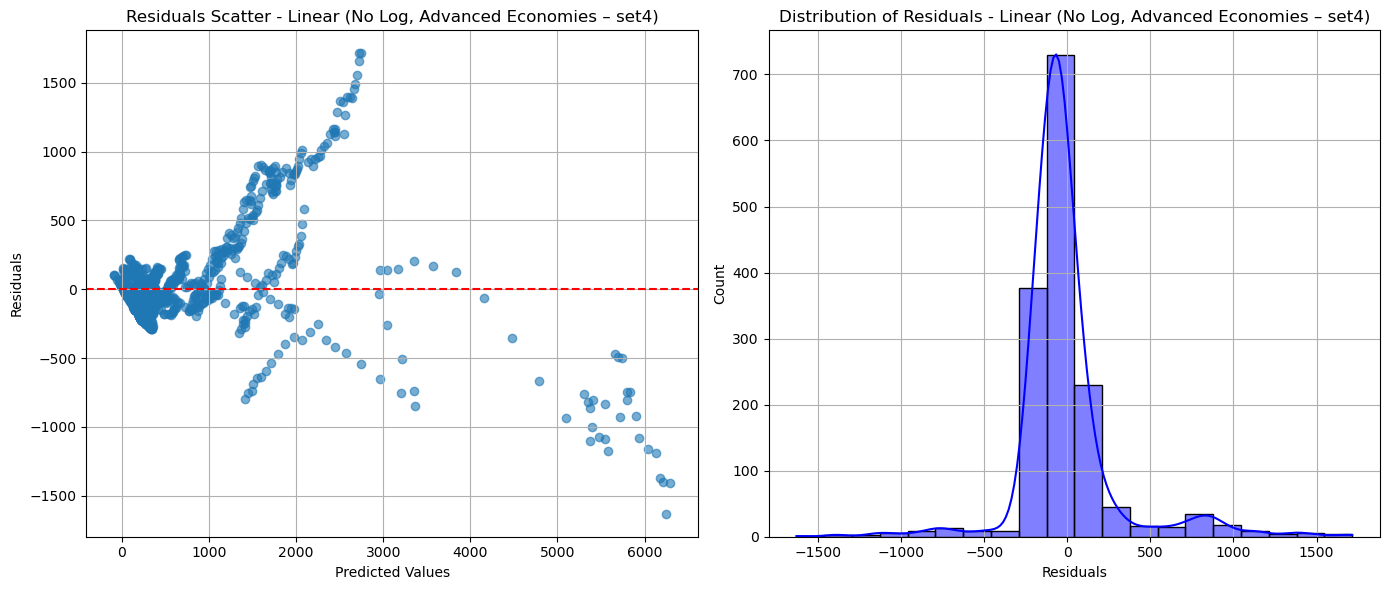

Randomforest Model Test Results:
 → Test MSE: 9519671.4333
 → Test R² : 0.4704

Fold 1: MSE=14061.7739, R²=0.9241
Fold 2: MSE=480679.9151, R²=0.7258
Fold 3: MSE=146331.8107, R²=0.9393
Fold 4: MSE=5920.5478, R²=0.9089
Fold 5: MSE=5030.5745, R²=0.5670

Average MSE: 130404.9244
Average R² : 0.8130

Model does not support feature importances.


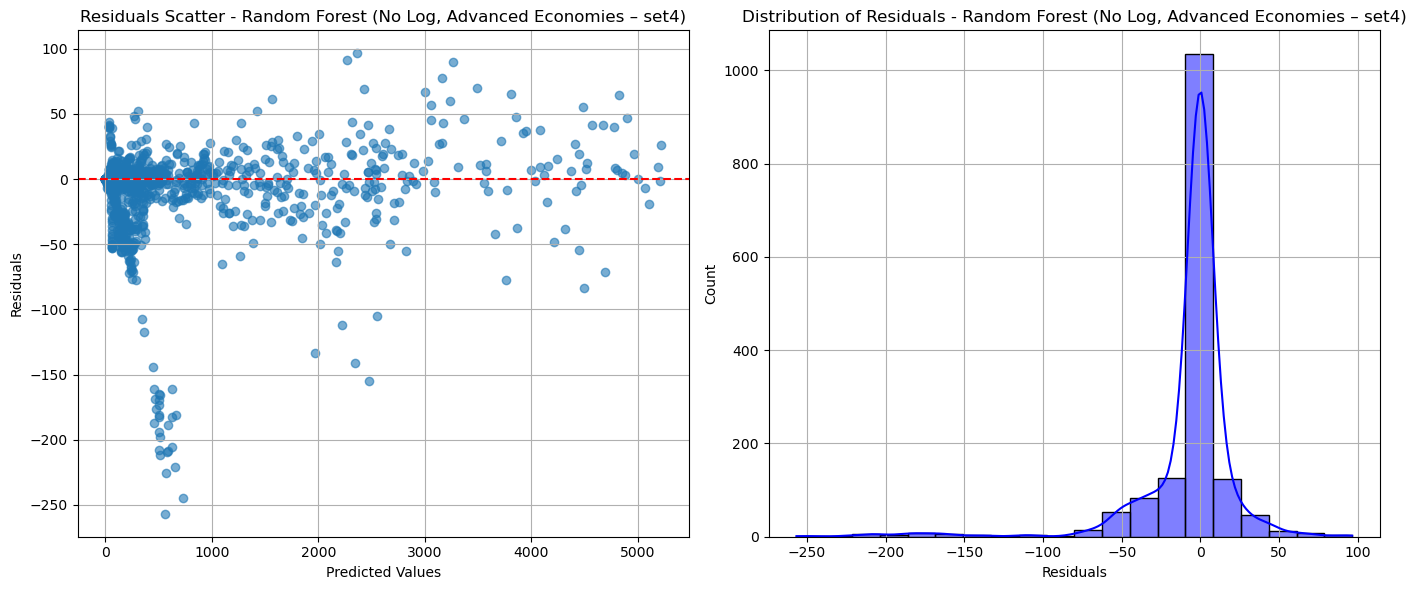


Advanced Economies – set4-Log Models
Linear Model Test Results:
 → Test MSE: 0.0570
 → Test R² : 0.9148

Fold 1: MSE=0.4486, R²=-1.9489
Fold 2: MSE=0.2069, R²=-0.3818
Fold 3: MSE=0.0316, R²=0.8488
Fold 4: MSE=0.4599, R²=-0.1893
Fold 5: MSE=0.0094, R²=0.9005

Average MSE: 0.2313
Average R² : -0.1541



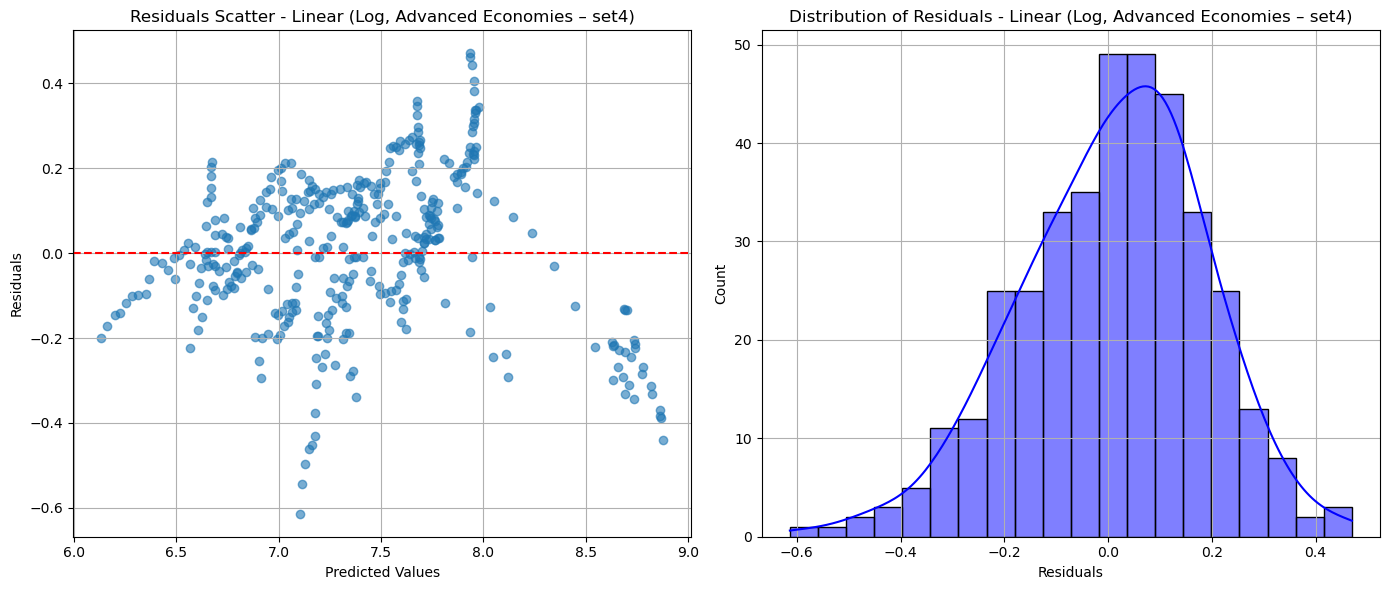

Randomforest Model Test Results:
 → Test MSE: 0.4707
 → Test R² : 0.2959

Fold 1: MSE=0.7337, R²=-3.8233
Fold 2: MSE=0.0624, R²=0.5833
Fold 3: MSE=0.0385, R²=0.8158
Fold 4: MSE=0.0461, R²=0.8807
Fold 5: MSE=0.0681, R²=0.2766

Average MSE: 0.1898
Average R² : -0.2534

Model does not support feature importances.


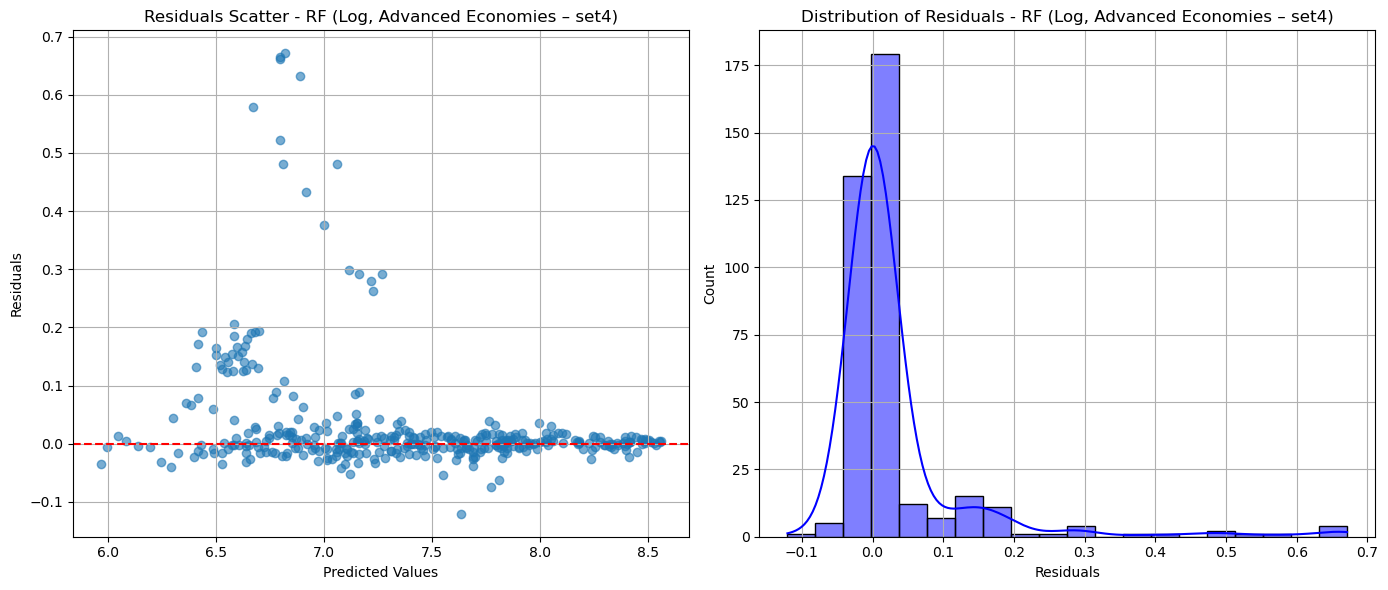

In [52]:

for set_name, feat in features_sets.items():
    for grp, df_grp in panel_1_groups.items():
        all_results += evaluate_dataset(
            df_grp.reset_index(),
            dataset_label=f"{grp} – {set_name}",
            features=feat,
            features_to_log=feat,
            is_panel=False
        )


We compile all individual model evaluation results into a single DataFrame, allowing easy comparison across datasets, feature sets, and modeling approaches.


In [53]:
df_results = pd.DataFrame(all_results)
display(df_results.sort_values(['Dataset','Model']).reset_index(drop=True))


Dataset                   Model   
0                Advanced Economies – set1            Linear (Log)  \
1                Advanced Economies – set1         Linear (No Log)   
2                Advanced Economies – set1     Random Forest (Log)   
3                Advanced Economies – set1  Random Forest (No Log)   
4                Advanced Economies – set2            Linear (Log)   
5                Advanced Economies – set2         Linear (No Log)   
6                Advanced Economies – set2     Random Forest (Log)   
7                Advanced Economies – set2  Random Forest (No Log)   
8                Advanced Economies – set3            Linear (Log)   
9                Advanced Economies – set3         Linear (No Log)   
10               Advanced Economies – set3     Random Forest (Log)   
11               Advanced Economies – set3  Random Forest (No Log)   
12               Advanced Economies – set4            Linear (Log)   
13               Advanced Economies – set4         Linear (No Log)   
14               Advanced Economies – set4     Random Forest (Log)   
15               Advanced Economies – set4  Random Forest (No Log)   
16        Emerging Market Economies – set1            Linear (Log)   
17        Emerging Market Economies – set1         Linear (No Log)   
18        Emerging Market Economies – set1     Random Forest (Log)   
19        Emerging Market Economies – set1  Random Forest (No Log)   
20        Emerging Market Economies – set2            Linear (Log)   
21        Emerging Market Economies – set2         Linear (No Log)   
22        Emerging Market Economies – set2     Random Forest (Log)   
23        Emerging Market Economies – set2  Random Forest (No Log)   
24        Emerging Market Economies – set3            Linear (Log)   
25        Emerging Market Economies – set3         Linear (No Log)   
26        Emerging Market Economies – set3     Random Forest (Log)   
27        Emerging Market Economies – set3  Random Forest (No Log)   
28        Emerging Market Economies – set4            Linear (Log)   
29        Emerging Market Economies – set4         Linear (No Log)   
30        Emerging Market Economies – set4     Random Forest (Log)   
31        Emerging Market Economies – set4  Random Forest (No Log)   
32                             Full – set1            Linear (Log)   
33                             Full – set1         Linear (No Log)   
34                             Full – set1     Random Forest (Log)   
35                             Full – set1  Random Forest (No Log)   
36                             Full – set2            Linear (Log)   
37                             Full – set2         Linear (No Log)   
38                             Full – set2     Random Forest (Log)   
39                             Full – set2  Random Forest (No Log)   
40                             Full – set3            Linear (Log)   
41                             Full – set3         Linear (No Log)   
42                             Full – set3     Random Forest (Log)   
43                             Full – set3  Random Forest (No Log)   
44                             Full – set4            Linear (Log)   
45                             Full – set4         Linear (No Log)   
46                             Full – set4     Random Forest (Log)   
47                             Full – set4  Random Forest (No Log)   
48  Low Income Developing Countries – set1            Linear (Log)   
49  Low Income Developing Countries – set1         Linear (No Log)   
50  Low Income Developing Countries – set1     Random Forest (Log)   
51  Low Income Developing Countries – set1  Random Forest (No Log)   
52  Low Income Developing Countries – set2            Linear (Log)   
53  Low Income Developing Countries – set2         Linear (No Log)   
54  Low Income Developing Countries – set2     Random Forest (Log)   
55  Low Income Developing Countries – set2  Random Forest (No Log)   
56  Low Income Developing Countries – set3   

The model comparison shows that Linear models without log transformation generally perform the best across datasets, especially for Advanced Economies and the Full sample, achieving high R² scores (around 0.95). Log-transformed models help in some cases, like Emerging Market Economies set1, but often reduce performance, especially in weaker feature sets (set3 and set4). Random Forest models show moderate performance but are less consistent, particularly with log-transformed targets. To clean the results, duplicate rows were removed, and the "Dataset" column was split into "Group" and "Feature Set" to allow structured analysis. Feature sets and models were also ordered categorically to ensure consistent sorting and plotting.

In [54]:

df_clean = (
    df_results
    .drop_duplicates(subset=['Dataset','Model','MSE','R2'])
    .reset_index(drop=True)
    .copy()
)

df_clean.loc[:, 'Group'] = df_clean['Dataset'].str.rsplit(' – ', n=1).str[0]
df_clean.loc[:, 'Feature_Set'] = df_clean['Dataset'].str.rsplit(' – ', n=1).str[-1]

feat_order  = ['set1','set2','set3','set4']
model_order = ['Linear (No Log)','Random Forest (No Log)','Linear (Log)','Random Forest (Log)']

df_clean.loc[:, 'Feature_Set'] = pd.Categorical(df_clean['Feature_Set'],
                                               categories=feat_order, ordered=True)
df_clean.loc[:, 'Model']       = pd.Categorical(df_clean['Model'],
                                               categories=model_order, ordered=True)


This step generates pivot tables for each income group, displaying maximum R² values across feature sets and models to facilitate a structured performance comparison.


In [55]:
group_tables = {}
for grp, sub in df_clean.groupby('Group', sort=True):
    pivot = sub.pivot_table(
        index='Model',
        columns='Feature_Set',
        values='R2',
        aggfunc='max'
    )
    group_tables[grp] = pivot
    
    print(f"\n{grp}")
    display(pivot)


Advanced Economies


Feature_Set              set1   set2    set3    set4
Model                                               
Linear (Log)           0.8723 0.9206  0.1378 -0.1541
Linear (No Log)        0.9523 0.9607  0.9209  0.4268
Random Forest (Log)    0.6221 0.7570 -0.0217 -0.2534
Random Forest (No Log) 0.9124 0.9026  0.8894  0.8130


Emerging Market Economies


Feature_Set              set1   set2    set3                              set4
Model                                                                         
Linear (Log)           0.9471 0.7515 -0.4874 -709166612899655832632819712.0000
Linear (No Log)        0.7300 0.7209  0.7381                            0.7693
Random Forest (Log)    0.8992 0.5534 -0.0743  -45642532555959527094091776.0000
Random Forest (No Log) 0.6602 0.6413  0.6292                            0.6605


Full


Feature_Set              set1   set2   set3   set4
Model                                             
Linear (Log)           0.9564 0.9433 0.4656 0.5696
Linear (No Log)        0.8958 0.8929 0.8882 0.8349
Random Forest (Log)    0.9282 0.9011 0.4487 0.3263
Random Forest (No Log) 0.7228 0.7187 0.7180 0.6514


Low Income Developing Countries


Feature_Set              set1       set2   set3   set4
Model                                                 
Linear (Log)           0.7737 -1433.1314    NaN    NaN
Linear (No Log)        0.8431     0.8454 0.6407 0.2019
Random Forest (Log)    0.7647    -0.1326    NaN    NaN
Random Forest (No Log) 0.7445     0.8054 0.8284 0.7028

For Advanced Economies, Linear (No Log) models outperformed other models across feature sets, with Random Forest being competitive in the first two sets. In Emerging Market Economies, Linear (Log) performed well in the first set but struggled in later sets due to instability, while Linear (No Log) remained steady. The Full dataset showed consistent performance for Linear (Log), while Random Forest models were generally weaker, especially in the latter sets. Low Income Developing Countries had stable performance with Linear (No Log), though log models were unstable or non-applicable in some sets.



Here, we restructure the evaluation results by feature set, creating pivot tables that compare R² scores across different income groups. 


In [56]:
set_tables = {}
for fs, sub in df_clean.groupby('Feature_Set', sort=True):
    pivot = sub.pivot_table(
        index='Model',
        columns='Group',
        values='R2',
        aggfunc='max'
    )
    set_tables[fs] = pivot
    
    print(f"\n{fs}")
    display(pivot)



set1


Group                   Advanced Economies  Emerging Market Economies   Full   
Model                                                                          
Linear (Log)                        0.8723                     0.9471 0.9564  \
Linear (No Log)                     0.9523                     0.7300 0.8958   
Random Forest (Log)                 0.6221                     0.8992 0.9282   
Random Forest (No Log)              0.9124                     0.6602 0.7228   

Group                   Low Income Developing Countries  
Model                                                    
Linear (Log)                                     0.7737  
Linear (No Log)                                  0.8431  
Random Forest (Log)                              0.7647  
Random Forest (No Log)                           0.7445


set2


Group                   Advanced Economies  Emerging Market Economies   Full   
Model                                                                          
Linear (Log)                        0.9206                     0.7515 0.9433  \
Linear (No Log)                     0.9607                     0.7209 0.8929   
Random Forest (Log)                 0.7570                     0.5534 0.9011   
Random Forest (No Log)              0.9026                     0.6413 0.7187   

Group                   Low Income Developing Countries  
Model                                                    
Linear (Log)                                 -1433.1314  
Linear (No Log)                                  0.8454  
Random Forest (Log)                             -0.1326  
Random Forest (No Log)                           0.8054


set3


Group                   Advanced Economies  Emerging Market Economies   Full   
Model                                                                          
Linear (Log)                        0.1378                    -0.4874 0.4656  \
Linear (No Log)                     0.9209                     0.7381 0.8882   
Random Forest (Log)                -0.0217                    -0.0743 0.4487   
Random Forest (No Log)              0.8894                     0.6292 0.7180   

Group                   Low Income Developing Countries  
Model                                                    
Linear (Log)                                        NaN  
Linear (No Log)                                  0.6407  
Random Forest (Log)                                 NaN  
Random Forest (No Log)                           0.8284


set4


Group                   Advanced Economies         Emerging Market Economies   
Model                                                                          
Linear (Log)                       -0.1541 -709166612899655832632819712.0000  \
Linear (No Log)                     0.4268                            0.7693   
Random Forest (Log)                -0.2534  -45642532555959527094091776.0000   
Random Forest (No Log)              0.8130                            0.6605   

Group                    Full  Low Income Developing Countries  
Model                                                           
Linear (Log)           0.5696                              NaN  
Linear (No Log)        0.8349                           0.2019  
Random Forest (Log)    0.3263                              NaN  
Random Forest (No Log) 0.6514                           0.7028

For Advanced Economies, Linear (No Log) models consistently outperformed other models across feature sets, with Random Forest being competitive in the first two sets. In Emerging Market Economies, Linear (Log) performed well in the first set but struggled in later sets due to instability, while Linear (No Log) remained steady. The Full dataset showed consistent performance with Linear (Log), while Random Forest models were generally weaker, especially in later sets. For Low Income Developing Countries, Linear (No Log) exhibited stable performance, while log models were unstable or not applicable in some feature sets.




Here, we plot the R² results for each income group, with models compared across different feature sets.


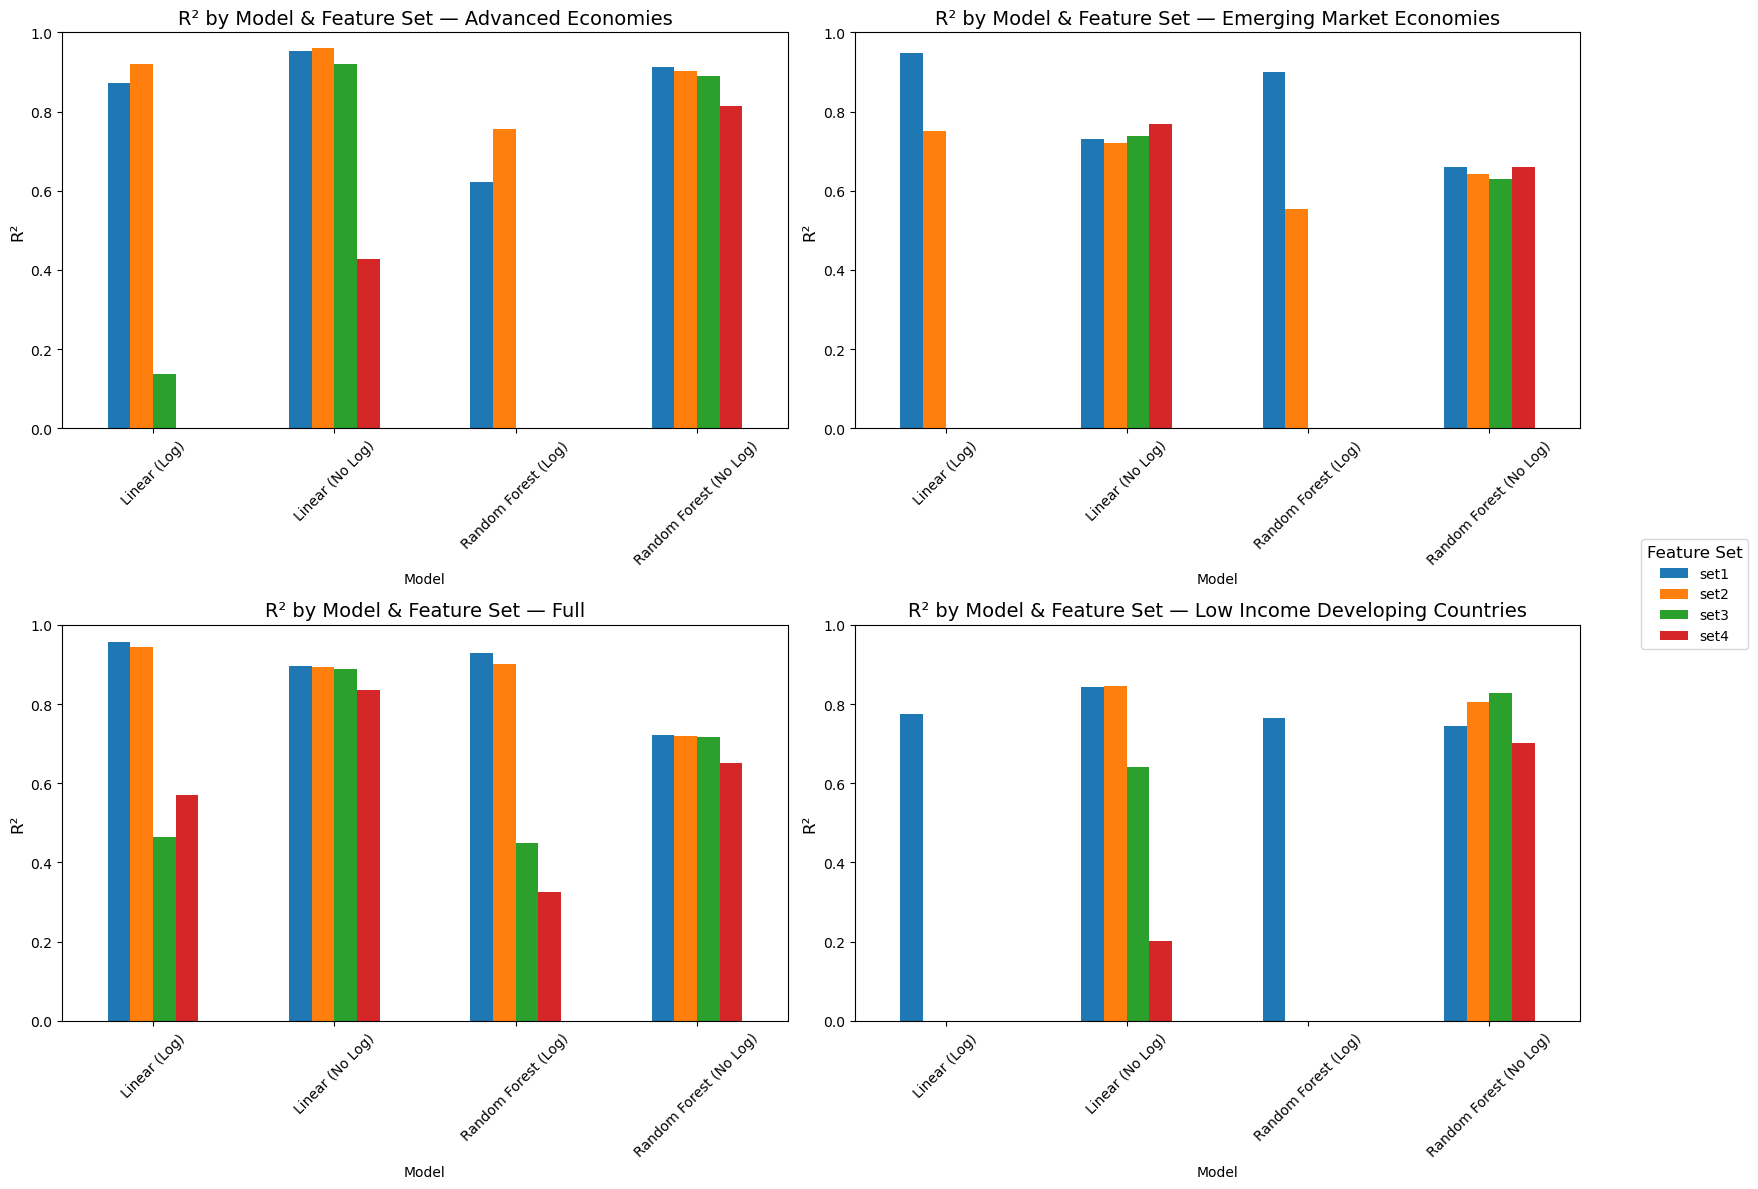

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12)) 
axs = axs.flatten()

for idx, (grp, pivot) in enumerate(group_tables.items()):
    pivot.plot.bar(ax=axs[idx], legend=False)  
    axs[idx].set_title(f'R² by Model & Feature Set — {grp}', fontsize=14)
    axs[idx].set_ylim(0,1)
    axs[idx].set_ylabel('R²', fontsize=12)
    axs[idx].tick_params(axis='x', rotation=45)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Feature Set',
    loc='center right',
    bbox_to_anchor=(1.1, 0.5),
    fontsize=10,
    title_fontsize=12
)

fig.tight_layout()
plt.show()


We generate bar plots to compare R² values across different income groups for each feature set. 



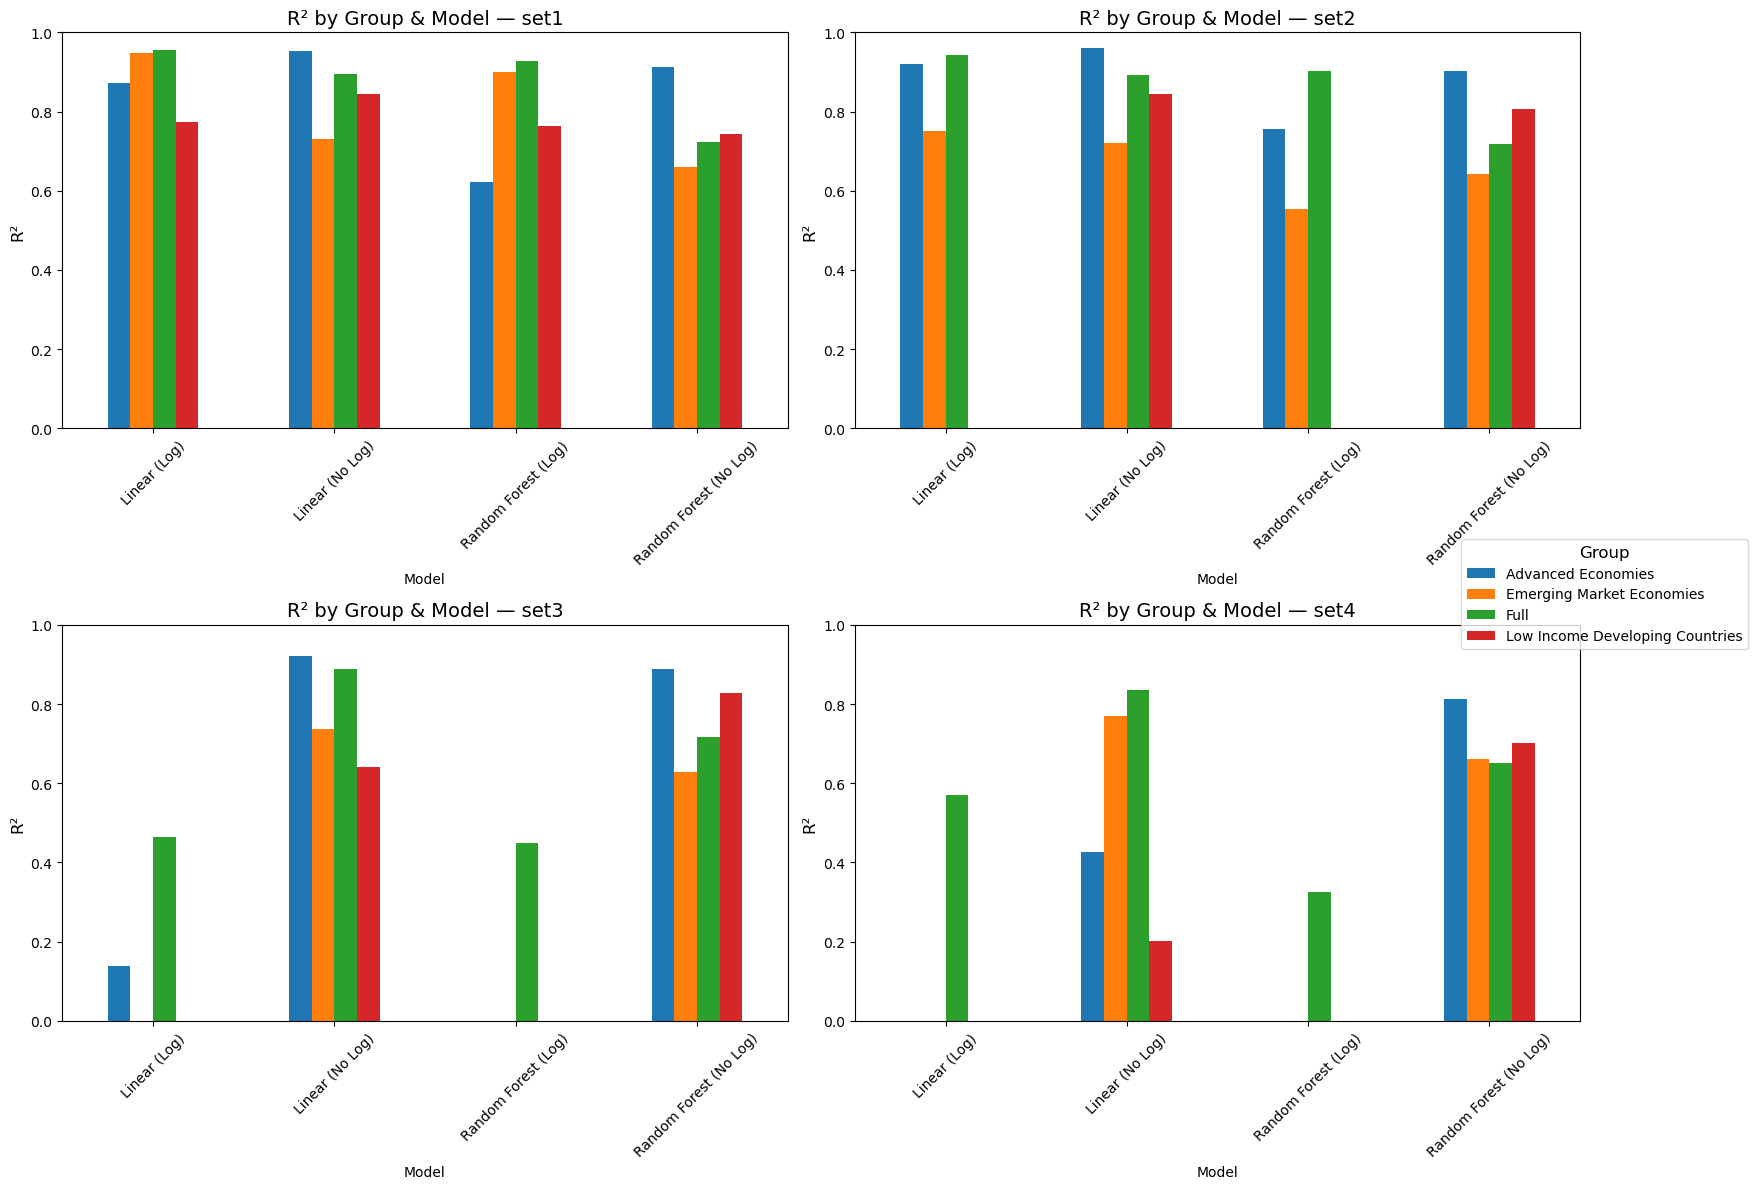

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12)) 
axs = axs.flatten()

for idx, (fs, pivot) in enumerate(set_tables.items()):
    pivot.plot.bar(ax=axs[idx], legend=False) 
    axs[idx].set_title(f'R² by Group & Model — {fs}', fontsize=14)
    axs[idx].set_ylim(0,1)
    axs[idx].set_ylabel('R²', fontsize=12)
    axs[idx].tick_params(axis='x', rotation=45)


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Group',
    loc='center right',
    bbox_to_anchor=(1.1, 0.5),
    fontsize=10,
    title_fontsize=12
)

fig.tight_layout()
plt.show()


We define a function to find and display the best-performing model within each group, based on the highest R² score.


In [59]:
def print_best(df, group_by, metric='R2'):

    idx = df.groupby(group_by)[metric].idxmax()
    best = df.loc[idx].reset_index(drop=True)
    display(best[[*([group_by] if isinstance(group_by, str) else group_by),
                 'Dataset','Feature_Set','Model',metric]])


In [60]:
print("Best Model and Set for each Income‐Group:")
print_best(df_clean, 'Group')

print("\nBest Model and Group for each Feature_Set:")
print_best(df_clean, 'Feature_Set')

print("\nBest Dataset and Set for each Model:")
print_best(df_clean, 'Model')


Best Model and Set for each Income‐Group:


Group                                 Dataset   
0               Advanced Economies               Advanced Economies – set2  \
1        Emerging Market Economies        Emerging Market Economies – set1   
2                             Full                             Full – set1   
3  Low Income Developing Countries  Low Income Developing Countries – set2   

  Feature_Set            Model     R2  
0        set2  Linear (No Log) 0.9607  
1        set1     Linear (Log) 0.9471  
2        set1     Linear (Log) 0.9564  
3        set2  Linear (No Log) 0.8454


Best Model and Group for each Feature_Set:


Feature_Set                    Dataset Feature_Set            Model     R2
0        set1                Full – set1        set1     Linear (Log) 0.9564
1        set2  Advanced Economies – set2        set2  Linear (No Log) 0.9607
2        set3  Advanced Economies – set3        set3  Linear (No Log) 0.9209
3        set4                Full – set4        set4  Linear (No Log) 0.8349


Best Dataset and Set for each Model:


Model                    Dataset Feature_Set   
0            Linear (Log)                Full – set1        set1  \
1         Linear (No Log)  Advanced Economies – set2        set2   
2     Random Forest (Log)                Full – set1        set1   
3  Random Forest (No Log)  Advanced Economies – set1        set1   

                    Model     R2  
0            Linear (Log) 0.9564  
1         Linear (No Log) 0.9607  
2     Random Forest (Log) 0.9282  
3  Random Forest (No Log) 0.9124

For Advanced Economies, the best model was Linear (No Log) with set2, achieving an R² of 0.9607, while for Emerging Market Economies, Linear (Log) with set1 performed best with an R² of 0.9471. In the Full dataset, Linear (Log) with set1 was the most effective model, yielding an R² of 0.9564. For Low Income Developing Countries, Linear (No Log) with set2 had the highest R² of 0.8454. When comparing across feature sets, set1 from the Full dataset and Linear (Log) achieved the best performance, with an R² of 0.9564, while set2 from the Advanced Economies dataset performed best for Linear (No Log) with an R² of 0.9607. Lastly, for best dataset and model combinations, Linear (Log) performed excellently with Full – set1 (R² = 0.9564), while Random Forest (Log) performed best with Full – set1 and set1 (R² = 0.9285).



***PLoT SHAP values and PDP for Each Income Group***

We define a function to plot partial dependence curves, showing how individual features impact model predictions while holding other variables constant.


In [61]:
def plot_pdp(model, X_train, features, feature_names, model_label="Model"):
    if hasattr(model, "predict"):
        plt.figure(figsize=(14, 6))
        display = PartialDependenceDisplay.from_estimator(
            model, 
            X_train, 
            features=[feature_names.index(f) for f in features],
            feature_names=feature_names,
            kind="average",
            n_cols=2
        )
        plt.suptitle(f'Partial Dependence Plots - {model_label}', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Model {model_label} does not support PDP.")


We define a function to generate SHAP summary plots, which explain how each feature contributes to model predictions.


In [62]:

def plot_shap(model, X_train, feature_names, model_label="Model"):
    if hasattr(model, "feature_importances_"):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train)

        shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar", show=True)
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=True)
    else:
        print(f"Model {model_label} does not support SHAP plotting.")


We define a function to perform randomized hyperparameter search for Random Forest models using time-series cross-validation.


In [63]:
def tune_random_forest(X, y, group_name="Group", random_state=42, n_iter=10):
    print(f"\nHyperparameter Tuning (Random Forest) for {group_name} ")
    param_dist = {
        'max_depth': [4, 6, 8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
    rs = RandomizedSearchCV(
        rf, param_distributions=param_dist,
        n_iter=n_iter, cv=TimeSeriesSplit(3), scoring='r2', n_jobs=-1, random_state=random_state
    )
    rs.fit(X, y)
    print("Best Params:", rs.best_params_)
    print(f"Best R² Score: {rs.best_score_:.4f}\n")
    return rs.best_estimator_

We define a function to automatically tune a Random Forest model for each income group, applying randomized search to find the best hyperparameters and storing the optimized models for future use.


In [64]:
def auto_tune_all_groups(groups_data, log_features):
    models = {}
    for group_name, (X, y) in groups_data.items():
        model = tune_random_forest(X, y, group_name=group_name)
        models[group_name] = model
    return models


We define a function to automatically generate partial dependence plots (PDP) and SHAP summary plots for each tuned Random Forest model across groups, helping to interpret how key features impact predictions for different segments.


In [65]:
def auto_pdp_shap_all_groups(tuned_models, groups_data, log_features):
    for group_name, model in tuned_models.items():
        print(f"\nPDP and SHAP for {group_name} ")
        X, _ = groups_data[group_name]

        plot_pdp(
            model,
            X,
            features=['log_priv_capital', 'log_labor_force'],
            feature_names=log_features,
            model_label=f"Random Forest Tuned - {group_name}"
        )

        plot_shap(
            model,
            X,
            feature_names=log_features,
            model_label=f"Random Forest Tuned - {group_name}"
        )

We build separate Random Forest models for Low Income Developing Countries, Emerging Market Economies, and Advanced Economies.


In [66]:

simple_features = ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force']
log_features = [f'log_{col}' for col in simple_features]

print("Low Income Developing Countries:")
df_low = df_cleaned[df_cleaned['income_group'] == 'Low Income Developing Countries']
df_low_log = log_transform_features(df_low, simple_features, target_to_log='GDP_rppp')
model_rf_log_low, X_train_rf_log_low, y_train_rf_log_low = train_test_models(df_low_log, log_features, target='log_GDP_rppp', model_type='randomforest')

print("\nEmerging Market Countries:")
df_emerging = df_cleaned[df_cleaned['income_group'] == 'Emerging Market Economies']
df_emerging_log = log_transform_features(df_emerging, simple_features, target_to_log='GDP_rppp')
model_rf_log_emerging, X_train_rf_log_emerging, y_train_rf_log_emerging = train_test_models(df_emerging_log, log_features, target='log_GDP_rppp', model_type='randomforest')

print("\nAdvanced Economies Countries:")
df_advanced = df_cleaned[df_cleaned['income_group'] == 'Advanced Economies']
df_advanced_log = log_transform_features(df_advanced, simple_features, target_to_log='GDP_rppp')
model_rf_log_advanced, X_train_rf_log_advanced, y_train_rf_log_advanced = train_test_models(df_advanced_log, log_features, target='log_GDP_rppp', model_type='randomforest')


Low Income Developing Countries:
Randomforest Model Test Results:
 → Test MSE: 0.3564
 → Test R² : 0.7376


Emerging Market Countries:
Randomforest Model Test Results:
 → Test MSE: 0.1948
 → Test R² : 0.9581


Advanced Economies Countries:
Randomforest Model Test Results:
 → Test MSE: 0.1549
 → Test R² : 0.9487



**PLOTTING PDP & SHAP VALUE FOR THREE INCOME GROUPS**

<Figure size 1400x600 with 0 Axes>

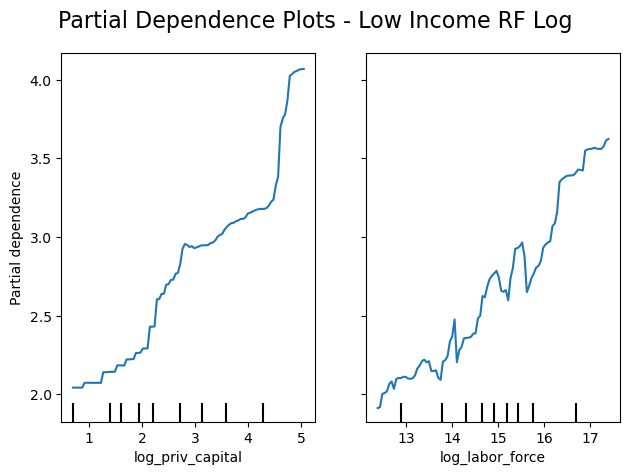

Model Low Income RF Log does not support SHAP plotting.


<Figure size 1400x600 with 0 Axes>

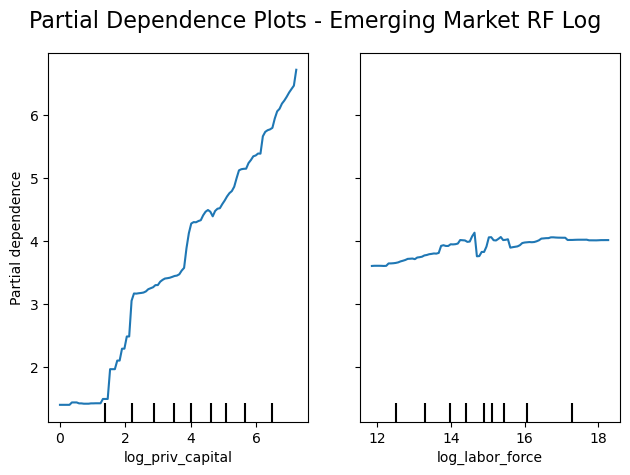

Model Emerging Market RF Log does not support SHAP plotting.


<Figure size 1400x600 with 0 Axes>

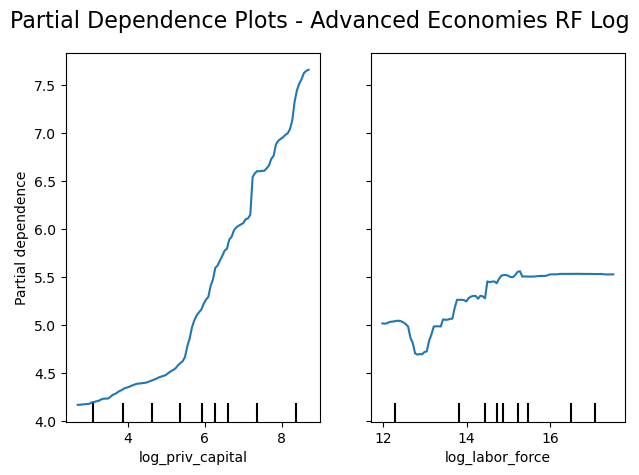

Model Advanced Economies RF Log does not support SHAP plotting.


In [67]:
plot_pdp(model_rf_log_low, X_train_rf_log_low, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Low Income RF Log")
plot_shap(model_rf_log_low, X_train_rf_log_low, feature_names=log_features, model_label="Low Income RF Log")

plot_pdp(model_rf_log_emerging, X_train_rf_log_emerging, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Emerging Market RF Log")
plot_shap(model_rf_log_emerging, X_train_rf_log_emerging, feature_names=log_features, model_label="Emerging Market RF Log")

plot_pdp(model_rf_log_advanced, X_train_rf_log_advanced, features=['log_priv_capital', 'log_labor_force'], feature_names=log_features, model_label="Advanced Economies RF Log")
plot_shap(model_rf_log_advanced, X_train_rf_log_advanced, feature_names=log_features, model_label="Advanced Economies RF Log")


We apply log transformations to key capital and labor variables for each income group and extract the corresponding feature matrices and target vectors.


In [68]:
log_features = ['log_priv_capital', 'log_gov_capital', 'log_ppp_capital', 'log_labor_force']

df_low_log = log_transform_features(df_low, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')
df_emerging_log = log_transform_features(df_emerging, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')
df_advanced_log = log_transform_features(df_advanced, ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force'], target_to_log='GDP_rppp')

X_low_log = df_low_log[log_features]
y_low_log = df_low_log['log_GDP_rppp']

X_emerging_log = df_emerging_log[log_features]
y_emerging_log = df_emerging_log['log_GDP_rppp']

X_advanced_log = df_advanced_log[log_features]
y_advanced_log = df_advanced_log['log_GDP_rppp']



We organize the log-transformed datasets into a dictionary by income group and run automated hyperparameter tuning to build optimized Random Forest models tailored for each group.


In [69]:
groups_data = {
    'Low Income Developing Countries': (X_low_log, y_low_log),
    'Emerging Market Economies': (X_emerging_log, y_emerging_log),
    'Advanced Economies': (X_advanced_log, y_advanced_log)
}

tuned_models = auto_tune_all_groups(groups_data, log_features)



Hyperparameter Tuning (Random Forest) for Low Income Developing Countries 
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 12}
Best R² Score: 0.8142


Hyperparameter Tuning (Random Forest) for Emerging Market Economies 
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10}
Best R² Score: 0.9283


Hyperparameter Tuning (Random Forest) for Advanced Economies 
Best Params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 8}
Best R² Score: 0.9359



We generate Partial Dependence Plots and SHAP summary plots for each tuned Random Forest model, helping to visualize how key features influence log-transformed GDP predictions across different income groups.



PDP and SHAP for Low Income Developing Countries 


<Figure size 1400x600 with 0 Axes>

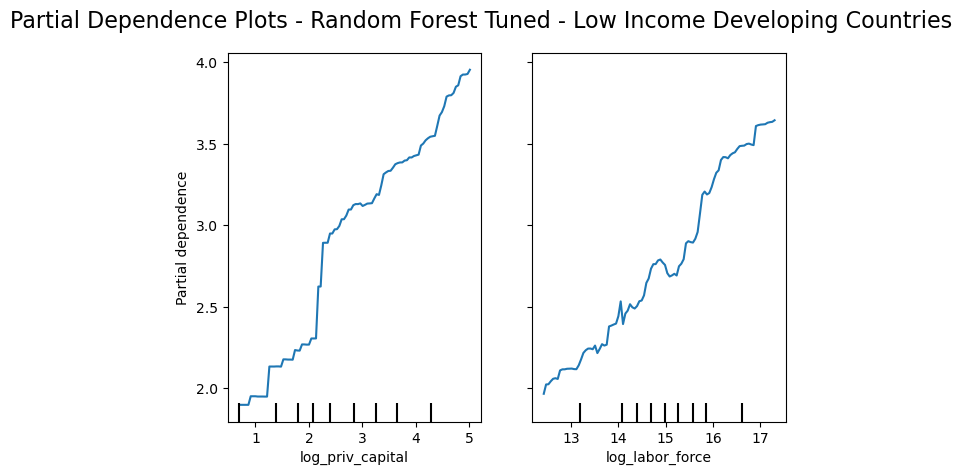

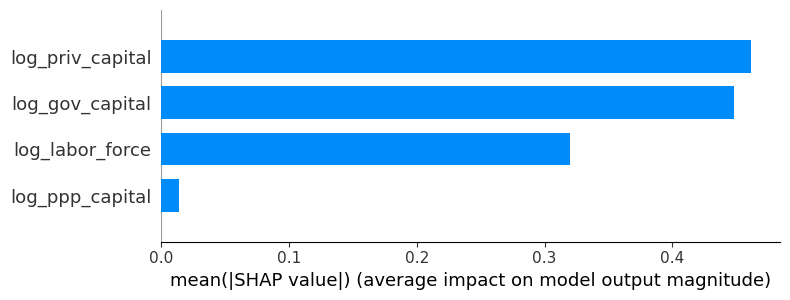

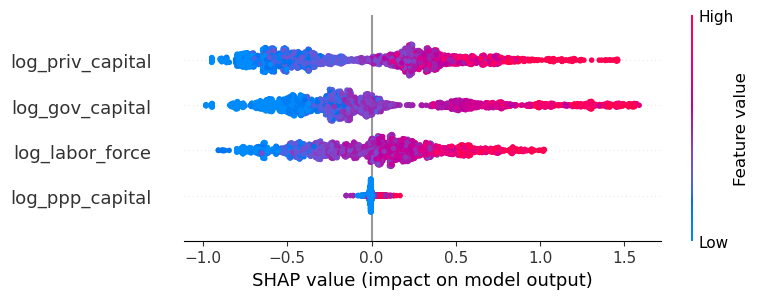


PDP and SHAP for Emerging Market Economies 


<Figure size 1400x600 with 0 Axes>

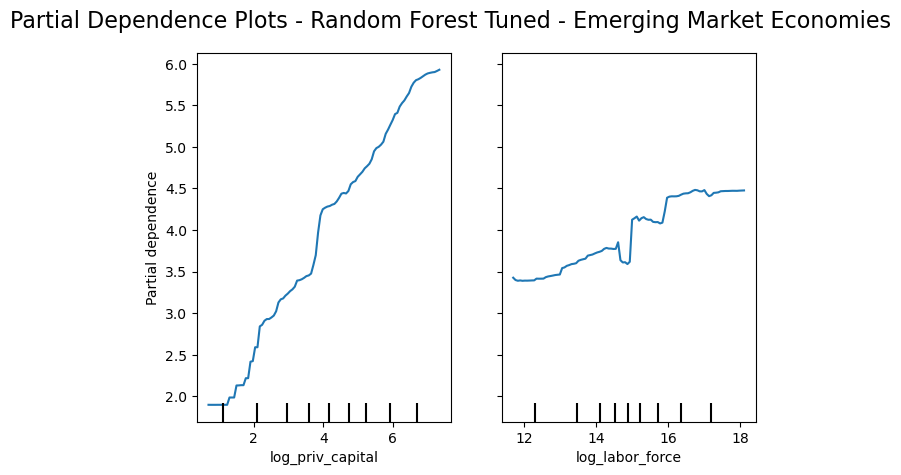

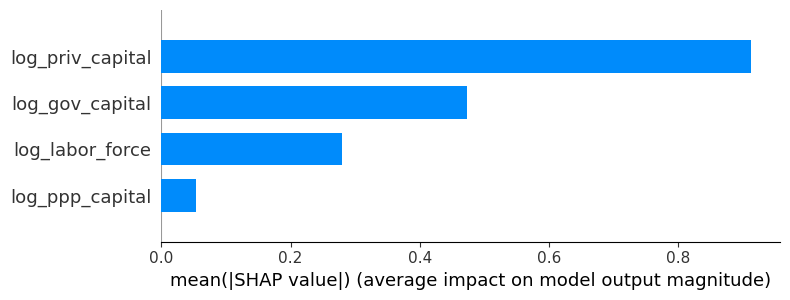

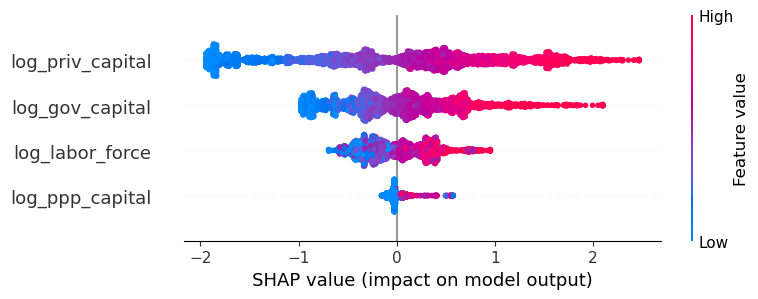


PDP and SHAP for Advanced Economies 


<Figure size 1400x600 with 0 Axes>

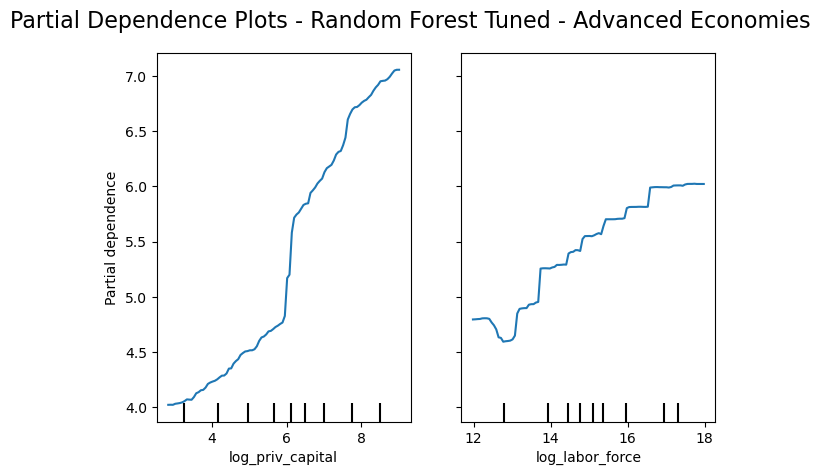

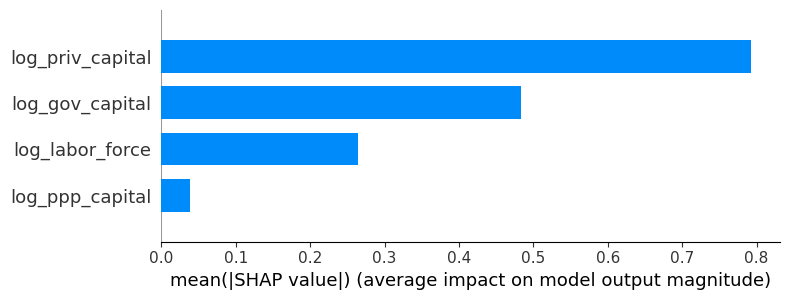

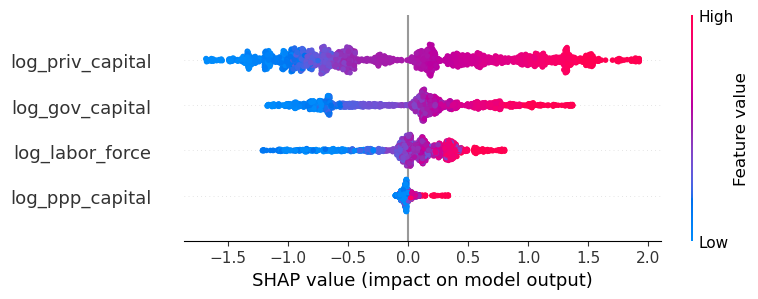

In [70]:
auto_pdp_shap_all_groups(tuned_models, groups_data, log_features)


**XGBOOST**

We define a function to train an XGBoost regressor on the dataset, evaluate its performance on a held-out test set, and apply time-series cross-validation to measure the model’s consistency using MSE and R² metrics.


In [71]:
def train_and_cv_xgb(X, y, group_label="Group"):
    print(f"\nXGBoost Training and Evaluation for {group_label}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model_xgb = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    model_xgb.fit(X_train, y_train)

    y_pred = model_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test R² : {r2:.4f}")

    avg_mse, avg_r2 = cross_validate_models(model_xgb, X_train, y_train, cv_type='timeseries', n_splits=5)

    return model_xgb


We apply the XGBoost training and evaluation pipeline separately to Low Income Developing Countries, Emerging Market Economies, and Advanced Economies, allowing us to compare model performance across different stages of economic development.


In [72]:
model_xgb_low = train_and_cv_xgb(X_low_log, y_low_log, group_label="Low Income Developing Countries")
model_xgb_emerging = train_and_cv_xgb(X_emerging_log, y_emerging_log, group_label="Emerging Market Economies")
model_xgb_advanced = train_and_cv_xgb(X_advanced_log, y_advanced_log, group_label="Advanced Economies")



XGBoost Training and Evaluation for Low Income Developing Countries
Test MSE: 0.3907
Test R² : 0.7124
Fold 1: MSE=0.0666, R²=0.9418
Fold 2: MSE=0.1356, R²=0.9007
Fold 3: MSE=0.2574, R²=0.8055
Fold 4: MSE=0.4926, R²=0.5184
Fold 5: MSE=0.1736, R²=0.9042

Average MSE: 0.2251
Average R² : 0.8141


XGBoost Training and Evaluation for Emerging Market Economies
Test MSE: 0.1908
Test R² : 0.9590
Fold 1: MSE=0.6105, R²=0.8425
Fold 2: MSE=0.3795, R²=0.8947
Fold 3: MSE=0.1649, R²=0.9640
Fold 4: MSE=0.4192, R²=0.8082
Fold 5: MSE=0.1874, R²=0.9223

Average MSE: 0.3523
Average R² : 0.8864


XGBoost Training and Evaluation for Advanced Economies
Test MSE: 0.1895
Test R² : 0.9373
Fold 1: MSE=1.9835, R²=-0.2619
Fold 2: MSE=0.2381, R²=0.9537
Fold 3: MSE=0.0540, R²=0.9823
Fold 4: MSE=0.7333, R²=0.2429
Fold 5: MSE=0.0682, R²=0.8773

Average MSE: 0.6154
Average R² : 0.5589



XGBOOST yeilds poor results than Random Forest Model

**Panel Data Analysis on R packages**

We define a function to fit both fixed effects and random effects panel models on the log-transformed GDP and capital variables.


In [73]:
def run_panel_model_single(panel_df, group_label="All Panel"):
    print(f"\nPanel Modeling for {group_label}")

    panel_df = panel_df.reset_index() if not {'country', 'year'}.issubset(panel_df.index.names) else panel_df

    for col in ['priv_capital', 'gov_capital', 'ppp_capital', 'labor_force', 'GDP_rppp']:
        if f'log1p_{col}' not in panel_df.columns:
            panel_df[f'log1p_{col}'] = np.log1p(panel_df[col])

    df_panel = panel_df.set_index(['country', 'year']).sort_index()

    y = df_panel['log1p_GDP_rppp']
    X = df_panel[['log1p_priv_capital', 'log1p_gov_capital', 'log1p_ppp_capital', 'log1p_labor_force']]
    X = sm.add_constant(X)

    fe = PanelOLS(y, X, entity_effects=True)
    fe_res = fe.fit()
    print("Fixed Effects Results")
    print(fe_res)

    re = RandomEffects(y, X)
    re_res = re.fit()
    print("\nRandom Effects Results")
    print(re_res)

    cmp = compare({'Fixed': fe_res, 'Random': re_res})
    print("\nHausman Test Comparison")
    print(cmp)

    ent = fe_res.estimated_effects
    country_fe = (
        ent
        .groupby('country')['estimated_effects']
        .mean()
        .reset_index()
        .rename(columns={'estimated_effects': 'country_fixed_effect'})
    )

    fe_time_res = PanelOLS(y, X, time_effects=True).fit()
    tim = fe_time_res.estimated_effects
    time_fe = (
        tim
        .groupby('year')['estimated_effects']
        .mean()
        .reset_index()
        .rename(columns={'estimated_effects': 'time_fixed_effect'})
    )

    residuals = re_res.resids
    if isinstance(residuals, pd.Series):
        residuals = residuals.to_frame(name='residuals')
    else:
        residuals = residuals.rename(columns={residuals.columns[0]: 'residuals'})

    country_re = (
        residuals
        .groupby('country')['residuals']
        .mean()
        .reset_index()
        .rename(columns={'residuals': 'country_random_effect'})
    )

    sigma2_e = re_res.variance_decomposition['Residual']
    sigma2_u = re_res.variance_decomposition['Effects']
    panel_sizes = df_panel.groupby('country').size()
    weight = sigma2_u / (sigma2_u + sigma2_e / panel_sizes)
    country_re['country_random_effect'] = country_re['country_random_effect'] * weight.reindex(country_re['country']).values

    country_effects_df = country_re.merge(country_fe, on='country', how='left')[['country', 'country_random_effect', 'country_fixed_effect']]

    result_df = (
        panel_df.reset_index()
        .merge(country_re, on='country', how='left')
        .merge(country_fe, on='country', how='left')
        .merge(time_fe, on='year', how='left')
    )[['country', 'year', 'country_random_effect', 'country_fixed_effect', 'time_fixed_effect']]

    print(f"\nCountry Effects for {group_label} (Random and Fixed Effects, one row per country):")
    display(country_effects_df)

    print(f"\nTime Effects for {group_label} (Fixed Effects, one row per year):")
    display(time_fe)

    return result_df

We define a function that allows users to input a country name and view its estimated random and fixed effects from the panel models, both for the full dataset and within its income group.


In [74]:
def display_country_effects(df_cleaned):

    panel_all = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])
    result_df_all = run_panel_model_single(panel_all.reset_index(), group_label="All Countries (No Grouping)")

    print("\nAvailable countries in the dataset:")
    print(result_df_all['country'].unique())

    while True:
        try:
            country_to_print = input("\nEnter a country name to see its effects (or 'stop' to exit): ").strip().lower()
            if country_to_print == 'stop':
                print("Exiting the function.")
                break

            country_data_all = result_df_all[result_df_all['country'].str.lower() == country_to_print]
            if country_data_all.empty:
                print(f"No data found for country: {country_to_print}")
                continue

            print(f"\nEffects for {country_to_print.capitalize()} in All Countries (No Grouping):")
            display(country_data_all)

            country_income_group = df_cleaned[df_cleaned['country'].str.lower() == country_to_print]['income_group'].iloc[0]
            if pd.isna(country_income_group):
                print(f"No income group found for {country_to_print.capitalize()}.")
                continue

            income_group_df = (
                df_cleaned[df_cleaned['income_group'] == country_income_group]
                .sort_values(['country', 'year'])
                .set_index(['country', 'year'])
            )
            result_df_income = run_panel_model_single(income_group_df.reset_index(), group_label=country_income_group)

            country_data_income = result_df_income[result_df_income['country'].str.lower() == country_to_print]
            print(f"\nEffects for {country_to_print.capitalize()} in {country_income_group}:")
            display(country_data_income)

        except Exception as e:
            print(f"An error occurred: {e}. Please try again or type 'stop' to exit.")

We fit fixed effects and random effects panel models on the full dataset without separating by income group, helping to capture overall patterns and country-specific deviations in the global panel of countries.


In [75]:
panel_2 = df_cleaned.sort_values(['country', 'year']).set_index(['country', 'year'])
run_panel_model_single(panel_2.reset_index(), group_label="All Countries (No Grouping)")



Panel Modeling for All Countries (No Grouping)
Fixed Effects Results


C:\Conda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Conda\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8089
Estimator:                   PanelOLS   R-squared (Between):              0.8943
No. Observations:                8652   R-squared (Within):               0.8089
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.8911
Time:                        23:57:08   Log-likelihood                   -71.788
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8985.7
Entities:                         155   P-value                           0.0000
Avg Obs:                       55.819   Distribution:                  F(4,8493)
Min Obs:                       11.000                                           
Max Obs:                       60.000   F-statistic (robust):             8985.7
                            

C:\Conda\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Conda\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                       Model Comparison                      
                                     Fixed             Random
-------------------------------------------------------------
Dep. Variable               log1p_GDP_rppp     log1p_GDP_rppp
Estimator                         PanelOLS      RandomEffects
No. Observations                      8652               8652
Cov. Est.                       Unadjusted         Unadjusted
R-squared                           0.8089             0.8159
R-Squared (Within)                  0.8089             0.8081
R-Squared (Between)                 0.8943             0.9233
R-Squared (Overall)                 0.8911             0.9176
F-statistic                         8985.7             9578.1
P-value (F-stat)                    0.0000             0.0000
=====================     ================   ================
const                              -6.8406            -5.3780
                                 (-28.155)          (-26.902)
log1p_pr

country  country_random_effect  country_fixed_effect
0            Afghanistan                -0.0382               -0.5327
1                Albania                -0.0009                0.0684
2                Algeria                -0.0109               -0.1941
3                 Angola                -0.0421               -0.5934
4    Antigua and Barbuda                -0.0901               -1.1938
..                   ...                    ...                   ...
150        United States                -0.0387               -0.7415
151              Uruguay                -0.0005                0.0897
152           Uzbekistan                 0.0738                0.8637
153               Zambia                 0.0103                0.1314
154             Zimbabwe                -0.0143               -0.2272

[155 rows x 3 columns]


Time Effects for All Countries (No Grouping) (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960             0.0176
1   1961             0.0214
2   1962             0.0215
3   1963             0.0235
4   1964             0.0346
5   1965             0.0301
6   1966             0.0207
7   1967             0.0194
8   1968             0.0198
9   1969             0.0330
10  1970             0.0471
11  1971             0.0529
12  1972             0.0545
13  1973             0.0715
14  1974             0.0704
15  1975             0.0520
16  1976             0.0534
17  1977             0.0838
18  1978             0.0908
19  1979             0.0792
20  1980             0.0545
21  1981             0.0383
22  1982             0.0176
23  1983            -0.0046
24  1984             0.0008
25  1985             0.0003
26  1986             0.0031
27  1987             0.0034
28  1988             0.0105
29  1989             0.0099
30  1990             0.0066
31  1991            -0.0335
32  1992            -0.0669
33  1993            -0.0808
34  1994            -0.0914
35  1995            -0.0876
36  1996            -0.0744
37  1997            -0.0629
38  1998            -0.0368
39  1999            -0.0397
40  2000            -0.0343
41  2001            -0.0338
42  2002            -0.0286
43  2003            -0.0232
44  2004            -0.0067
45  2005             0.0140
46  2006             0.0210
47  2007             0.0313
48  2008             0.0198
49  2009            -0.0192
50  2010            -0.0160
51  2011            -0.0178
52  2012            -0.0137
53  2013            -0.0288
54  2014            -0.0355
55  2015            -0.0456
56  2016            -0.0480
57  2017            -0.0460
58  2018            -0.0452
59  2019            -0.0449

country  year  country_random_effect  country_fixed_effect   
0     Afghanistan  1960                -0.0382               -0.5327  \
1     Afghanistan  1961                -0.0382               -0.5327   
2     Afghanistan  1962                -0.0382               -0.5327   
3     Afghanistan  1963                -0.0382               -0.5327   
4     Afghanistan  1964                -0.0382               -0.5327   
...           ...   ...                    ...                   ...   
9137     Zimbabwe  2015                -0.0143               -0.2272   
9138     Zimbabwe  2016                -0.0143               -0.2272   
9139     Zimbabwe  2017                -0.0143               -0.2272   
9140     Zimbabwe  2018                -0.0143               -0.2272   
9141     Zimbabwe  2019                -0.0143               -0.2272   

      time_fixed_effect  
0                0.0176  
1                0.0214  
2                0.0215  
3                0.0235  
4                0.0346  
...                 ...  
9137            -0.0456  
9138            -0.0480  
9139            -0.0460  
9140            -0.0452  
9141            -0.0449  

[9142 rows x 5 columns]

We apply fixed and random effects panel modeling specifically to the Low Income Developing Countries group.


In [76]:
low_income_df = (
    df_cleaned[df_cleaned['income_group'] == 'Low Income Developing Countries']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)

run_panel_model_single(low_income_df.reset_index(), group_label="Low Income Developing Countries")


Panel Modeling for Low Income Developing Countries
Fixed Effects Results
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8110
Estimator:                   PanelOLS   R-squared (Between):              0.8200
No. Observations:                2715   R-squared (Within):               0.8110
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.8209
Time:                        23:57:09   Log-likelihood                    19.332
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2858.2
Entities:                          46   P-value                           0.0000
Avg Obs:                       59.022   Distribution:                  F(4,2665)
Min Obs:                       36.000                                           
Max Obs:                       60.0

country  country_random_effect  country_fixed_effect
0                Afghanistan                -0.0241               -0.2952
1                 Bangladesh                -0.0195               -0.3869
2                      Benin                -0.0336               -0.4132
3                     Bhutan                 0.0229                0.4568
4               Burkina Faso                -0.0176               -0.2571
5                    Burundi                -0.0327               -0.4091
6                   Cambodia                -0.0060               -0.0944
7                   Cameroon                -0.0010               -0.0368
8   Central African Republic                -0.0516               -0.6039
9                       Chad                -0.0043               -0.0543
10                   Comoros                 0.0568                0.9452
11                  Djibouti                 0.0778                0.9682
12                   Eritrea                -0.0176               -0.1580
13                  Ethiopia                -0.0403               -0.6494
14               Gambia, The                 0.0577                0.7629
15                     Ghana                -0.0137               -0.2088
16                    Guinea                 0.0279                0.3626
17             Guinea-Bissau                 0.0321                0.5316
18                     Haiti                 0.0013                0.0249
19                  Honduras                -0.0147               -0.1386
20                     Kenya                -0.0071               -0.1433
21                   Lesotho                -0.0092               -0.0306
22                   Liberia                -0.0199               -0.1941
23                Madagascar                 0.0104                0.0772
24                    Malawi                -0.0362               -0.5000
25                      Mali                -0.0333               -0.4564
26                Mauritania                 0.0241                0.4373
27                   Moldova                 0.0847                1.1662
28                Mozambique                -0.0570               -0.7904
29                   Myanmar                -0.0060               -0.1907
30                     Nepal                 0.0046                0.0406
31                 Nicaragua                 0.0127                0.2285
32                     Niger                -0.0395               -0.5240
33                   Nigeria                -0.0628               -0.9336
34          Papua New Guinea                 0.0147                0.2298
35                    Rwanda                 0.0021                0.0230
36                   Senegal                 0.0191                0.2719
37              Sierra Leone                 0.0255                0.3603
38                     Sudan                 0.0497                0.6252
39                Tajikistan                 0.0065                0.1579
40                  Tanzania                -0.0482               -0.7067
41                      Togo                -0.0254               -0.2790
42                    Uganda                -0.0100               -0.1895
43                Uzbekistan                 0.0843                1.0358
44                    Zambia                 0.0340                0.4474
45                  Zimbabwe                 0.0081                0.0917


Time Effects for Low Income Developing Countries (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960            -0.0690
1   1961            -0.0702
2   1962            -0.0673
3   1963            -0.0440
4   1964            -0.0322
5   1965            -0.0282
6   1966            -0.0378
7   1967            -0.0418
8   1968            -0.0363
9   1969            -0.0119
10  1970             0.0070
11  1971             0.0183
12  1972             0.0044
13  1973            -0.0024
14  1974             0.0090
15  1975            -0.0001
16  1976            -0.0068
17  1977             0.0099
18  1978             0.0373
19  1979             0.0145
20  1980            -0.0258
21  1981            -0.0391
22  1982            -0.0300
23  1983            -0.0586
24  1984            -0.0513
25  1985            -0.0453
26  1986            -0.0322
27  1987            -0.0326
28  1988            -0.0158
29  1989            -0.0224
30  1990            -0.0226
31  1991            -0.0347
32  1992            -0.0625
33  1993            -0.0585
34  1994            -0.0947
35  1995            -0.0768
36  1996            -0.0735
37  1997            -0.0628
38  1998            -0.0537
39  1999            -0.0437
40  2000            -0.0475
41  2001            -0.0250
42  2002            -0.0162
43  2003            -0.0044
44  2004             0.0020
45  2005             0.0209
46  2006             0.0338
47  2007             0.0473
48  2008             0.0533
49  2009             0.0601
50  2010             0.0829
51  2011             0.0986
52  2012             0.1229
53  2013             0.1096
54  2014             0.1200
55  2015             0.1164
56  2016             0.1158
57  2017             0.1178
58  2018             0.1219
59  2019             0.1292

country  year  country_random_effect  country_fixed_effect   
0     Afghanistan  1960                -0.0241               -0.2952  \
1     Afghanistan  1961                -0.0241               -0.2952   
2     Afghanistan  1962                -0.0241               -0.2952   
3     Afghanistan  1963                -0.0241               -0.2952   
4     Afghanistan  1964                -0.0241               -0.2952   
...           ...   ...                    ...                   ...   
2710     Zimbabwe  2015                 0.0081                0.0917   
2711     Zimbabwe  2016                 0.0081                0.0917   
2712     Zimbabwe  2017                 0.0081                0.0917   
2713     Zimbabwe  2018                 0.0081                0.0917   
2714     Zimbabwe  2019                 0.0081                0.0917   

      time_fixed_effect  
0               -0.0690  
1               -0.0702  
2               -0.0673  
3               -0.0440  
4               -0.0322  
...                 ...  
2710             0.1164  
2711             0.1158  
2712             0.1178  
2713             0.1219  
2714             0.1292  

[2715 rows x 5 columns]

We fit fixed and random effects panel models to the Emerging Market Economies group to better understand country-specific patterns and growth dynamics within this rapidly developing segment.


In [77]:
emerging_df = (
    df_cleaned[df_cleaned['income_group'] == 'Emerging Market Economies']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)
run_panel_model_single(emerging_df.reset_index(), group_label="Emerging Market Economies")



Panel Modeling for Emerging Market Economies
Fixed Effects Results
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8086
Estimator:                   PanelOLS   R-squared (Between):              0.9128
No. Observations:                4138   R-squared (Within):               0.8086
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.9113
Time:                        23:57:09   Log-likelihood                   -280.90
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4286.0
Entities:                          77   P-value                           0.0000
Avg Obs:                       53.740   Distribution:                  F(4,4057)
Min Obs:                       11.000                                           
Max Obs:                       60.000   F

C:\Conda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Conda\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Conda\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



Random Effects Results
                        RandomEffects Estimation Summary                        
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8143
Estimator:              RandomEffects   R-squared (Between):              0.9222
No. Observations:                4138   R-squared (Within):               0.8084
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.9204
Time:                        23:57:09   Log-likelihood                   -329.97
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4531.4
Entities:                          77   P-value                           0.0000
Avg Obs:                       53.740   Distribution:                  F(4,4133)
Min Obs:                       11.000                                           
Max Obs:                       60.000   F-statistic (robust):             4537.5
    

C:\Conda\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


country  country_random_effect  country_fixed_effect
0                Albania                -0.0088               -0.0894
1                Algeria                -0.0068               -0.1270
2                 Angola                -0.0379               -0.5589
3    Antigua and Barbuda                -0.0874               -1.2132
4              Argentina                 0.0297                0.3684
..                   ...                    ...                   ...
72              Thailand                -0.0479               -0.7712
73               Tunisia                -0.0051               -0.0680
74               Ukraine                 0.0101                0.0717
75  United Arab Emirates                -0.0058               -0.0165
76               Uruguay                -0.0078               -0.0660

[77 rows x 3 columns]


Time Effects for Emerging Market Economies (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960             0.1016
1   1961             0.1049
2   1962             0.0974
3   1963             0.0771
4   1964             0.0852
5   1965             0.0753
6   1966             0.0671
7   1967             0.0667
8   1968             0.0622
9   1969             0.0677
10  1970             0.0766
11  1971             0.0902
12  1972             0.1046
13  1973             0.1299
14  1974             0.1286
15  1975             0.1130
16  1976             0.1167
17  1977             0.1645
18  1978             0.1594
19  1979             0.1491
20  1980             0.1331
21  1981             0.1057
22  1982             0.0629
23  1983             0.0431
24  1984             0.0499
25  1985             0.0442
26  1986             0.0405
27  1987             0.0412
28  1988             0.0436
29  1989             0.0379
30  1990             0.0284
31  1991            -0.0357
32  1992            -0.0765
33  1993            -0.0977
34  1994            -0.1025
35  1995            -0.1177
36  1996            -0.0976
37  1997            -0.0960
38  1998            -0.0547
39  1999            -0.0734
40  2000            -0.0675
41  2001            -0.0769
42  2002            -0.0756
43  2003            -0.0699
44  2004            -0.0443
45  2005            -0.0183
46  2006            -0.0115
47  2007             0.0032
48  2008            -0.0121
49  2009            -0.0627
50  2010            -0.0714
51  2011            -0.0828
52  2012            -0.0815
53  2013            -0.0999
54  2014            -0.1218
55  2015            -0.1466
56  2016            -0.1517
57  2017            -0.1554
58  2018            -0.1586
59  2019            -0.1623

country  year  country_random_effect  country_fixed_effect   
0     Albania  1960                -0.0088               -0.0894  \
1     Albania  1961                -0.0088               -0.0894   
2     Albania  1962                -0.0088               -0.0894   
3     Albania  1963                -0.0088               -0.0894   
4     Albania  1964                -0.0088               -0.0894   
...       ...   ...                    ...                   ...   
4502  Uruguay  2015                -0.0078               -0.0660   
4503  Uruguay  2016                -0.0078               -0.0660   
4504  Uruguay  2017                -0.0078               -0.0660   
4505  Uruguay  2018                -0.0078               -0.0660   
4506  Uruguay  2019                -0.0078               -0.0660   

      time_fixed_effect  
0                0.1016  
1                0.1049  
2                0.0974  
3                0.0771  
4                0.0852  
...                 ...  
4502            -0.1466  
4503            -0.1517  
4504            -0.1554  
4505            -0.1586  
4506            -0.1623  

[4507 rows x 5 columns]

We fit fixed and random effects panel models to the Advanced Economies group to better understand country-specific patterns and growth dynamics within this rapidly developing segment.


In [78]:
advanced_df = (
    df_cleaned[df_cleaned['income_group'] == 'Advanced Economies']
    .sort_values(['country', 'year'])
    .set_index(['country', 'year'])
)
run_panel_model_single(advanced_df.reset_index(), group_label="Advanced Economies")

C:\Conda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Conda\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



Panel Modeling for Advanced Economies
Fixed Effects Results
                          PanelOLS Estimation Summary                           
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8545
Estimator:                   PanelOLS   R-squared (Between):              0.0642
No. Observations:                1799   R-squared (Within):               0.8545
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.1187
Time:                        23:57:10   Log-likelihood                    499.35
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2588.7
Entities:                          32   P-value                           0.0000
Avg Obs:                       56.219   Distribution:                  F(4,1763)
Min Obs:                       20.000                                           
Max Obs:                       60.000   F-statis

C:\Conda\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



Random Effects Results


C:\Conda\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                        RandomEffects Estimation Summary                        
Dep. Variable:         log1p_GDP_rppp   R-squared:                        0.8409
Estimator:              RandomEffects   R-squared (Between):              0.9135
No. Observations:                1799   R-squared (Within):               0.8275
Date:                Sun, Apr 27 2025   R-squared (Overall):              0.9069
Time:                        23:57:10   Log-likelihood                    281.23
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2369.7
Entities:                          32   P-value                           0.0000
Avg Obs:                       56.219   Distribution:                  F(4,1794)
Min Obs:                       20.000                                           
Max Obs:                       60.000   F-statistic (robust):             2332.7
                            

country  country_random_effect  country_fixed_effect
0         Australia                -0.0480               -0.9407
1           Austria                 0.0003               -0.0290
2           Belgium                 0.0083               -0.0035
3            Canada                -0.0615               -1.4874
4            Cyprus                -0.0190                1.4108
5           Denmark                 0.0381                0.4726
6           Estonia                 0.0576                1.8191
7           Finland                -0.0038                0.2123
8            France                -0.0445               -1.9215
9           Germany                -0.0588               -2.3426
10           Greece                 0.0104               -0.0280
11          Iceland                 0.0632                3.0376
12          Ireland                 0.0269                0.8095
13           Israel                 0.0036                0.3549
14            Italy                -0.0398               -1.7714
15            Japan                -0.1203               -3.0583
16           Latvia                 0.0589                1.5555
17        Lithuania                 0.0766                1.2641
18       Luxembourg                 0.1287                3.4673
19            Malta                 0.0809                3.0776
20      Netherlands                -0.0130               -0.7728
21      New Zealand                 0.0197                0.6689
22           Norway                 0.0009                0.4793
23         Portugal                -0.0225               -0.4281
24        Singapore                 0.0217                0.5202
25  Slovak Republic                 0.0114                0.3490
26         Slovenia                 0.0569                1.5350
27            Spain                -0.0348               -1.4794
28           Sweden                -0.0081               -0.2974
29      Switzerland                -0.0247               -0.0792
30   United Kingdom                -0.0477               -1.9974
31    United States                -0.1100               -3.5026


Time Effects for Advanced Economies (Fixed Effects, one row per year):


year  time_fixed_effect
0   1960            -0.4319
1   1961            -0.4059
2   1962            -0.3770
3   1963            -0.3421
4   1964            -0.3099
5   1965            -0.2968
6   1966            -0.2928
7   1967            -0.2721
8   1968            -0.2507
9   1969            -0.2189
10  1970            -0.1799
11  1971            -0.1870
12  1972            -0.1669
13  1973            -0.1166
14  1974            -0.1252
15  1975            -0.1446
16  1976            -0.1279
17  1977            -0.1013
18  1978            -0.0857
19  1979            -0.0709
20  1980            -0.0684
21  1981            -0.0602
22  1982            -0.0651
23  1983            -0.0654
24  1984            -0.0434
25  1985            -0.0323
26  1986            -0.0096
27  1987             0.0044
28  1988             0.0223
29  1989             0.0476
30  1990             0.0595
31  1991             0.0368
32  1992             0.0066
33  1993            -0.0095
34  1994             0.0076
35  1995             0.0312
36  1996             0.0454
37  1997             0.0753
38  1998             0.1015
39  1999             0.1126
40  2000             0.1358
41  2001             0.1418
42  2002             0.1504
43  2003             0.1563
44  2004             0.1765
45  2005             0.1892
46  2006             0.2124
47  2007             0.2300
48  2008             0.2084
49  2009             0.1447
50  2010             0.1590
51  2011             0.1675
52  2012             0.1603
53  2013             0.1608
54  2014             0.1712
55  2015             0.1937
56  2016             0.2040
57  2017             0.2231
58  2018             0.2377
59  2019             0.2433

country  year  country_random_effect  country_fixed_effect   
0         Australia  1960                -0.0480               -0.9407  \
1         Australia  1961                -0.0480               -0.9407   
2         Australia  1962                -0.0480               -0.9407   
3         Australia  1963                -0.0480               -0.9407   
4         Australia  1964                -0.0480               -0.9407   
...             ...   ...                    ...                   ...   
1915  United States  2015                -0.1100               -3.5026   
1916  United States  2016                -0.1100               -3.5026   
1917  United States  2017                -0.1100               -3.5026   
1918  United States  2018                -0.1100               -3.5026   
1919  United States  2019                -0.1100               -3.5026   

      time_fixed_effect  
0               -0.4319  
1               -0.4059  
2               -0.3770  
3               -0.3421  
4               -0.3099  
...                 ...  
1915             0.1937  
1916             0.2040  
1917             0.2231  
1918             0.2377  
1919             0.2433  

[1920 rows x 5 columns]

In [79]:
# display_country_effects(df_cleaned)